In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.RMSProp(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_state = action_user_one_hot[:]
        mod_state = np.array(mod_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
class Mod_Agent:
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        action_user = np.argmax(state[:4])
        action_mod = 1
        new_loc, reward, done = env.step(action_user, action_mod, target_loc, curr_loc)
        
        return new_loc, reward, done

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.5 0.9]
 [0.5 0.8]
 [0.5 0.3]
 [0.  0.4]
 [0.1 0.3]
 [0.  0. ]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
________

In [5]:
state = [0.1,0.1,0.3,0.3]
state = np.array(state)
next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
print(next_state, reward,done)

user_agent.replay_buffer.print()

print(user_agent.model(np.array([state])))

[0.2, 0.1, 0.3, 0.3] 1 0
deque([array([0.1, 0.1, 0.3, 0.3])], maxlen=1024)
deque([1], maxlen=1024)
deque([1], maxlen=1024)
deque([[0.2, 0.1, 0.3, 0.3]], maxlen=1024)
deque([0], maxlen=1024)
tf.Tensor([[-0.02010264  0.12869279  0.10983102  0.11808152]], shape=(1, 4), dtype=float32)


  0%|                                                                             | 118/100000 [00:01<23:32, 70.70it/s]

Updated Weights
Mean Reward = -3.00990099009901
2


  0%|▏                                                                            | 213/100000 [00:02<18:38, 89.20it/s]

Updated Weights
Mean Reward = -2.74
4


  0%|▏                                                                            | 314/100000 [00:03<19:48, 83.89it/s]

Updated Weights
Mean Reward = -1.17
5


  0%|▎                                                                            | 414/100000 [00:05<20:25, 81.26it/s]

Updated Weights
Mean Reward = -2.78
1


  0%|▍                                                                            | 498/100000 [00:06<28:40, 57.85it/s]

Updated Weights
Mean Reward = -2.97
5


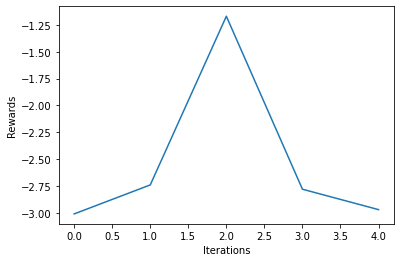

  1%|▍                                                                            | 608/100000 [00:09<40:44, 40.66it/s]

Updated Weights
Mean Reward = -0.84
5


  1%|▌                                                                            | 709/100000 [00:11<25:04, 65.98it/s]

Updated Weights
Mean Reward = -0.15
2


  1%|▌                                                                            | 810/100000 [00:13<29:51, 55.37it/s]

Updated Weights
Mean Reward = -0.72
4


  1%|▋                                                                            | 903/100000 [00:14<49:51, 33.12it/s]

Updated Weights
Mean Reward = 0.85
5


  1%|▋                                                                          | 999/100000 [00:18<1:05:28, 25.20it/s]

Updated Weights
Mean Reward = -0.75
4


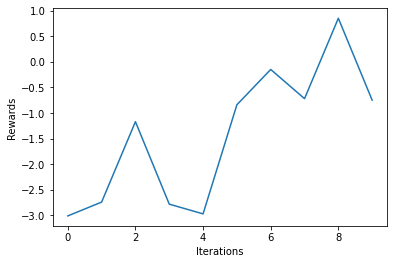

  1%|▊                                                                           | 1105/100000 [00:20<32:41, 50.43it/s]

Updated Weights
Mean Reward = 0.8
4


  1%|▉                                                                           | 1208/100000 [00:23<36:27, 45.15it/s]

Updated Weights
Mean Reward = -0.68
2


  1%|▉                                                                           | 1304/100000 [00:25<52:10, 31.53it/s]

Updated Weights
Mean Reward = 0.19
3


  1%|█                                                                           | 1406/100000 [00:28<44:38, 36.81it/s]

Updated Weights
Mean Reward = 0.62
7


  1%|█▏                                                                          | 1499/100000 [00:31<46:25, 35.37it/s]

Updated Weights
Mean Reward = 0.24
4


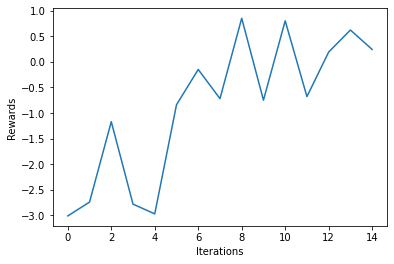

  2%|█▏                                                                          | 1606/100000 [00:34<51:02, 32.13it/s]

Updated Weights
Mean Reward = 2.68
3


  2%|█▎                                                                          | 1706/100000 [00:38<54:53, 29.85it/s]

Updated Weights
Mean Reward = 0.23
3


  2%|█▎                                                                          | 1803/100000 [00:41<52:36, 31.11it/s]

Updated Weights
Mean Reward = 0.05
3


  2%|█▍                                                                          | 1907/100000 [00:44<52:07, 31.37it/s]

Updated Weights
Mean Reward = 0.66
7


  2%|█▌                                                                          | 1999/100000 [00:47<46:50, 34.87it/s]

Updated Weights
Mean Reward = 0.85
6


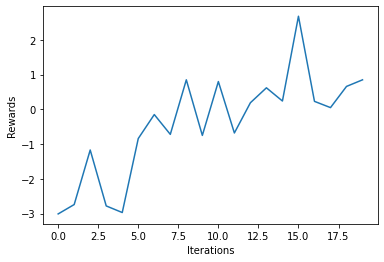

  2%|█▌                                                                        | 2105/100000 [00:51<1:04:36, 25.25it/s]

Updated Weights
Mean Reward = -0.23
1


  2%|█▋                                                                          | 2206/100000 [00:54<53:22, 30.54it/s]

Updated Weights
Mean Reward = -0.07
7


  2%|█▊                                                                          | 2306/100000 [00:58<57:25, 28.35it/s]

Updated Weights
Mean Reward = 1.15
3


  2%|█▊                                                                        | 2405/100000 [01:01<1:04:39, 25.16it/s]

Updated Weights
Mean Reward = -0.91
3


  2%|█▊                                                                        | 2499/100000 [01:05<1:02:22, 26.05it/s]

Updated Weights
Mean Reward = 2.05
3


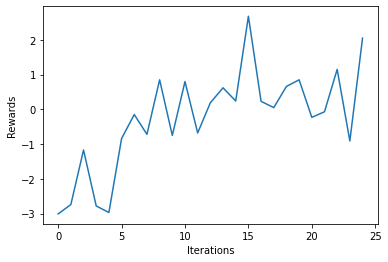

  3%|█▉                                                                        | 2606/100000 [01:09<1:02:03, 26.15it/s]

Updated Weights
Mean Reward = 0.44
0


  3%|██                                                                          | 2704/100000 [01:13<55:24, 29.26it/s]

Updated Weights
Mean Reward = 0.6
3


  3%|██▏                                                                         | 2804/100000 [01:16<58:17, 27.79it/s]

Updated Weights
Mean Reward = 1.68
2


  3%|██▏                                                                         | 2904/100000 [01:20<58:40, 27.58it/s]

Updated Weights
Mean Reward = 1.47
5


  3%|██▎                                                                         | 3000/100000 [01:23<58:52, 27.46it/s]

Updated Weights
Mean Reward = -0.38
2


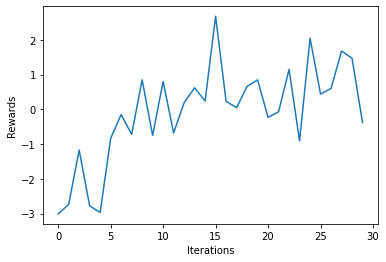

  3%|██▎                                                                         | 3105/100000 [01:28<56:47, 28.43it/s]

Updated Weights
Mean Reward = 0.7
2


  3%|██▍                                                                         | 3206/100000 [01:32<59:47, 26.98it/s]

Updated Weights
Mean Reward = 0.68
2


  3%|██▍                                                                       | 3305/100000 [01:35<1:00:20, 26.71it/s]

Updated Weights
Mean Reward = 2.53
2


  3%|██▌                                                                       | 3406/100000 [01:39<1:04:47, 24.85it/s]

Updated Weights
Mean Reward = 2.31
1


  3%|██▌                                                                       | 3499/100000 [01:44<1:54:42, 14.02it/s]

Updated Weights
Mean Reward = 1.67
6


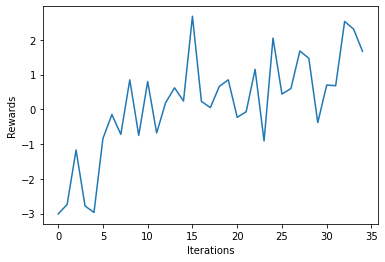

  4%|██▋                                                                       | 3606/100000 [01:48<1:03:58, 25.11it/s]

Updated Weights
Mean Reward = 0.73
3


  4%|██▋                                                                       | 3704/100000 [01:53<1:18:03, 20.56it/s]

Updated Weights
Mean Reward = 0.29
6


  4%|██▊                                                                       | 3803/100000 [01:57<1:05:49, 24.35it/s]

Updated Weights
Mean Reward = 1.3
0


  4%|██▉                                                                       | 3903/100000 [02:02<1:04:46, 24.73it/s]

Updated Weights
Mean Reward = 0.57
2


  4%|██▉                                                                       | 3999/100000 [02:06<1:01:30, 26.01it/s]

Updated Weights
Mean Reward = 0.91
5


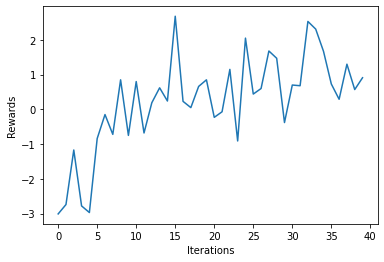

  4%|███                                                                       | 4103/100000 [02:11<1:04:53, 24.63it/s]

Updated Weights
Mean Reward = 0.87
1


  4%|███                                                                       | 4204/100000 [02:15<1:03:37, 25.10it/s]

Updated Weights
Mean Reward = 0.81
4


  4%|███▏                                                                      | 4304/100000 [02:21<1:17:57, 20.46it/s]

Updated Weights
Mean Reward = 1.22
4


  4%|███▎                                                                      | 4405/100000 [02:25<1:12:30, 21.98it/s]

Updated Weights
Mean Reward = 1.37
5


  4%|███▍                                                                        | 4498/100000 [02:29<52:20, 30.41it/s]

Updated Weights
Mean Reward = 1.93
8


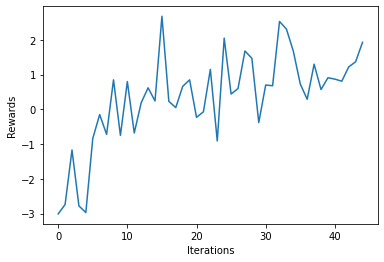

  5%|███▍                                                                      | 4602/100000 [02:33<1:09:43, 22.80it/s]

Updated Weights
Mean Reward = 2.36
7


  5%|███▍                                                                      | 4704/100000 [02:37<1:05:49, 24.13it/s]

Updated Weights
Mean Reward = 1.8
2


  5%|███▋                                                                        | 4803/100000 [02:41<53:21, 29.73it/s]

Updated Weights
Mean Reward = 1.46
10


  5%|███▋                                                                      | 4905/100000 [02:45<1:09:53, 22.67it/s]

Updated Weights
Mean Reward = -0.26
2


  5%|███▊                                                                        | 4998/100000 [02:49<54:59, 28.80it/s]

Updated Weights
Mean Reward = 0.87
3


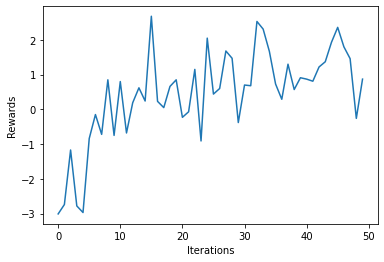

  5%|███▉                                                                        | 5104/100000 [02:53<59:17, 26.67it/s]

Updated Weights
Mean Reward = 0.4
6


  5%|███▉                                                                        | 5206/100000 [02:57<57:01, 27.71it/s]

Updated Weights
Mean Reward = 2.68
13


  5%|████                                                                        | 5304/100000 [03:00<58:39, 26.90it/s]

Updated Weights
Mean Reward = -0.02
1


  5%|███▉                                                                      | 5402/100000 [03:04<1:12:02, 21.89it/s]

Updated Weights
Mean Reward = 1.98
5


  5%|████                                                                      | 5499/100000 [03:08<1:03:05, 24.96it/s]

Updated Weights
Mean Reward = 1.09
6


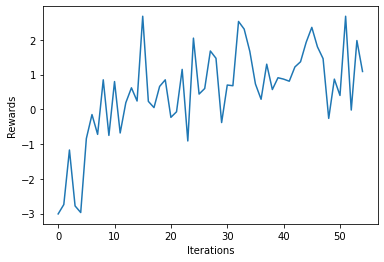

  6%|████▎                                                                       | 5604/100000 [03:12<57:56, 27.15it/s]

Updated Weights
Mean Reward = 2.17
5


  6%|████▏                                                                     | 5703/100000 [03:16<1:00:25, 26.01it/s]

Updated Weights
Mean Reward = 1.39
3


  6%|████▎                                                                     | 5805/100000 [03:21<1:06:55, 23.46it/s]

Updated Weights
Mean Reward = 1.28
3


  6%|████▎                                                                     | 5903/100000 [03:25<1:07:41, 23.17it/s]

Updated Weights
Mean Reward = 0.83
3


  6%|████▍                                                                     | 6000/100000 [03:29<1:02:14, 25.17it/s]

Updated Weights
Mean Reward = 2.14
4


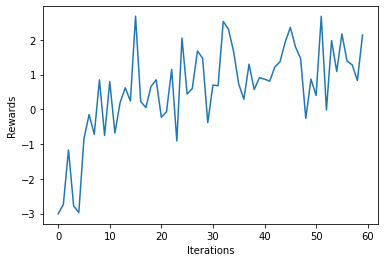

  6%|████▌                                                                     | 6106/100000 [03:33<1:01:01, 25.64it/s]

Updated Weights
Mean Reward = 2.03
3


  6%|████▌                                                                     | 6204/100000 [03:37<1:00:33, 25.82it/s]

Updated Weights
Mean Reward = 1.97
2


  6%|████▊                                                                       | 6305/100000 [03:41<56:10, 27.79it/s]

Updated Weights
Mean Reward = 2.02
4


  6%|████▋                                                                     | 6406/100000 [03:45<1:00:44, 25.68it/s]

Updated Weights
Mean Reward = 1.49
2


  6%|████▉                                                                       | 6500/100000 [03:48<54:14, 28.73it/s]

Updated Weights
Mean Reward = 1.88
9


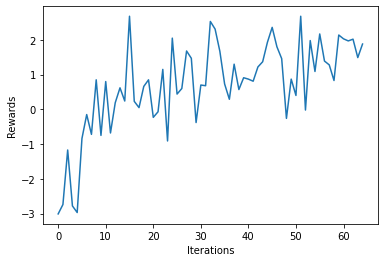

  7%|█████                                                                       | 6605/100000 [03:52<56:39, 27.47it/s]

Updated Weights
Mean Reward = 1.92
6


  7%|█████                                                                       | 6705/100000 [03:56<58:00, 26.80it/s]

Updated Weights
Mean Reward = 0.82
4


  7%|█████▏                                                                      | 6804/100000 [04:00<58:37, 26.50it/s]

Updated Weights
Mean Reward = -0.74
4


  7%|█████                                                                     | 6904/100000 [04:04<1:00:04, 25.83it/s]

Updated Weights
Mean Reward = 3.18
3


  7%|█████▎                                                                      | 6999/100000 [04:07<57:20, 27.03it/s]

Updated Weights
Mean Reward = 1.96
2


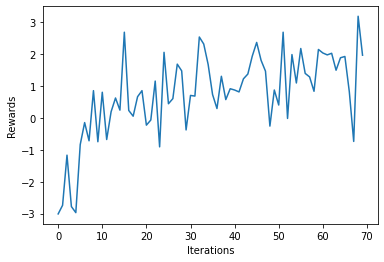

  7%|█████▍                                                                      | 7106/100000 [04:11<59:27, 26.04it/s]

Updated Weights
Mean Reward = 2.16
5


  7%|█████▍                                                                      | 7206/100000 [04:15<59:43, 25.89it/s]

Updated Weights
Mean Reward = 0.69
2


  7%|█████▌                                                                      | 7306/100000 [04:19<59:29, 25.97it/s]

Updated Weights
Mean Reward = 0.46
1


  7%|█████▋                                                                      | 7407/100000 [04:23<53:26, 28.88it/s]

Updated Weights
Mean Reward = 2.21
5


  8%|█████▋                                                                      | 7500/100000 [04:26<58:06, 26.53it/s]

Updated Weights
Mean Reward = 1.7
7


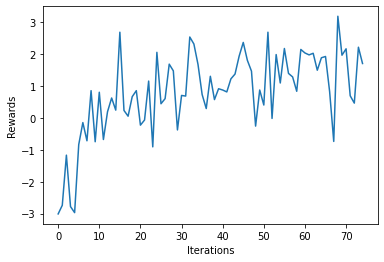

  8%|█████▊                                                                      | 7606/100000 [04:31<59:47, 25.76it/s]

Updated Weights
Mean Reward = 2.14
4


  8%|█████▊                                                                      | 7706/100000 [04:34<57:11, 26.90it/s]

Updated Weights
Mean Reward = 2.16
4


  8%|█████▉                                                                      | 7805/100000 [04:38<59:18, 25.91it/s]

Updated Weights
Mean Reward = 1.02
2


  8%|██████                                                                      | 7905/100000 [04:42<59:15, 25.90it/s]

Updated Weights
Mean Reward = 1.75
6


  8%|██████                                                                      | 8000/100000 [04:46<55:29, 27.63it/s]

Updated Weights
Mean Reward = 0.63
6


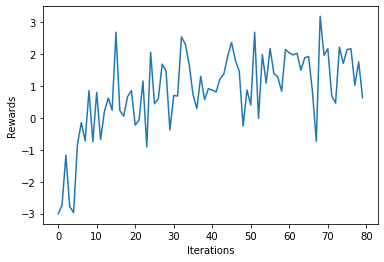

  8%|██████▏                                                                     | 8105/100000 [04:49<55:32, 27.58it/s]

Updated Weights
Mean Reward = 0.91
8


  8%|██████▏                                                                     | 8204/100000 [04:53<57:12, 26.75it/s]

Updated Weights
Mean Reward = -0.4
0


  8%|██████▎                                                                     | 8305/100000 [04:57<57:55, 26.39it/s]

Updated Weights
Mean Reward = 2.41
8


  8%|██████▏                                                                   | 8404/100000 [05:01<1:00:19, 25.31it/s]

Updated Weights
Mean Reward = 0.71
9


  8%|██████▎                                                                   | 8498/100000 [05:04<1:00:52, 25.05it/s]

Updated Weights
Mean Reward = 1.88
7


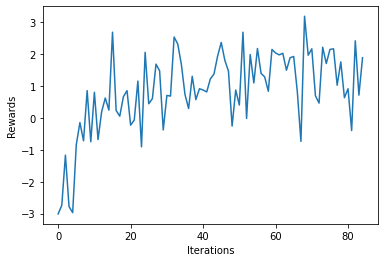

  9%|██████▌                                                                     | 8604/100000 [05:08<51:52, 29.36it/s]

Updated Weights
Mean Reward = 3.48
10


  9%|██████▌                                                                     | 8705/100000 [05:12<58:23, 26.06it/s]

Updated Weights
Mean Reward = 2.3
2


  9%|██████▋                                                                     | 8806/100000 [05:16<59:52, 25.39it/s]

Updated Weights
Mean Reward = 2.72
4


  9%|██████▊                                                                     | 8906/100000 [05:19<56:24, 26.92it/s]

Updated Weights
Mean Reward = 2.75
7


  9%|██████▊                                                                     | 9000/100000 [05:23<59:50, 25.35it/s]

Updated Weights
Mean Reward = 3.02
4


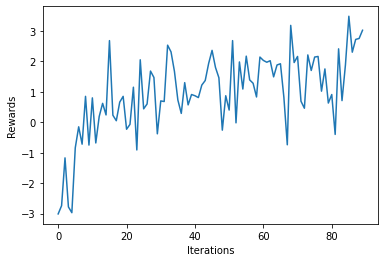

  9%|██████▉                                                                     | 9107/100000 [05:27<56:09, 26.98it/s]

Updated Weights
Mean Reward = 3.54
5


  9%|██████▊                                                                   | 9206/100000 [05:31<1:01:43, 24.52it/s]

Updated Weights
Mean Reward = 3.44
8


  9%|███████                                                                     | 9306/100000 [05:35<57:53, 26.11it/s]

Updated Weights
Mean Reward = 2.4
2


  9%|███████▏                                                                    | 9405/100000 [05:38<59:51, 25.22it/s]

Updated Weights
Mean Reward = -0.51
8


  9%|███████▏                                                                    | 9498/100000 [05:42<58:11, 25.92it/s]

Updated Weights
Mean Reward = 1.4
3


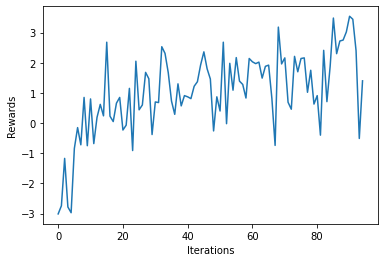

 10%|███████▎                                                                    | 9605/100000 [05:46<56:47, 26.53it/s]

Updated Weights
Mean Reward = 2.24
2


 10%|███████▍                                                                    | 9704/100000 [05:50<59:05, 25.47it/s]

Updated Weights
Mean Reward = 1.52
4


 10%|███████▍                                                                    | 9804/100000 [05:54<49:40, 30.26it/s]

Updated Weights
Mean Reward = 2.88
6


 10%|███████▌                                                                    | 9906/100000 [05:58<58:09, 25.82it/s]

Updated Weights
Mean Reward = 2.72
4


 10%|███████▌                                                                    | 9999/100000 [06:01<57:05, 26.27it/s]

Updated Weights
Mean Reward = 2.81
5


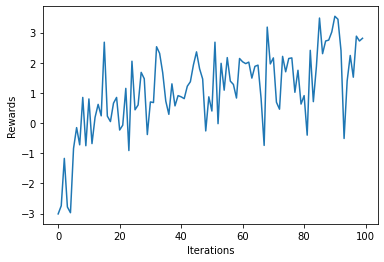

 10%|███████▌                                                                   | 10106/100000 [06:05<57:03, 26.26it/s]

Updated Weights
Mean Reward = 3.38
9


 10%|███████▋                                                                   | 10204/100000 [06:09<56:53, 26.30it/s]

Updated Weights
Mean Reward = 2.78
5


 10%|███████▋                                                                   | 10304/100000 [06:13<54:21, 27.50it/s]

Updated Weights
Mean Reward = 2.54
8


 10%|███████▊                                                                   | 10404/100000 [06:16<56:43, 26.33it/s]

Updated Weights
Mean Reward = 1.06
6


 10%|███████▊                                                                   | 10498/100000 [06:20<53:02, 28.12it/s]

Updated Weights
Mean Reward = 1.83
8


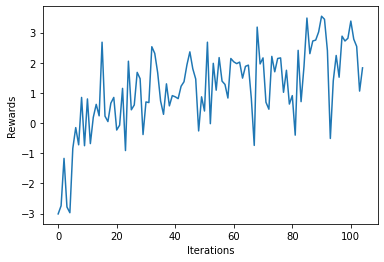

 11%|███████▋                                                                 | 10605/100000 [06:24<1:01:57, 24.05it/s]

Updated Weights
Mean Reward = 2.92
6


 11%|████████                                                                   | 10703/100000 [06:28<58:08, 25.60it/s]

Updated Weights
Mean Reward = 3.13
5


 11%|███████▉                                                                 | 10805/100000 [06:32<1:00:57, 24.39it/s]

Updated Weights
Mean Reward = 2.48
3


 11%|████████▏                                                                  | 10906/100000 [06:36<57:51, 25.66it/s]

Updated Weights
Mean Reward = -1.05
7


 11%|████████▏                                                                  | 10998/100000 [06:40<58:33, 25.33it/s]

Updated Weights
Mean Reward = 3.14
10


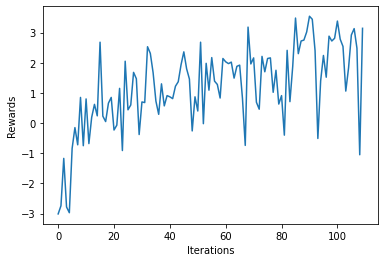

 11%|████████▎                                                                  | 11106/100000 [06:44<58:32, 25.31it/s]

Updated Weights
Mean Reward = 2.58
3


 11%|████████▍                                                                  | 11205/100000 [06:48<56:09, 26.35it/s]

Updated Weights
Mean Reward = 3.19
9


 11%|████████▍                                                                  | 11304/100000 [06:51<56:25, 26.20it/s]

Updated Weights
Mean Reward = 2.68
4


 11%|████████▌                                                                  | 11404/100000 [06:55<57:44, 25.57it/s]

Updated Weights
Mean Reward = 2.63
4


 11%|████████▌                                                                  | 11499/100000 [06:59<56:05, 26.30it/s]

Updated Weights
Mean Reward = 2.34
9


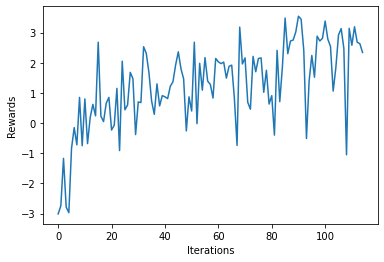

 12%|████████▋                                                                  | 11606/100000 [07:03<53:12, 27.68it/s]

Updated Weights
Mean Reward = -0.02
9


 12%|████████▊                                                                  | 11704/100000 [07:06<54:37, 26.94it/s]

Updated Weights
Mean Reward = 2.43
3


 12%|████████▊                                                                  | 11804/100000 [07:10<55:01, 26.71it/s]

Updated Weights
Mean Reward = 2.54
5


 12%|████████▉                                                                  | 11906/100000 [07:14<54:47, 26.79it/s]

Updated Weights
Mean Reward = 2.86
7


 12%|████████▉                                                                  | 11998/100000 [07:17<52:26, 27.97it/s]

Updated Weights
Mean Reward = 2.27
12


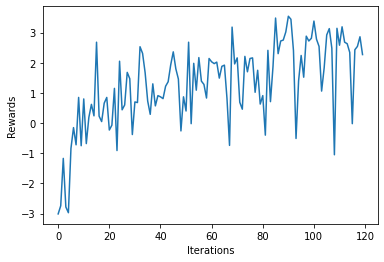

 12%|█████████                                                                  | 12105/100000 [07:21<56:40, 25.85it/s]

Updated Weights
Mean Reward = 2.21
3


 12%|█████████▏                                                                 | 12203/100000 [07:25<59:53, 24.43it/s]

Updated Weights
Mean Reward = 3.88
8


 12%|█████████▏                                                                 | 12304/100000 [07:29<56:52, 25.70it/s]

Updated Weights
Mean Reward = 2.97
7


 12%|█████████▎                                                                 | 12406/100000 [07:33<55:46, 26.18it/s]

Updated Weights
Mean Reward = 1.57
5


 12%|█████████▎                                                                 | 12498/100000 [07:36<52:41, 27.68it/s]

Updated Weights
Mean Reward = 0.18
4


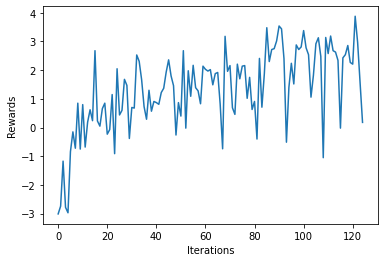

 13%|█████████▍                                                                 | 12604/100000 [07:41<55:36, 26.19it/s]

Updated Weights
Mean Reward = 4.05
7


 13%|█████████▌                                                                 | 12705/100000 [07:44<55:20, 26.29it/s]

Updated Weights
Mean Reward = 3.64
5


 13%|█████████▌                                                                 | 12806/100000 [07:48<56:22, 25.78it/s]

Updated Weights
Mean Reward = 3.2
6


 13%|█████████▋                                                                 | 12905/100000 [07:52<54:11, 26.79it/s]

Updated Weights
Mean Reward = 3.19
6


 13%|█████████▋                                                                 | 12998/100000 [07:55<54:19, 26.69it/s]

Updated Weights
Mean Reward = 3.17
8


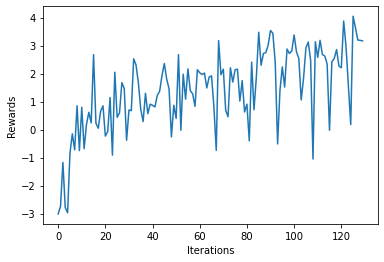

 13%|█████████▊                                                                 | 13105/100000 [07:59<55:18, 26.19it/s]

Updated Weights
Mean Reward = 1.63
5


 13%|█████████▉                                                                 | 13207/100000 [08:03<50:29, 28.65it/s]

Updated Weights
Mean Reward = 1.79
10


 13%|█████████▉                                                                 | 13306/100000 [08:07<58:00, 24.91it/s]

Updated Weights
Mean Reward = 1.09
4


 13%|██████████                                                                 | 13405/100000 [08:10<52:59, 27.23it/s]

Updated Weights
Mean Reward = 3.65
8


 14%|██████████▏                                                                | 13500/100000 [08:14<52:56, 27.23it/s]

Updated Weights
Mean Reward = 3.69
8


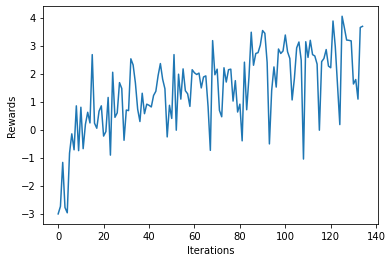

 14%|██████████▏                                                                | 13605/100000 [08:18<55:03, 26.15it/s]

Updated Weights
Mean Reward = 3.94
10


 14%|██████████▎                                                                | 13705/100000 [08:22<55:50, 25.75it/s]

Updated Weights
Mean Reward = 2.42
6


 14%|██████████▎                                                                | 13804/100000 [08:25<57:02, 25.18it/s]

Updated Weights
Mean Reward = 3.53
6


 14%|██████████▍                                                                | 13906/100000 [08:29<56:59, 25.18it/s]

Updated Weights
Mean Reward = 2.03
7


 14%|██████████▍                                                                | 13998/100000 [08:33<53:23, 26.84it/s]

Updated Weights
Mean Reward = 1.61
6


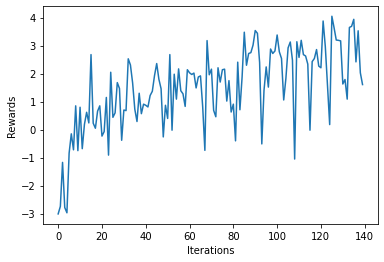

 14%|██████████▌                                                                | 14103/100000 [08:37<55:05, 25.98it/s]

Updated Weights
Mean Reward = 0.55
8


 14%|██████████▋                                                                | 14206/100000 [08:41<54:38, 26.17it/s]

Updated Weights
Mean Reward = 2.06
5


 14%|██████████▋                                                                | 14306/100000 [08:45<55:11, 25.87it/s]

Updated Weights
Mean Reward = 3.46
4


 14%|██████████▊                                                                | 14404/100000 [08:48<47:29, 30.04it/s]

Updated Weights
Mean Reward = 2.4
12


 14%|██████████▊                                                                | 14498/100000 [08:51<52:48, 26.99it/s]

Updated Weights
Mean Reward = 1.87
7


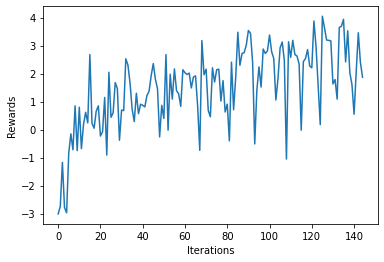

 15%|██████████▉                                                                | 14605/100000 [08:56<52:17, 27.21it/s]

Updated Weights
Mean Reward = 3.13
8


 15%|███████████                                                                | 14704/100000 [08:59<52:42, 26.97it/s]

Updated Weights
Mean Reward = 0.99
6


 15%|███████████                                                                | 14804/100000 [09:03<52:26, 27.07it/s]

Updated Weights
Mean Reward = 2.82
5


 15%|███████████▏                                                               | 14906/100000 [09:07<54:24, 26.06it/s]

Updated Weights
Mean Reward = 3.07
10


 15%|███████████▎                                                               | 15000/100000 [09:10<53:50, 26.32it/s]

Updated Weights
Mean Reward = 2.47
5


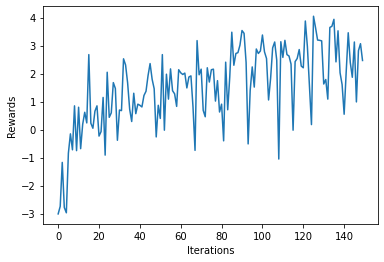

 15%|███████████▎                                                               | 15104/100000 [09:14<53:39, 26.37it/s]

Updated Weights
Mean Reward = 2.61
7


 15%|███████████▍                                                               | 15206/100000 [09:18<52:09, 27.09it/s]

Updated Weights
Mean Reward = 3.05
9


 15%|███████████▍                                                               | 15305/100000 [09:22<52:43, 26.77it/s]

Updated Weights
Mean Reward = 2.02
7


 15%|███████████▌                                                               | 15407/100000 [09:25<51:53, 27.17it/s]

Updated Weights
Mean Reward = 2.38
5


 15%|███████████▌                                                               | 15498/100000 [09:29<52:27, 26.85it/s]

Updated Weights
Mean Reward = 3.04
7


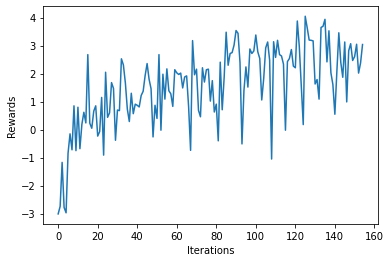

 16%|███████████▋                                                               | 15606/100000 [09:33<54:24, 25.86it/s]

Updated Weights
Mean Reward = 3.52
7


 16%|███████████▊                                                               | 15705/100000 [09:36<52:22, 26.83it/s]

Updated Weights
Mean Reward = 2.84
9


 16%|███████████▊                                                               | 15805/100000 [09:40<52:53, 26.53it/s]

Updated Weights
Mean Reward = 2.22
5


 16%|███████████▉                                                               | 15904/100000 [09:44<52:32, 26.67it/s]

Updated Weights
Mean Reward = 2.15
5


 16%|████████████                                                               | 16000/100000 [09:47<51:15, 27.31it/s]

Updated Weights
Mean Reward = 2.12
6


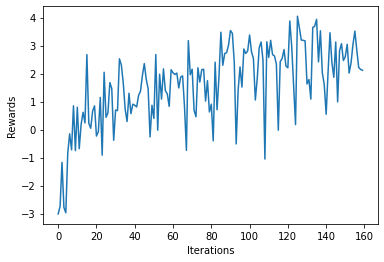

 16%|████████████                                                               | 16105/100000 [09:52<54:25, 25.69it/s]

Updated Weights
Mean Reward = 1.84
3


 16%|████████████▏                                                              | 16204/100000 [09:55<51:13, 27.26it/s]

Updated Weights
Mean Reward = 0.57
4


 16%|████████████▏                                                              | 16303/100000 [09:59<53:23, 26.13it/s]

Updated Weights
Mean Reward = 0.66
7


 16%|████████████▎                                                              | 16405/100000 [10:03<48:13, 28.89it/s]

Updated Weights
Mean Reward = 3.06
10


 16%|████████████▍                                                              | 16500/100000 [10:06<52:22, 26.57it/s]

Updated Weights
Mean Reward = 2.75
5


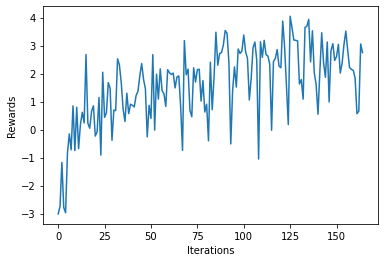

 17%|████████████▍                                                              | 16606/100000 [10:10<51:02, 27.23it/s]

Updated Weights
Mean Reward = 3.2
6


 17%|████████████▌                                                              | 16706/100000 [10:14<49:49, 27.86it/s]

Updated Weights
Mean Reward = 2.57
13


 17%|████████████▌                                                              | 16804/100000 [10:18<54:59, 25.22it/s]

Updated Weights
Mean Reward = 3.84
8


 17%|████████████▋                                                              | 16906/100000 [10:21<52:26, 26.41it/s]

Updated Weights
Mean Reward = 3.23
7


 17%|████████████▋                                                              | 16999/100000 [10:25<51:58, 26.61it/s]

Updated Weights
Mean Reward = 2.94
7


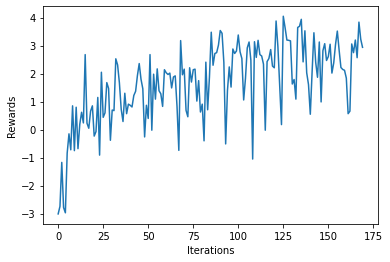

 17%|████████████▊                                                              | 17104/100000 [10:29<53:22, 25.89it/s]

Updated Weights
Mean Reward = 3.16
4


 17%|████████████▉                                                              | 17206/100000 [10:33<51:40, 26.71it/s]

Updated Weights
Mean Reward = 3.72
9


 17%|████████████▉                                                              | 17303/100000 [10:36<52:09, 26.43it/s]

Updated Weights
Mean Reward = 3.51
11


 17%|█████████████                                                              | 17404/100000 [10:41<52:54, 26.02it/s]

Updated Weights
Mean Reward = 2.58
6


 18%|█████████████▏                                                             | 17500/100000 [10:44<55:14, 24.89it/s]

Updated Weights
Mean Reward = 3.64
7


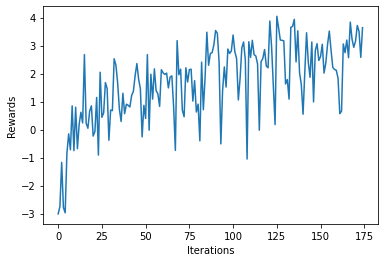

 18%|█████████████▏                                                             | 17605/100000 [10:48<53:43, 25.56it/s]

Updated Weights
Mean Reward = 3.12
7


 18%|█████████████▎                                                             | 17706/100000 [10:52<53:10, 25.80it/s]

Updated Weights
Mean Reward = 3.56
6


 18%|█████████████▎                                                             | 17805/100000 [10:56<51:24, 26.65it/s]

Updated Weights
Mean Reward = 3.46
7


 18%|█████████████▍                                                             | 17904/100000 [10:59<51:27, 26.59it/s]

Updated Weights
Mean Reward = 1.53
5


 18%|█████████████▍                                                             | 17999/100000 [11:03<51:51, 26.35it/s]

Updated Weights
Mean Reward = 2.36
11


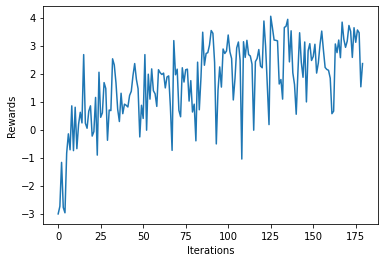

 18%|█████████████▌                                                             | 18105/100000 [11:07<52:58, 25.77it/s]

Updated Weights
Mean Reward = 2.83
7


 18%|█████████████▋                                                             | 18205/100000 [11:11<48:19, 28.21it/s]

Updated Weights
Mean Reward = 2.35
13


 18%|█████████████▋                                                             | 18304/100000 [11:14<51:46, 26.30it/s]

Updated Weights
Mean Reward = 1.32
7


 18%|█████████████▊                                                             | 18405/100000 [11:18<52:06, 26.10it/s]

Updated Weights
Mean Reward = 0.73
9


 18%|█████████████▊                                                             | 18497/100000 [11:22<52:58, 25.64it/s]

Updated Weights
Mean Reward = 1.99
3


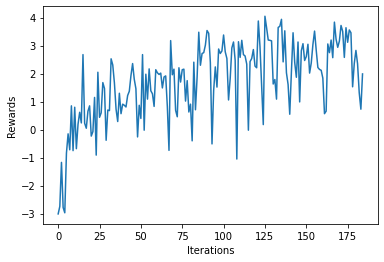

 19%|█████████████▉                                                             | 18604/100000 [11:26<53:16, 25.46it/s]

Updated Weights
Mean Reward = 3.51
8


 19%|██████████████                                                             | 18707/100000 [11:29<43:24, 31.22it/s]

Updated Weights
Mean Reward = 2.07
7


 19%|██████████████                                                             | 18805/100000 [11:33<48:36, 27.84it/s]

Updated Weights
Mean Reward = 2.3
11


 19%|██████████████▏                                                            | 18905/100000 [11:37<52:19, 25.83it/s]

Updated Weights
Mean Reward = 2.21
2


 19%|██████████████▎                                                            | 19000/100000 [11:40<46:52, 28.80it/s]

Updated Weights
Mean Reward = 3.38
9


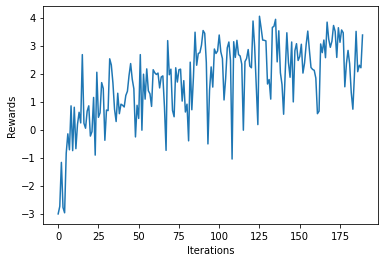

 19%|██████████████▎                                                            | 19105/100000 [11:44<52:36, 25.63it/s]

Updated Weights
Mean Reward = 4.1
11


 19%|██████████████▍                                                            | 19206/100000 [11:48<52:03, 25.87it/s]

Updated Weights
Mean Reward = 3.58
8


 19%|██████████████▍                                                            | 19304/100000 [11:52<47:25, 28.36it/s]

Updated Weights
Mean Reward = 3.74
8


 19%|██████████████▌                                                            | 19405/100000 [11:55<50:30, 26.59it/s]

Updated Weights
Mean Reward = 3.11
5


 20%|██████████████▋                                                            | 19500/100000 [11:59<47:49, 28.05it/s]

Updated Weights
Mean Reward = 3.04
5


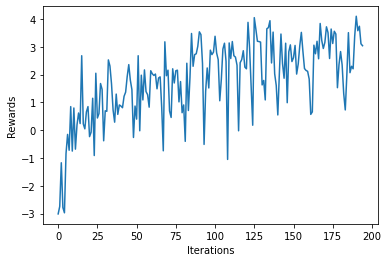

 20%|██████████████▋                                                            | 19604/100000 [12:03<52:01, 25.76it/s]

Updated Weights
Mean Reward = 2.26
4


 20%|██████████████▊                                                            | 19704/100000 [12:07<51:49, 25.82it/s]

Updated Weights
Mean Reward = 2.99
5


 20%|██████████████▊                                                            | 19804/100000 [12:10<51:24, 26.00it/s]

Updated Weights
Mean Reward = 4.03
9


 20%|██████████████▉                                                            | 19904/100000 [12:14<49:35, 26.92it/s]

Updated Weights
Mean Reward = 2.04
8


 20%|██████████████▉                                                            | 19999/100000 [12:18<50:20, 26.49it/s]

Updated Weights
Mean Reward = 2.82
10


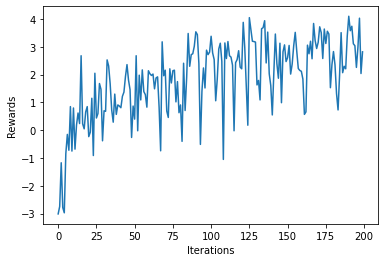

 20%|███████████████                                                            | 20103/100000 [12:22<44:16, 30.07it/s]

Updated Weights
Mean Reward = 4.04
5


 20%|███████████████▏                                                           | 20204/100000 [12:26<51:53, 25.63it/s]

Updated Weights
Mean Reward = 2.78
4


 20%|███████████████▏                                                           | 20305/100000 [12:29<51:33, 25.76it/s]

Updated Weights
Mean Reward = 2.03
7


 20%|███████████████▎                                                           | 20406/100000 [12:33<52:02, 25.49it/s]

Updated Weights
Mean Reward = 2.91
5


 20%|███████████████▎                                                           | 20499/100000 [12:37<52:26, 25.26it/s]

Updated Weights
Mean Reward = 3.47
4


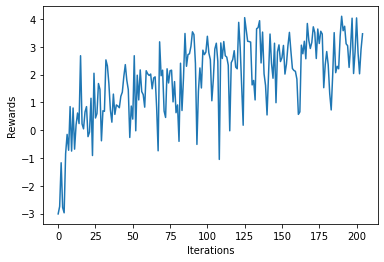

 21%|███████████████▍                                                           | 20604/100000 [12:41<47:27, 27.89it/s]

Updated Weights
Mean Reward = 2.82
3


 21%|███████████████▌                                                           | 20704/100000 [12:45<47:48, 27.65it/s]

Updated Weights
Mean Reward = 2.91
8


 21%|███████████████▌                                                           | 20804/100000 [12:48<51:37, 25.57it/s]

Updated Weights
Mean Reward = 3.09
4


 21%|███████████████▋                                                           | 20904/100000 [12:52<50:02, 26.35it/s]

Updated Weights
Mean Reward = 2.4
10


 21%|███████████████▊                                                           | 21000/100000 [12:56<46:50, 28.11it/s]

Updated Weights
Mean Reward = 3.32
5


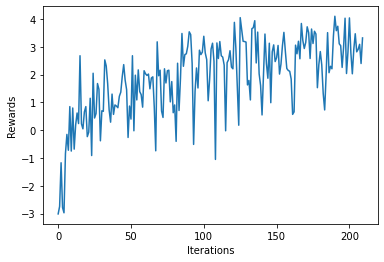

 21%|███████████████▊                                                           | 21104/100000 [13:00<49:48, 26.40it/s]

Updated Weights
Mean Reward = 3.32
9


 21%|███████████████▉                                                           | 21205/100000 [13:03<50:12, 26.15it/s]

Updated Weights
Mean Reward = 0.33
4


 21%|███████████████▉                                                           | 21304/100000 [13:07<51:08, 25.65it/s]

Updated Weights
Mean Reward = 3.43
7


 21%|████████████████                                                           | 21404/100000 [13:11<48:34, 26.97it/s]

Updated Weights
Mean Reward = 3.39
5


 21%|████████████████                                                           | 21499/100000 [13:14<47:48, 27.36it/s]

Updated Weights
Mean Reward = 3.0
5


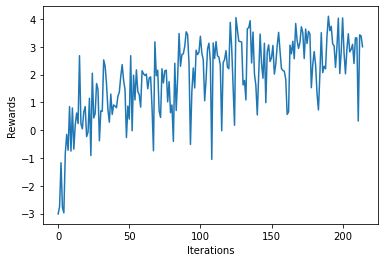

 22%|████████████████▏                                                          | 21604/100000 [13:18<48:40, 26.85it/s]

Updated Weights
Mean Reward = 3.57
5


 22%|████████████████▎                                                          | 21706/100000 [13:22<45:36, 28.61it/s]

Updated Weights
Mean Reward = 3.17
6


 22%|████████████████▎                                                          | 21806/100000 [13:26<51:57, 25.08it/s]

Updated Weights
Mean Reward = 3.58
8


 22%|████████████████▍                                                          | 21904/100000 [13:29<46:16, 28.12it/s]

Updated Weights
Mean Reward = 3.22
8


 22%|████████████████▍                                                          | 21999/100000 [13:33<50:22, 25.81it/s]

Updated Weights
Mean Reward = 1.97
5


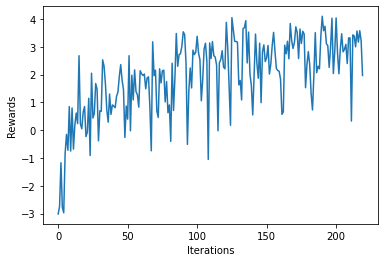

 22%|████████████████▌                                                          | 22105/100000 [13:37<50:55, 25.50it/s]

Updated Weights
Mean Reward = 3.71
6


 22%|████████████████▋                                                          | 22205/100000 [13:41<43:34, 29.75it/s]

Updated Weights
Mean Reward = 4.72
16


 22%|████████████████▋                                                          | 22306/100000 [13:44<49:08, 26.35it/s]

Updated Weights
Mean Reward = 4.4
12


 22%|████████████████▊                                                          | 22404/100000 [13:48<46:32, 27.79it/s]

Updated Weights
Mean Reward = 2.6
10


 22%|████████████████▉                                                          | 22500/100000 [13:51<45:37, 28.31it/s]

Updated Weights
Mean Reward = 3.82
10


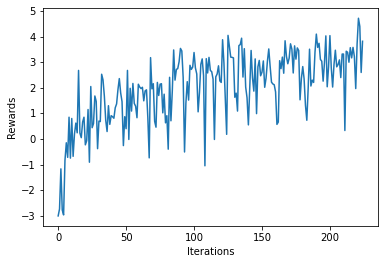

 23%|████████████████▉                                                          | 22604/100000 [13:56<55:27, 23.26it/s]

Updated Weights
Mean Reward = 3.82
8


 23%|█████████████████                                                          | 22706/100000 [13:59<48:24, 26.62it/s]

Updated Weights
Mean Reward = 4.96
17


 23%|█████████████████                                                          | 22805/100000 [14:03<52:34, 24.47it/s]

Updated Weights
Mean Reward = 3.7
13


 23%|█████████████████▏                                                         | 22904/100000 [14:07<48:27, 26.52it/s]

Updated Weights
Mean Reward = 3.9
13


 23%|█████████████████▏                                                         | 22998/100000 [14:10<52:21, 24.51it/s]

Updated Weights
Mean Reward = 4.35
11


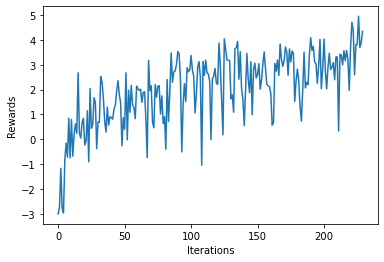

 23%|█████████████████▎                                                         | 23105/100000 [14:15<47:37, 26.91it/s]

Updated Weights
Mean Reward = 4.0
8


 23%|█████████████████▍                                                         | 23205/100000 [14:18<46:40, 27.42it/s]

Updated Weights
Mean Reward = 2.54
5


 23%|█████████████████▍                                                         | 23304/100000 [14:22<48:33, 26.33it/s]

Updated Weights
Mean Reward = 2.37
8


 23%|█████████████████▌                                                         | 23405/100000 [14:26<49:09, 25.97it/s]

Updated Weights
Mean Reward = 1.86
4


 23%|█████████████████▌                                                         | 23497/100000 [14:29<47:49, 26.66it/s]

Updated Weights
Mean Reward = 3.09
6


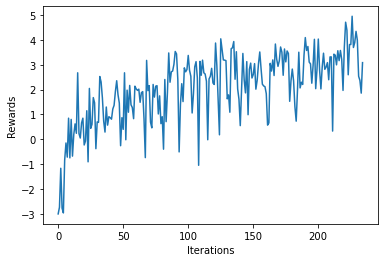

 24%|█████████████████▋                                                         | 23604/100000 [14:33<47:20, 26.90it/s]

Updated Weights
Mean Reward = 4.2
8


 24%|█████████████████▊                                                         | 23704/100000 [14:37<51:07, 24.87it/s]

Updated Weights
Mean Reward = 3.13
6


 24%|█████████████████▊                                                         | 23804/100000 [14:41<46:39, 27.22it/s]

Updated Weights
Mean Reward = 2.64
5


 24%|█████████████████▉                                                         | 23905/100000 [14:45<47:56, 26.46it/s]

Updated Weights
Mean Reward = 2.73
4


 24%|█████████████████▉                                                         | 23999/100000 [14:48<44:33, 28.43it/s]

Updated Weights
Mean Reward = 3.34
6


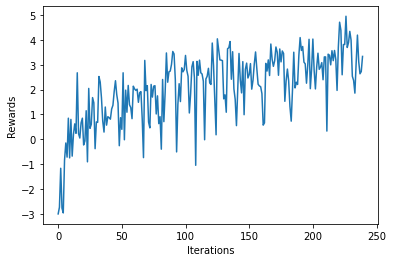

 24%|██████████████████                                                         | 24107/100000 [14:52<46:05, 27.44it/s]

Updated Weights
Mean Reward = 1.57
3


 24%|██████████████████▏                                                        | 24205/100000 [14:56<47:03, 26.84it/s]

Updated Weights
Mean Reward = 4.39
11


 24%|██████████████████▏                                                        | 24305/100000 [15:00<44:48, 28.16it/s]

Updated Weights
Mean Reward = 3.43
7


 24%|██████████████████▎                                                        | 24404/100000 [15:03<46:11, 27.28it/s]

Updated Weights
Mean Reward = 3.96
6


 24%|██████████████████▎                                                        | 24498/100000 [15:07<48:02, 26.19it/s]

Updated Weights
Mean Reward = 3.31
7


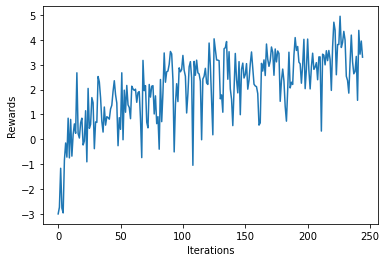

 25%|██████████████████▍                                                        | 24604/100000 [15:11<48:09, 26.10it/s]

Updated Weights
Mean Reward = 3.7
3


 25%|██████████████████▌                                                        | 24704/100000 [15:15<44:02, 28.50it/s]

Updated Weights
Mean Reward = 3.26
9


 25%|██████████████████▌                                                        | 24805/100000 [15:19<47:15, 26.52it/s]

Updated Weights
Mean Reward = 4.0
8


 25%|██████████████████▋                                                        | 24905/100000 [15:22<46:04, 27.17it/s]

Updated Weights
Mean Reward = 3.3
6


 25%|██████████████████▊                                                        | 25000/100000 [15:26<48:17, 25.88it/s]

Updated Weights
Mean Reward = 4.35
4


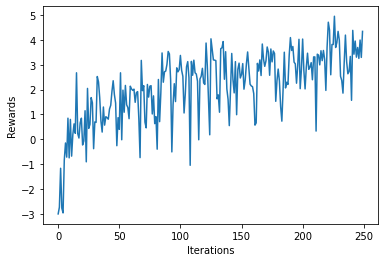

 25%|██████████████████▊                                                        | 25103/100000 [15:30<45:41, 27.32it/s]

Updated Weights
Mean Reward = 4.03
7


 25%|██████████████████▉                                                        | 25204/100000 [15:34<45:07, 27.63it/s]

Updated Weights
Mean Reward = 4.11
11


 25%|██████████████████▉                                                        | 25304/100000 [15:37<47:18, 26.32it/s]

Updated Weights
Mean Reward = 2.83
9


 25%|███████████████████                                                        | 25404/100000 [15:41<47:46, 26.03it/s]

Updated Weights
Mean Reward = 0.6
9


 25%|███████████████████                                                        | 25499/100000 [15:44<48:02, 25.85it/s]

Updated Weights
Mean Reward = 4.09
8


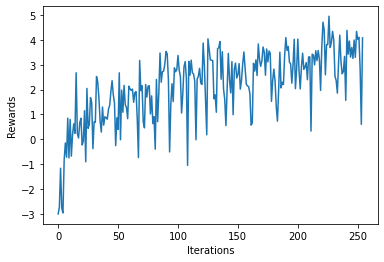

 26%|███████████████████▏                                                       | 25606/100000 [15:48<47:32, 26.08it/s]

Updated Weights
Mean Reward = 3.89
7


 26%|███████████████████▎                                                       | 25705/100000 [15:52<48:12, 25.68it/s]

Updated Weights
Mean Reward = 4.53
10


 26%|███████████████████▎                                                       | 25806/100000 [15:56<43:44, 28.27it/s]

Updated Weights
Mean Reward = 3.98
7


 26%|███████████████████▍                                                       | 25905/100000 [16:00<47:40, 25.90it/s]

Updated Weights
Mean Reward = 3.67
4


 26%|███████████████████▍                                                       | 25998/100000 [16:03<46:09, 26.72it/s]

Updated Weights
Mean Reward = 3.28
6


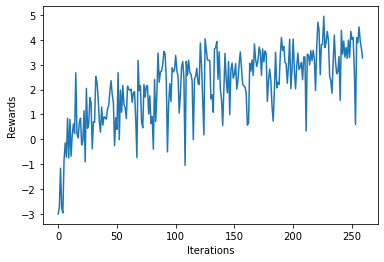

 26%|███████████████████▌                                                       | 26106/100000 [16:07<46:02, 26.75it/s]

Updated Weights
Mean Reward = 2.89
5


 26%|███████████████████▋                                                       | 26204/100000 [16:11<45:35, 26.98it/s]

Updated Weights
Mean Reward = 4.2
13


 26%|███████████████████▋                                                       | 26306/100000 [16:14<46:06, 26.63it/s]

Updated Weights
Mean Reward = 3.28
7


 26%|███████████████████▊                                                       | 26404/100000 [16:18<45:06, 27.19it/s]

Updated Weights
Mean Reward = 3.69
7


 26%|███████████████████▊                                                       | 26499/100000 [16:21<46:49, 26.17it/s]

Updated Weights
Mean Reward = 3.95
8


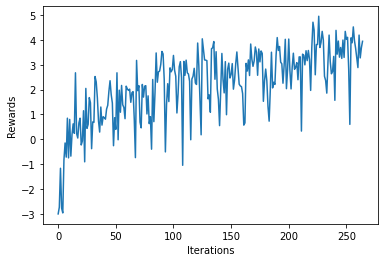

 27%|███████████████████▉                                                       | 26604/100000 [16:26<48:49, 25.06it/s]

Updated Weights
Mean Reward = 2.19
6


 27%|████████████████████                                                       | 26706/100000 [16:29<42:30, 28.73it/s]

Updated Weights
Mean Reward = 4.4
9


 27%|████████████████████                                                       | 26804/100000 [16:33<45:06, 27.05it/s]

Updated Weights
Mean Reward = 4.16
4


 27%|████████████████████▏                                                      | 26904/100000 [16:37<44:53, 27.14it/s]

Updated Weights
Mean Reward = 4.07
7


 27%|████████████████████▏                                                      | 26999/100000 [16:40<41:10, 29.55it/s]

Updated Weights
Mean Reward = 4.75
6


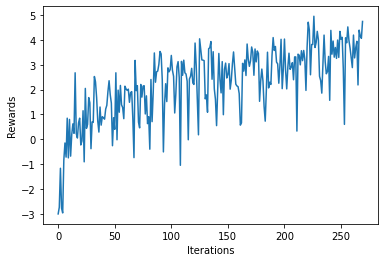

 27%|████████████████████▎                                                      | 27105/100000 [16:44<44:51, 27.09it/s]

Updated Weights
Mean Reward = 4.09
8


 27%|████████████████████▍                                                      | 27206/100000 [16:48<45:37, 26.59it/s]

Updated Weights
Mean Reward = 3.42
7


 27%|████████████████████▍                                                      | 27305/100000 [16:52<46:44, 25.92it/s]

Updated Weights
Mean Reward = 3.24
5


 27%|████████████████████▌                                                      | 27404/100000 [16:56<47:02, 25.72it/s]

Updated Weights
Mean Reward = 2.21
5


 28%|████████████████████▋                                                      | 27500/100000 [16:59<46:14, 26.13it/s]

Updated Weights
Mean Reward = 1.69
4


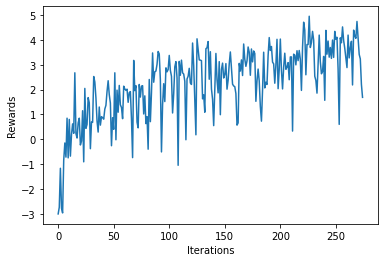

 28%|████████████████████▋                                                      | 27606/100000 [17:03<45:45, 26.37it/s]

Updated Weights
Mean Reward = 2.45
5


 28%|████████████████████▊                                                      | 27704/100000 [17:07<44:01, 27.37it/s]

Updated Weights
Mean Reward = 3.88
10


 28%|████████████████████▊                                                      | 27806/100000 [17:11<44:10, 27.24it/s]

Updated Weights
Mean Reward = 2.99
8


 28%|████████████████████▉                                                      | 27904/100000 [17:14<44:34, 26.95it/s]

Updated Weights
Mean Reward = 3.99
8


 28%|█████████████████████                                                      | 28000/100000 [17:18<43:59, 27.28it/s]

Updated Weights
Mean Reward = 2.41
5


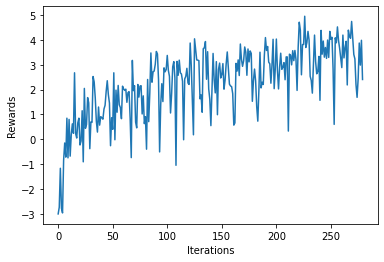

 28%|█████████████████████                                                      | 28106/100000 [17:22<45:56, 26.09it/s]

Updated Weights
Mean Reward = 3.29
7


 28%|█████████████████████▏                                                     | 28204/100000 [17:26<44:50, 26.69it/s]

Updated Weights
Mean Reward = 4.04
11


 28%|█████████████████████▏                                                     | 28305/100000 [17:29<43:52, 27.23it/s]

Updated Weights
Mean Reward = 4.04
8


 28%|█████████████████████▎                                                     | 28407/100000 [17:33<37:13, 32.05it/s]

Updated Weights
Mean Reward = 3.68
9


 28%|█████████████████████▎                                                     | 28500/100000 [17:36<44:35, 26.72it/s]

Updated Weights
Mean Reward = 4.58
10


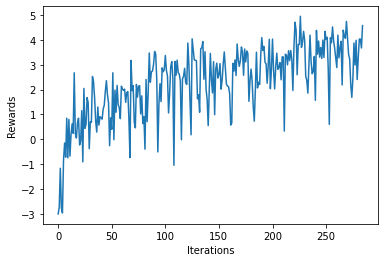

 29%|█████████████████████▍                                                     | 28606/100000 [17:41<43:38, 27.26it/s]

Updated Weights
Mean Reward = 3.47
5


 29%|█████████████████████▌                                                     | 28704/100000 [17:44<41:12, 28.83it/s]

Updated Weights
Mean Reward = 3.2
11


 29%|█████████████████████▌                                                     | 28804/100000 [17:48<43:45, 27.12it/s]

Updated Weights
Mean Reward = 2.49
3


 29%|█████████████████████▋                                                     | 28906/100000 [17:52<42:54, 27.61it/s]

Updated Weights
Mean Reward = 5.59
16


 29%|█████████████████████▊                                                     | 29000/100000 [17:55<43:46, 27.03it/s]

Updated Weights
Mean Reward = 4.38
13


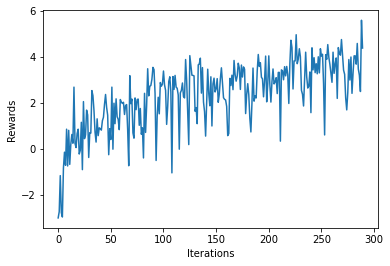

 29%|█████████████████████▊                                                     | 29106/100000 [17:59<43:46, 26.99it/s]

Updated Weights
Mean Reward = 4.0
6


 29%|█████████████████████▉                                                     | 29205/100000 [18:03<45:02, 26.20it/s]

Updated Weights
Mean Reward = 2.76
4


 29%|█████████████████████▉                                                     | 29304/100000 [18:06<44:09, 26.68it/s]

Updated Weights
Mean Reward = 3.83
8


 29%|██████████████████████                                                     | 29404/100000 [18:10<44:55, 26.19it/s]

Updated Weights
Mean Reward = 4.21
9


 29%|██████████████████████                                                     | 29498/100000 [18:14<43:38, 26.93it/s]

Updated Weights
Mean Reward = 3.96
10


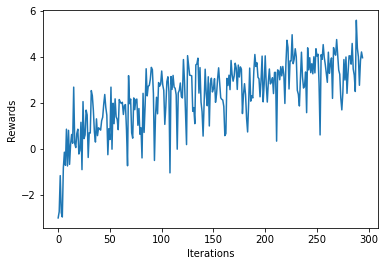

 30%|██████████████████████▏                                                    | 29604/100000 [18:18<45:29, 25.79it/s]

Updated Weights
Mean Reward = 4.36
6


 30%|██████████████████████▎                                                    | 29705/100000 [18:21<42:26, 27.60it/s]

Updated Weights
Mean Reward = 4.33
9


 30%|██████████████████████▎                                                    | 29805/100000 [18:25<44:34, 26.25it/s]

Updated Weights
Mean Reward = 4.08
10


 30%|██████████████████████▍                                                    | 29905/100000 [18:29<44:03, 26.52it/s]

Updated Weights
Mean Reward = 3.85
9


 30%|██████████████████████▌                                                    | 30000/100000 [18:32<44:57, 25.95it/s]

Updated Weights
Mean Reward = 3.02
10


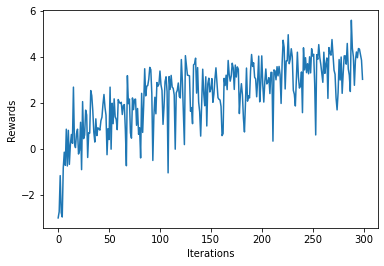

 30%|██████████████████████▌                                                    | 30107/100000 [18:36<39:54, 29.19it/s]

Updated Weights
Mean Reward = 4.12
8


 30%|██████████████████████▋                                                    | 30205/100000 [18:41<55:47, 20.85it/s]

Updated Weights
Mean Reward = 3.66
7


 30%|██████████████████████▋                                                    | 30305/100000 [18:45<45:45, 25.38it/s]

Updated Weights
Mean Reward = 4.55
13


 30%|██████████████████████▊                                                    | 30404/100000 [18:49<50:55, 22.78it/s]

Updated Weights
Mean Reward = 3.21
6


 30%|██████████████████████▊                                                    | 30498/100000 [18:53<49:40, 23.32it/s]

Updated Weights
Mean Reward = 3.62
8


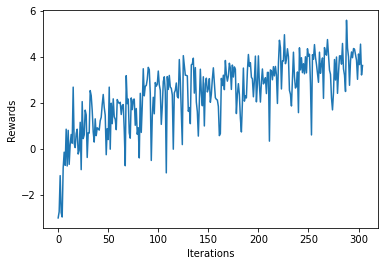

 31%|██████████████████████▉                                                    | 30604/100000 [18:58<53:04, 21.79it/s]

Updated Weights
Mean Reward = 0.66
8


 31%|███████████████████████                                                    | 30705/100000 [19:03<47:09, 24.49it/s]

Updated Weights
Mean Reward = 4.66
9


 31%|███████████████████████                                                    | 30806/100000 [19:07<39:44, 29.01it/s]

Updated Weights
Mean Reward = 4.8
12


 31%|███████████████████████▏                                                   | 30906/100000 [19:10<44:10, 26.07it/s]

Updated Weights
Mean Reward = 4.79
14


 31%|███████████████████████▏                                                   | 30998/100000 [19:14<41:52, 27.46it/s]

Updated Weights
Mean Reward = 4.32
11


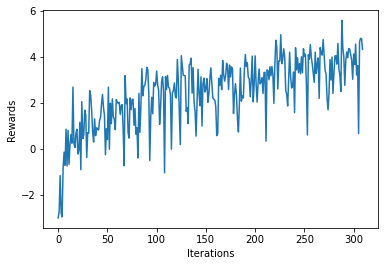

 31%|███████████████████████▎                                                   | 31105/100000 [19:18<54:08, 21.21it/s]

Updated Weights
Mean Reward = 3.78
10


 31%|███████████████████████▍                                                   | 31204/100000 [19:22<48:53, 23.45it/s]

Updated Weights
Mean Reward = 0.85
4


 31%|███████████████████████▍                                                   | 31306/100000 [19:26<41:46, 27.41it/s]

Updated Weights
Mean Reward = 3.03
7


 31%|███████████████████████▌                                                   | 31404/100000 [19:30<43:57, 26.00it/s]

Updated Weights
Mean Reward = 3.84
8


 32%|███████████████████████▋                                                   | 31500/100000 [19:33<41:20, 27.61it/s]

Updated Weights
Mean Reward = 4.05
10


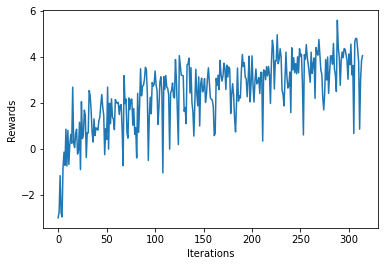

 32%|███████████████████████▋                                                   | 31603/100000 [19:37<40:52, 27.89it/s]

Updated Weights
Mean Reward = 4.45
9


 32%|███████████████████████▊                                                   | 31705/100000 [19:41<42:59, 26.48it/s]

Updated Weights
Mean Reward = 3.87
7


 32%|███████████████████████▊                                                   | 31805/100000 [19:44<41:09, 27.61it/s]

Updated Weights
Mean Reward = 1.75
11


 32%|███████████████████████▉                                                   | 31906/100000 [19:48<42:06, 26.96it/s]

Updated Weights
Mean Reward = 4.28
10


 32%|███████████████████████▉                                                   | 31998/100000 [19:52<40:06, 28.26it/s]

Updated Weights
Mean Reward = 3.51
8


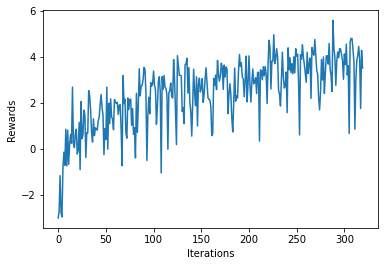

 32%|████████████████████████                                                   | 32105/100000 [19:56<42:34, 26.58it/s]

Updated Weights
Mean Reward = 3.61
9


 32%|████████████████████████▏                                                  | 32205/100000 [20:00<50:25, 22.41it/s]

Updated Weights
Mean Reward = 2.76
4


 32%|████████████████████████▏                                                  | 32306/100000 [20:04<43:54, 25.70it/s]

Updated Weights
Mean Reward = 2.41
7


 32%|████████████████████████▎                                                  | 32405/100000 [20:08<43:11, 26.09it/s]

Updated Weights
Mean Reward = 2.88
5


 32%|████████████████████████▎                                                  | 32499/100000 [20:11<46:22, 24.26it/s]

Updated Weights
Mean Reward = 2.99
6


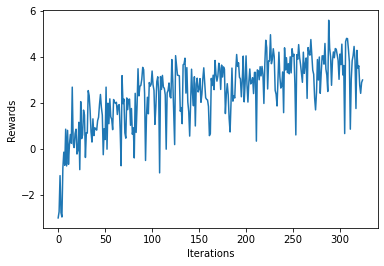

 33%|████████████████████████▍                                                  | 32606/100000 [20:16<44:17, 25.36it/s]

Updated Weights
Mean Reward = 3.72
5


 33%|████████████████████████▌                                                  | 32707/100000 [20:19<40:30, 27.69it/s]

Updated Weights
Mean Reward = 3.3
5


 33%|████████████████████████▌                                                  | 32806/100000 [20:23<43:33, 25.71it/s]

Updated Weights
Mean Reward = 4.75
8


 33%|████████████████████████▋                                                  | 32903/100000 [20:27<47:25, 23.58it/s]

Updated Weights
Mean Reward = 3.92
5


 33%|████████████████████████▊                                                  | 33000/100000 [20:31<44:28, 25.11it/s]

Updated Weights
Mean Reward = 3.8
7


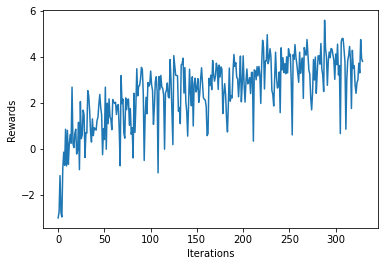

 33%|████████████████████████▊                                                  | 33105/100000 [20:35<41:21, 26.95it/s]

Updated Weights
Mean Reward = 3.76
5


 33%|████████████████████████▉                                                  | 33207/100000 [20:39<38:23, 28.99it/s]

Updated Weights
Mean Reward = 3.73
9


 33%|████████████████████████▉                                                  | 33303/100000 [20:42<39:51, 27.88it/s]

Updated Weights
Mean Reward = 4.36
9


 33%|█████████████████████████                                                  | 33404/100000 [20:46<49:12, 22.55it/s]

Updated Weights
Mean Reward = 4.65
12


 33%|█████████████████████████                                                  | 33498/100000 [20:49<38:49, 28.54it/s]

Updated Weights
Mean Reward = 3.81
5


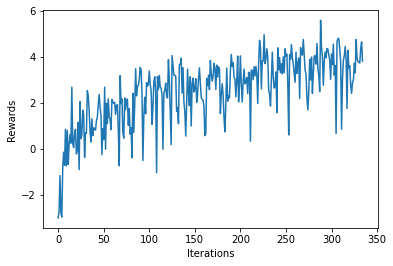

 34%|█████████████████████████▏                                                 | 33602/100000 [20:53<35:58, 30.75it/s]

Updated Weights
Mean Reward = 4.56
7


 34%|█████████████████████████▎                                                 | 33706/100000 [20:57<42:15, 26.15it/s]

Updated Weights
Mean Reward = 4.13
8


 34%|█████████████████████████▎                                                 | 33804/100000 [21:00<38:19, 28.79it/s]

Updated Weights
Mean Reward = 4.88
11


 34%|█████████████████████████▍                                                 | 33905/100000 [21:04<43:48, 25.15it/s]

Updated Weights
Mean Reward = 3.45
8


 34%|█████████████████████████▍                                                 | 33999/100000 [21:08<51:00, 21.56it/s]

Updated Weights
Mean Reward = 4.37
12


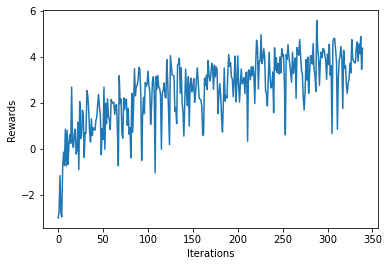

 34%|█████████████████████████▌                                                 | 34103/100000 [21:12<50:56, 21.56it/s]

Updated Weights
Mean Reward = 3.25
8


 34%|████████████████████████▉                                                | 34203/100000 [21:17<1:02:49, 17.45it/s]

Updated Weights
Mean Reward = 4.02
9


 34%|█████████████████████████▋                                                 | 34304/100000 [21:21<45:52, 23.87it/s]

Updated Weights
Mean Reward = 3.89
6


 34%|█████████████████████████▊                                                 | 34404/100000 [21:25<40:45, 26.82it/s]

Updated Weights
Mean Reward = 4.99
6


 34%|█████████████████████████▊                                                 | 34499/100000 [21:29<43:52, 24.88it/s]

Updated Weights
Mean Reward = 5.32
12


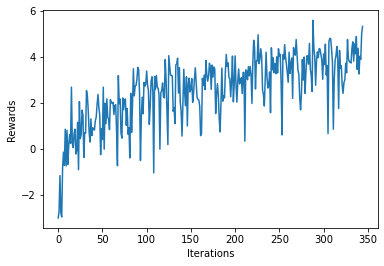

 35%|█████████████████████████▉                                                 | 34605/100000 [21:33<44:10, 24.67it/s]

Updated Weights
Mean Reward = 4.56
7


 35%|██████████████████████████                                                 | 34703/100000 [21:37<45:10, 24.09it/s]

Updated Weights
Mean Reward = 4.49
8


 35%|██████████████████████████                                                 | 34805/100000 [21:41<38:51, 27.96it/s]

Updated Weights
Mean Reward = 3.47
7


 35%|██████████████████████████▏                                                | 34904/100000 [21:46<59:11, 18.33it/s]

Updated Weights
Mean Reward = 4.11
8


 35%|██████████████████████████▏                                                | 34998/100000 [21:50<41:59, 25.80it/s]

Updated Weights
Mean Reward = 4.07
8


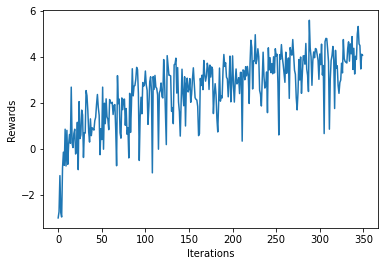

 35%|██████████████████████████▎                                                | 35105/100000 [21:54<42:20, 25.55it/s]

Updated Weights
Mean Reward = 4.28
9


 35%|██████████████████████████▍                                                | 35204/100000 [21:58<37:37, 28.70it/s]

Updated Weights
Mean Reward = 5.14
12


 35%|██████████████████████████▍                                                | 35304/100000 [22:02<40:22, 26.71it/s]

Updated Weights
Mean Reward = 2.62
10


 35%|██████████████████████████▌                                                | 35404/100000 [22:05<41:05, 26.20it/s]

Updated Weights
Mean Reward = 4.44
6


 35%|██████████████████████████▌                                                | 35498/100000 [22:09<40:40, 26.43it/s]

Updated Weights
Mean Reward = 4.67
10


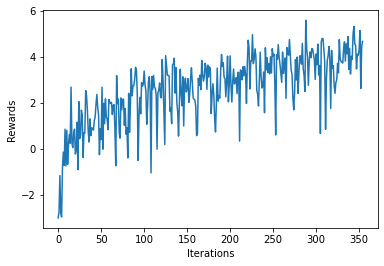

 36%|██████████████████████████▋                                                | 35606/100000 [22:13<39:42, 27.03it/s]

Updated Weights
Mean Reward = 3.32
5


 36%|██████████████████████████▊                                                | 35705/100000 [22:17<41:00, 26.13it/s]

Updated Weights
Mean Reward = 2.45
8


 36%|██████████████████████████▊                                                | 35804/100000 [22:20<41:00, 26.09it/s]

Updated Weights
Mean Reward = 3.76
8


 36%|██████████████████████████▉                                                | 35904/100000 [22:24<37:41, 28.34it/s]

Updated Weights
Mean Reward = 4.11
9


 36%|██████████████████████████▉                                                | 35999/100000 [22:28<43:04, 24.76it/s]

Updated Weights
Mean Reward = 4.1
7


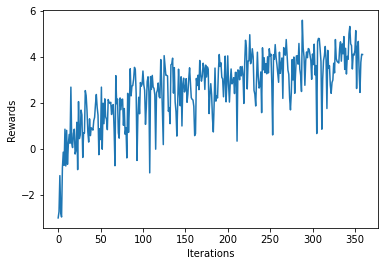

 36%|███████████████████████████                                                | 36106/100000 [22:32<39:47, 26.76it/s]

Updated Weights
Mean Reward = 3.03
7


 36%|███████████████████████████▏                                               | 36203/100000 [22:36<40:30, 26.25it/s]

Updated Weights
Mean Reward = 2.94
5


 36%|███████████████████████████▏                                               | 36304/100000 [22:40<41:46, 25.41it/s]

Updated Weights
Mean Reward = 3.19
2


 36%|███████████████████████████▎                                               | 36406/100000 [22:44<35:48, 29.61it/s]

Updated Weights
Mean Reward = 4.06
5


 36%|███████████████████████████▎                                               | 36498/100000 [22:47<37:45, 28.03it/s]

Updated Weights
Mean Reward = 4.81
11


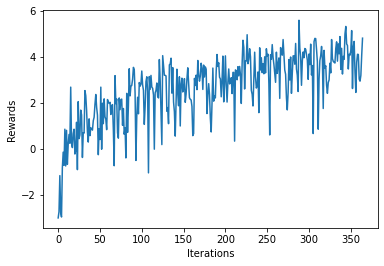

 37%|███████████████████████████▍                                               | 36606/100000 [22:51<37:03, 28.51it/s]

Updated Weights
Mean Reward = 4.76
9


 37%|███████████████████████████▌                                               | 36707/100000 [22:55<39:25, 26.75it/s]

Updated Weights
Mean Reward = 4.64
3


 37%|███████████████████████████▌                                               | 36805/100000 [22:59<39:11, 26.88it/s]

Updated Weights
Mean Reward = 4.09
8


 37%|███████████████████████████▋                                               | 36904/100000 [23:02<39:03, 26.92it/s]

Updated Weights
Mean Reward = 4.4
8


 37%|███████████████████████████▋                                               | 36999/100000 [23:06<34:46, 30.20it/s]

Updated Weights
Mean Reward = 4.12
9


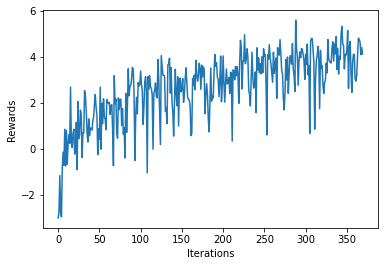

 37%|███████████████████████████▊                                               | 37105/100000 [23:10<41:02, 25.54it/s]

Updated Weights
Mean Reward = 3.31
3


 37%|███████████████████████████▉                                               | 37203/100000 [23:14<38:26, 27.22it/s]

Updated Weights
Mean Reward = 4.79
6


 37%|███████████████████████████▉                                               | 37305/100000 [23:17<35:55, 29.08it/s]

Updated Weights
Mean Reward = 4.85
8


 37%|████████████████████████████                                               | 37403/100000 [23:21<39:59, 26.09it/s]

Updated Weights
Mean Reward = 4.86
9


 37%|████████████████████████████                                               | 37498/100000 [23:25<38:15, 27.23it/s]

Updated Weights
Mean Reward = 3.06
8


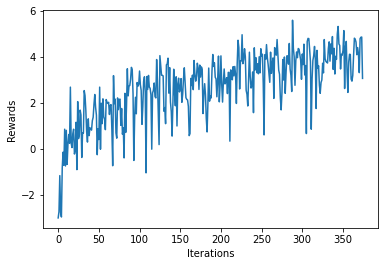

 38%|████████████████████████████▏                                              | 37605/100000 [23:29<42:50, 24.28it/s]

Updated Weights
Mean Reward = 3.12
9


 38%|████████████████████████████▎                                              | 37706/100000 [23:33<39:27, 26.31it/s]

Updated Weights
Mean Reward = 5.47
14


 38%|████████████████████████████▎                                              | 37806/100000 [23:37<38:47, 26.72it/s]

Updated Weights
Mean Reward = 4.9
8


 38%|████████████████████████████▍                                              | 37906/100000 [23:41<43:13, 23.94it/s]

Updated Weights
Mean Reward = 4.24
5


 38%|████████████████████████████▍                                              | 37998/100000 [23:44<37:36, 27.48it/s]

Updated Weights
Mean Reward = 4.79
7


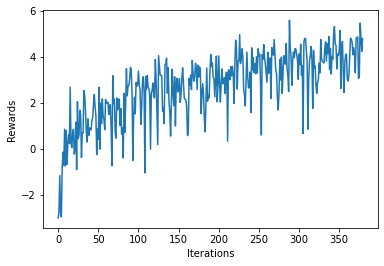

 38%|████████████████████████████▌                                              | 38106/100000 [23:49<37:16, 27.67it/s]

Updated Weights
Mean Reward = 3.84
5


 38%|████████████████████████████▋                                              | 38202/100000 [23:52<46:44, 22.04it/s]

Updated Weights
Mean Reward = 5.14
10


 38%|████████████████████████████▋                                              | 38306/100000 [23:56<34:29, 29.81it/s]

Updated Weights
Mean Reward = 5.18
10


 38%|████████████████████████████▊                                              | 38405/100000 [24:00<35:08, 29.21it/s]

Updated Weights
Mean Reward = 4.48
11


 38%|████████████████████████████▊                                              | 38498/100000 [24:03<39:39, 25.85it/s]

Updated Weights
Mean Reward = 4.82
10


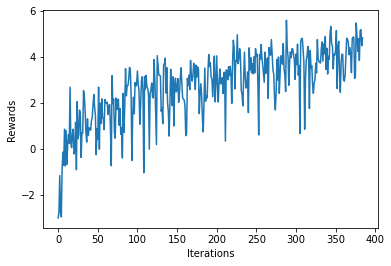

 39%|████████████████████████████▉                                              | 38604/100000 [24:08<39:32, 25.88it/s]

Updated Weights
Mean Reward = 4.45
2


 39%|█████████████████████████████                                              | 38704/100000 [24:11<34:52, 29.30it/s]

Updated Weights
Mean Reward = 5.55
11


 39%|█████████████████████████████                                              | 38803/100000 [24:15<38:42, 26.35it/s]

Updated Weights
Mean Reward = 4.2
6


 39%|█████████████████████████████▏                                             | 38905/100000 [24:19<35:59, 28.29it/s]

Updated Weights
Mean Reward = 4.43
6


 39%|█████████████████████████████▏                                             | 38998/100000 [24:23<39:04, 26.02it/s]

Updated Weights
Mean Reward = 4.31
6


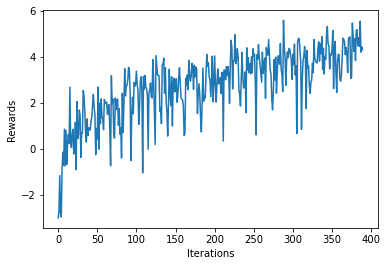

 39%|█████████████████████████████▎                                             | 39107/100000 [24:27<37:46, 26.87it/s]

Updated Weights
Mean Reward = 4.79
8


 39%|█████████████████████████████▍                                             | 39204/100000 [24:30<38:58, 26.00it/s]

Updated Weights
Mean Reward = 5.42
11


 39%|█████████████████████████████▍                                             | 39304/100000 [24:34<37:13, 27.17it/s]

Updated Weights
Mean Reward = 4.59
9


 39%|█████████████████████████████▌                                             | 39404/100000 [24:38<42:01, 24.03it/s]

Updated Weights
Mean Reward = 2.47
11


 39%|█████████████████████████████▌                                             | 39499/100000 [24:41<39:18, 25.65it/s]

Updated Weights
Mean Reward = 2.34
4


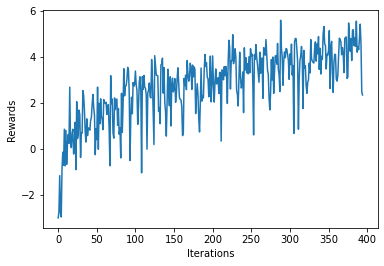

 40%|█████████████████████████████▋                                             | 39606/100000 [24:45<40:00, 25.15it/s]

Updated Weights
Mean Reward = 3.42
5


 40%|█████████████████████████████▊                                             | 39703/100000 [24:49<34:57, 28.75it/s]

Updated Weights
Mean Reward = 5.1
11


 40%|█████████████████████████████▊                                             | 39804/100000 [24:53<36:40, 27.36it/s]

Updated Weights
Mean Reward = 4.11
7


 40%|█████████████████████████████▉                                             | 39905/100000 [24:57<38:54, 25.74it/s]

Updated Weights
Mean Reward = 4.86
6


 40%|█████████████████████████████▉                                             | 39998/100000 [25:00<38:10, 26.20it/s]

Updated Weights
Mean Reward = 4.46
3


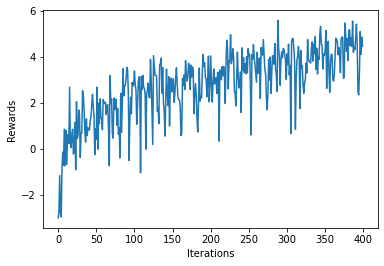

 40%|██████████████████████████████                                             | 40103/100000 [25:04<39:02, 25.57it/s]

Updated Weights
Mean Reward = 4.52
8


 40%|██████████████████████████████▏                                            | 40204/100000 [25:08<39:23, 25.30it/s]

Updated Weights
Mean Reward = 5.16
6


 40%|██████████████████████████████▏                                            | 40306/100000 [25:12<35:30, 28.02it/s]

Updated Weights
Mean Reward = 4.76
10


 40%|██████████████████████████████▎                                            | 40404/100000 [25:15<37:27, 26.51it/s]

Updated Weights
Mean Reward = 4.57
7


 40%|██████████████████████████████▎                                            | 40498/100000 [25:19<36:15, 27.35it/s]

Updated Weights
Mean Reward = 5.53
13


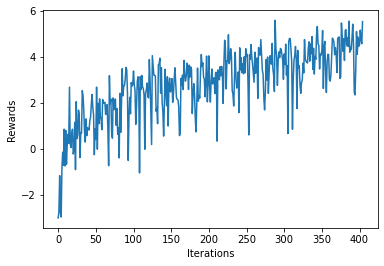

 41%|██████████████████████████████▍                                            | 40606/100000 [25:23<37:24, 26.46it/s]

Updated Weights
Mean Reward = 5.6
7


 41%|██████████████████████████████▌                                            | 40706/100000 [25:27<37:52, 26.09it/s]

Updated Weights
Mean Reward = 5.48
9


 41%|██████████████████████████████▌                                            | 40807/100000 [25:30<34:52, 28.29it/s]

Updated Weights
Mean Reward = 5.27
5


 41%|██████████████████████████████▋                                            | 40904/100000 [25:34<38:17, 25.72it/s]

Updated Weights
Mean Reward = 5.04
10


 41%|██████████████████████████████▋                                            | 41000/100000 [25:38<36:33, 26.90it/s]

Updated Weights
Mean Reward = 4.28
5


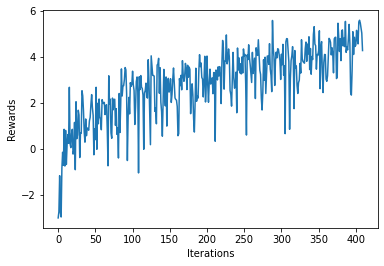

 41%|██████████████████████████████▊                                            | 41106/100000 [25:42<38:09, 25.73it/s]

Updated Weights
Mean Reward = 4.88
8


 41%|██████████████████████████████▉                                            | 41206/100000 [25:45<34:59, 28.00it/s]

Updated Weights
Mean Reward = 4.46
5


 41%|██████████████████████████████▉                                            | 41304/100000 [25:49<31:58, 30.60it/s]

Updated Weights
Mean Reward = 6.36
18


 41%|███████████████████████████████                                            | 41403/100000 [25:52<36:48, 26.53it/s]

Updated Weights
Mean Reward = 5.26
9


 41%|███████████████████████████████                                            | 41498/100000 [25:56<37:33, 25.96it/s]

Updated Weights
Mean Reward = 4.65
1


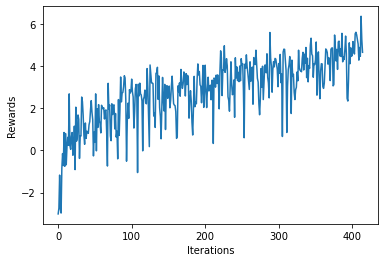

 42%|███████████████████████████████▏                                           | 41605/100000 [26:00<37:51, 25.71it/s]

Updated Weights
Mean Reward = 4.02
8


 42%|███████████████████████████████▎                                           | 41706/100000 [26:04<32:05, 30.27it/s]

Updated Weights
Mean Reward = 5.1
13


 42%|███████████████████████████████▎                                           | 41804/100000 [26:08<35:34, 27.26it/s]

Updated Weights
Mean Reward = 4.96
9


 42%|███████████████████████████████▍                                           | 41904/100000 [26:11<37:23, 25.89it/s]

Updated Weights
Mean Reward = 4.34
10


 42%|███████████████████████████████▌                                           | 42000/100000 [26:15<34:20, 28.15it/s]

Updated Weights
Mean Reward = 4.28
7


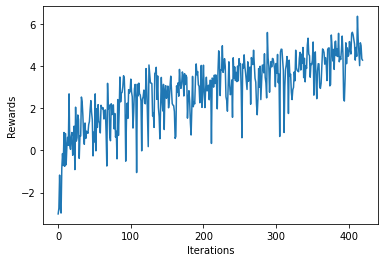

 42%|███████████████████████████████▌                                           | 42105/100000 [26:19<37:56, 25.44it/s]

Updated Weights
Mean Reward = 4.55
6


 42%|███████████████████████████████▋                                           | 42206/100000 [26:23<37:50, 25.45it/s]

Updated Weights
Mean Reward = 4.7
3


 42%|███████████████████████████████▋                                           | 42306/100000 [26:26<36:44, 26.17it/s]

Updated Weights
Mean Reward = 6.03
13


 42%|███████████████████████████████▊                                           | 42407/100000 [26:30<34:20, 27.96it/s]

Updated Weights
Mean Reward = 6.3
11


 42%|███████████████████████████████▊                                           | 42499/100000 [26:34<38:12, 25.09it/s]

Updated Weights
Mean Reward = 5.33
5


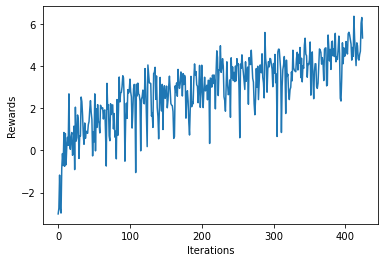

 43%|███████████████████████████████▉                                           | 42605/100000 [26:38<37:47, 25.31it/s]

Updated Weights
Mean Reward = 5.02
11


 43%|████████████████████████████████                                           | 42705/100000 [26:41<34:14, 27.89it/s]

Updated Weights
Mean Reward = 5.62
9


 43%|████████████████████████████████                                           | 42806/100000 [26:45<37:23, 25.50it/s]

Updated Weights
Mean Reward = 3.77
6


 43%|████████████████████████████████▏                                          | 42906/100000 [26:49<33:45, 28.19it/s]

Updated Weights
Mean Reward = 4.76
5


 43%|████████████████████████████████▏                                          | 42997/100000 [26:52<36:42, 25.88it/s]

Updated Weights
Mean Reward = 4.28
5


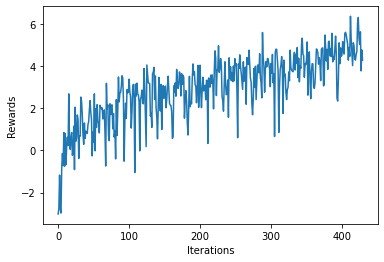

 43%|████████████████████████████████▎                                          | 43103/100000 [26:56<37:15, 25.45it/s]

Updated Weights
Mean Reward = 5.73
10


 43%|████████████████████████████████▍                                          | 43206/100000 [27:00<36:41, 25.80it/s]

Updated Weights
Mean Reward = 6.41
12


 43%|████████████████████████████████▍                                          | 43307/100000 [27:04<32:00, 29.52it/s]

Updated Weights
Mean Reward = 5.87
15


 43%|████████████████████████████████▌                                          | 43404/100000 [27:07<35:11, 26.80it/s]

Updated Weights
Mean Reward = 6.26
10


 43%|████████████████████████████████▌                                          | 43499/100000 [27:11<35:52, 26.25it/s]

Updated Weights
Mean Reward = 5.64
7


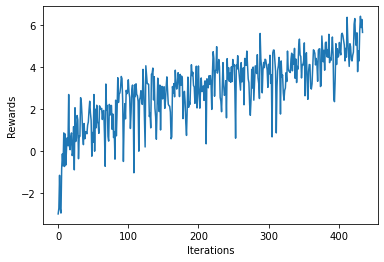

 44%|████████████████████████████████▋                                          | 43605/100000 [27:15<34:15, 27.43it/s]

Updated Weights
Mean Reward = 6.52
12


 44%|████████████████████████████████▊                                          | 43704/100000 [27:18<35:18, 26.57it/s]

Updated Weights
Mean Reward = 5.73
8


 44%|████████████████████████████████▊                                          | 43803/100000 [27:22<31:08, 30.07it/s]

Updated Weights
Mean Reward = 3.34
9


 44%|████████████████████████████████▉                                          | 43906/100000 [27:26<35:14, 26.52it/s]

Updated Weights
Mean Reward = 4.9
4


 44%|████████████████████████████████▉                                          | 43998/100000 [27:29<34:18, 27.20it/s]

Updated Weights
Mean Reward = 6.61
8


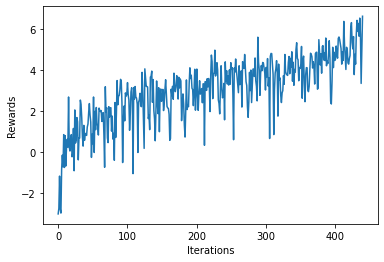

 44%|█████████████████████████████████                                          | 44105/100000 [27:33<36:15, 25.70it/s]

Updated Weights
Mean Reward = 6.5
9


 44%|█████████████████████████████████▏                                         | 44205/100000 [27:37<35:14, 26.39it/s]

Updated Weights
Mean Reward = 5.42
9


 44%|█████████████████████████████████▏                                         | 44304/100000 [27:41<33:13, 27.93it/s]

Updated Weights
Mean Reward = 4.85
10


 44%|█████████████████████████████████▎                                         | 44406/100000 [27:45<35:55, 25.79it/s]

Updated Weights
Mean Reward = 5.68
6


 44%|█████████████████████████████████▍                                         | 44500/100000 [27:48<34:47, 26.59it/s]

Updated Weights
Mean Reward = 5.62
7


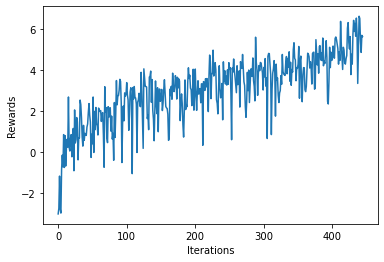

 45%|█████████████████████████████████▍                                         | 44607/100000 [27:52<32:32, 28.36it/s]

Updated Weights
Mean Reward = 5.65
11


 45%|█████████████████████████████████▌                                         | 44704/100000 [27:55<32:59, 27.93it/s]

Updated Weights
Mean Reward = 6.36
15


 45%|█████████████████████████████████▌                                         | 44804/100000 [27:59<33:49, 27.19it/s]

Updated Weights
Mean Reward = 6.48
17


 45%|█████████████████████████████████▋                                         | 44906/100000 [28:03<33:52, 27.10it/s]

Updated Weights
Mean Reward = 4.86
5


 45%|█████████████████████████████████▋                                         | 44999/100000 [28:06<35:34, 25.77it/s]

Updated Weights
Mean Reward = 4.29
7


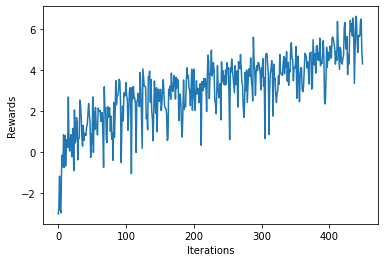

 45%|█████████████████████████████████▊                                         | 45104/100000 [28:10<33:48, 27.06it/s]

Updated Weights
Mean Reward = 5.63
10


 45%|█████████████████████████████████▉                                         | 45204/100000 [28:14<31:36, 28.90it/s]

Updated Weights
Mean Reward = 6.89
19


 45%|█████████████████████████████████▉                                         | 45307/100000 [28:18<33:36, 27.13it/s]

Updated Weights
Mean Reward = 5.18
5


 45%|██████████████████████████████████                                         | 45405/100000 [28:21<34:36, 26.29it/s]

Updated Weights
Mean Reward = 6.13
12


 45%|██████████████████████████████████                                         | 45499/100000 [28:24<35:38, 25.49it/s]

Updated Weights
Mean Reward = 6.47
12


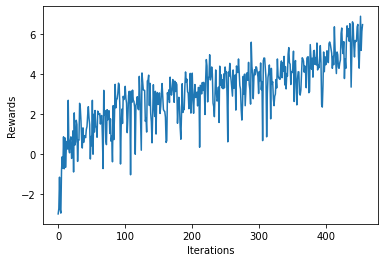

 46%|██████████████████████████████████▏                                        | 45607/100000 [28:29<32:26, 27.95it/s]

Updated Weights
Mean Reward = 5.05
9


 46%|██████████████████████████████████▎                                        | 45706/100000 [28:32<34:08, 26.50it/s]

Updated Weights
Mean Reward = 5.93
10


 46%|██████████████████████████████████▎                                        | 45805/100000 [28:36<34:36, 26.10it/s]

Updated Weights
Mean Reward = 5.79
7


 46%|██████████████████████████████████▍                                        | 45906/100000 [28:40<36:39, 24.59it/s]

Updated Weights
Mean Reward = 5.45
6


 46%|██████████████████████████████████▍                                        | 45997/100000 [28:43<34:19, 26.22it/s]

Updated Weights
Mean Reward = 3.87
6


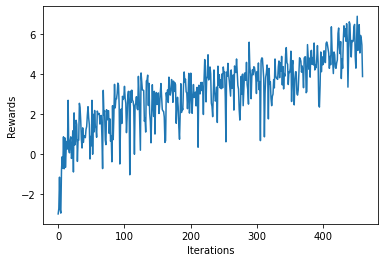

 46%|██████████████████████████████████▌                                        | 46104/100000 [28:47<34:47, 25.82it/s]

Updated Weights
Mean Reward = 3.71
6


 46%|██████████████████████████████████▋                                        | 46204/100000 [28:51<32:24, 27.67it/s]

Updated Weights
Mean Reward = 4.57
12


 46%|██████████████████████████████████▋                                        | 46304/100000 [28:55<33:30, 26.71it/s]

Updated Weights
Mean Reward = 5.72
7


 46%|██████████████████████████████████▊                                        | 46406/100000 [28:59<32:15, 27.69it/s]

Updated Weights
Mean Reward = 7.25
17


 46%|██████████████████████████████████▊                                        | 46499/100000 [29:02<34:38, 25.74it/s]

Updated Weights
Mean Reward = 4.53
7


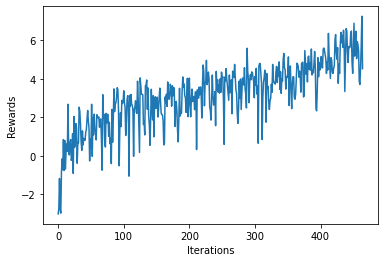

 47%|██████████████████████████████████▉                                        | 46604/100000 [29:06<34:28, 25.81it/s]

Updated Weights
Mean Reward = 4.87
10


 47%|███████████████████████████████████                                        | 46704/100000 [29:10<33:21, 26.63it/s]

Updated Weights
Mean Reward = 6.37
10


 47%|███████████████████████████████████                                        | 46807/100000 [29:13<29:04, 30.49it/s]

Updated Weights
Mean Reward = 6.49
14


 47%|███████████████████████████████████▏                                       | 46906/100000 [29:17<32:42, 27.05it/s]

Updated Weights
Mean Reward = 6.91
13


 47%|███████████████████████████████████▏                                       | 46998/100000 [29:20<33:06, 26.68it/s]

Updated Weights
Mean Reward = 4.62
5


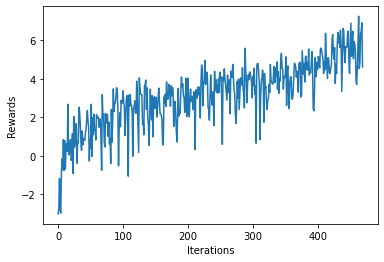

 47%|███████████████████████████████████▎                                       | 47105/100000 [29:25<34:55, 25.24it/s]

Updated Weights
Mean Reward = 5.27
11


 47%|███████████████████████████████████▍                                       | 47205/100000 [29:28<34:05, 25.81it/s]

Updated Weights
Mean Reward = 5.65
5


 47%|███████████████████████████████████▍                                       | 47304/100000 [29:32<33:48, 25.98it/s]

Updated Weights
Mean Reward = 5.71
10


 47%|███████████████████████████████████▌                                       | 47406/100000 [29:36<33:16, 26.35it/s]

Updated Weights
Mean Reward = 6.14
15


 47%|███████████████████████████████████▌                                       | 47498/100000 [29:39<33:48, 25.88it/s]

Updated Weights
Mean Reward = 6.87
11


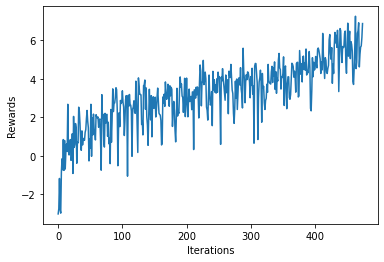

 48%|███████████████████████████████████▋                                       | 47604/100000 [29:43<33:56, 25.73it/s]

Updated Weights
Mean Reward = 4.0
3


 48%|███████████████████████████████████▊                                       | 47704/100000 [29:47<33:11, 26.26it/s]

Updated Weights
Mean Reward = 5.72
10


 48%|███████████████████████████████████▊                                       | 47806/100000 [29:50<32:10, 27.03it/s]

Updated Weights
Mean Reward = 6.02
12


 48%|███████████████████████████████████▉                                       | 47903/100000 [29:54<32:10, 26.98it/s]

Updated Weights
Mean Reward = 6.23
9


 48%|███████████████████████████████████▉                                       | 47999/100000 [29:57<30:04, 28.81it/s]

Updated Weights
Mean Reward = 6.27
11


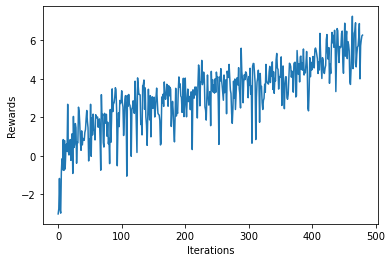

 48%|████████████████████████████████████                                       | 48106/100000 [30:01<33:27, 25.85it/s]

Updated Weights
Mean Reward = 6.37
13


 48%|████████████████████████████████████▏                                      | 48205/100000 [30:05<33:19, 25.90it/s]

Updated Weights
Mean Reward = 6.06
10


 48%|████████████████████████████████████▏                                      | 48305/100000 [30:09<34:17, 25.13it/s]

Updated Weights
Mean Reward = 5.83
7


 48%|████████████████████████████████████▎                                      | 48404/100000 [30:12<31:42, 27.13it/s]

Updated Weights
Mean Reward = 5.47
11


 48%|████████████████████████████████████▎                                      | 48499/100000 [30:16<32:35, 26.33it/s]

Updated Weights
Mean Reward = 3.23
5


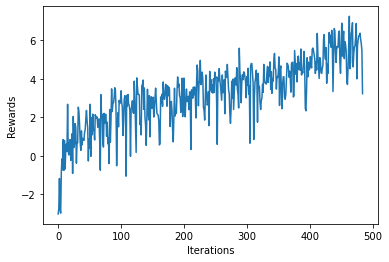

 49%|████████████████████████████████████▍                                      | 48606/100000 [30:20<33:19, 25.71it/s]

Updated Weights
Mean Reward = 3.75
7


 49%|████████████████████████████████████▌                                      | 48705/100000 [30:24<31:12, 27.39it/s]

Updated Weights
Mean Reward = 4.26
5


 49%|████████████████████████████████████▌                                      | 48806/100000 [30:28<31:51, 26.78it/s]

Updated Weights
Mean Reward = 6.59
15


 49%|████████████████████████████████████▋                                      | 48907/100000 [30:31<31:14, 27.26it/s]

Updated Weights
Mean Reward = 6.32
6


 49%|████████████████████████████████████▋                                      | 48998/100000 [30:35<31:14, 27.21it/s]

Updated Weights
Mean Reward = 5.45
10


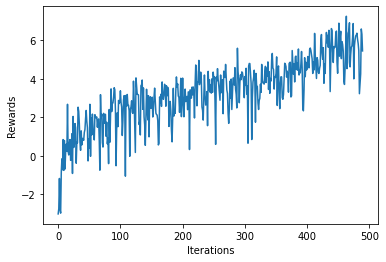

 49%|████████████████████████████████████▊                                      | 49106/100000 [30:39<27:57, 30.35it/s]

Updated Weights
Mean Reward = 6.46
10


 49%|████████████████████████████████████▉                                      | 49205/100000 [30:43<30:55, 27.38it/s]

Updated Weights
Mean Reward = 6.55
11


 49%|████████████████████████████████████▉                                      | 49305/100000 [30:46<32:35, 25.93it/s]

Updated Weights
Mean Reward = 6.56
10


 49%|█████████████████████████████████████                                      | 49406/100000 [30:50<32:31, 25.92it/s]

Updated Weights
Mean Reward = 6.07
6


 49%|█████████████████████████████████████                                      | 49499/100000 [30:54<32:34, 25.84it/s]

Updated Weights
Mean Reward = 5.6
5


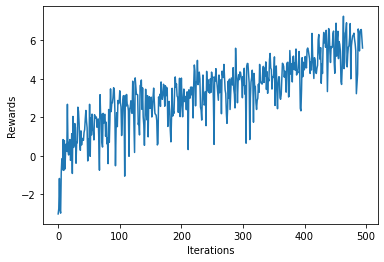

 50%|█████████████████████████████████████▏                                     | 49605/100000 [30:58<32:44, 25.66it/s]

Updated Weights
Mean Reward = 6.21
11


 50%|█████████████████████████████████████▎                                     | 49703/100000 [31:01<26:52, 31.20it/s]

Updated Weights
Mean Reward = 5.95
12


 50%|█████████████████████████████████████▎                                     | 49804/100000 [31:05<32:17, 25.91it/s]

Updated Weights
Mean Reward = 6.05
9


 50%|█████████████████████████████████████▍                                     | 49904/100000 [31:09<32:22, 25.79it/s]

Updated Weights
Mean Reward = 6.26
6


 50%|█████████████████████████████████████▍                                     | 49999/100000 [31:12<31:44, 26.26it/s]

Updated Weights
Mean Reward = 5.92
5


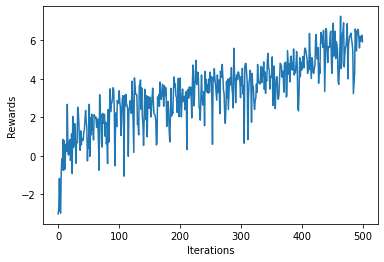

 50%|█████████████████████████████████████▌                                     | 50106/100000 [31:16<29:57, 27.75it/s]

Updated Weights
Mean Reward = 6.94
15


 50%|█████████████████████████████████████▋                                     | 50204/100000 [31:20<28:40, 28.94it/s]

Updated Weights
Mean Reward = 6.23
12


 50%|█████████████████████████████████████▋                                     | 50305/100000 [31:24<30:49, 26.87it/s]

Updated Weights
Mean Reward = 5.6
13


 50%|█████████████████████████████████████▊                                     | 50405/100000 [31:27<31:55, 25.89it/s]

Updated Weights
Mean Reward = 6.4
11


 50%|█████████████████████████████████████▊                                     | 50499/100000 [31:31<32:19, 25.52it/s]

Updated Weights
Mean Reward = 5.5
5


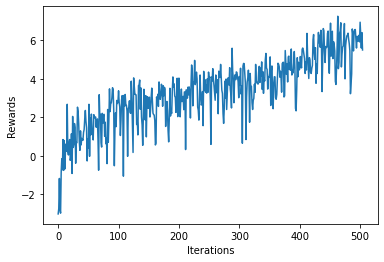

 51%|█████████████████████████████████████▉                                     | 50603/100000 [31:35<31:10, 26.40it/s]

Updated Weights
Mean Reward = 6.69
9


 51%|██████████████████████████████████████                                     | 50705/100000 [31:39<30:51, 26.63it/s]

Updated Weights
Mean Reward = 6.01
9


 51%|██████████████████████████████████████                                     | 50806/100000 [31:42<31:04, 26.38it/s]

Updated Weights
Mean Reward = 6.46
8


 51%|██████████████████████████████████████▏                                    | 50905/100000 [31:46<32:02, 25.53it/s]

Updated Weights
Mean Reward = 6.1
10


 51%|██████████████████████████████████████▏                                    | 50998/100000 [31:49<26:08, 31.24it/s]

Updated Weights
Mean Reward = 6.62
12


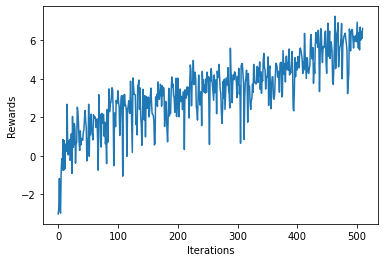

 51%|██████████████████████████████████████▎                                    | 51106/100000 [31:54<28:37, 28.47it/s]

Updated Weights
Mean Reward = 5.63
8


 51%|██████████████████████████████████████▍                                    | 51206/100000 [31:57<32:16, 25.20it/s]

Updated Weights
Mean Reward = 5.02
5


 51%|██████████████████████████████████████▍                                    | 51304/100000 [32:01<29:32, 27.47it/s]

Updated Weights
Mean Reward = 6.73
13


 51%|██████████████████████████████████████▌                                    | 51405/100000 [32:05<28:08, 28.78it/s]

Updated Weights
Mean Reward = 5.5
8


 52%|██████████████████████████████████████▋                                    | 51500/100000 [32:08<28:55, 27.94it/s]

Updated Weights
Mean Reward = 5.67
9


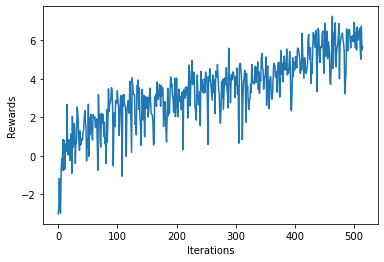

 52%|██████████████████████████████████████▋                                    | 51605/100000 [32:12<31:31, 25.58it/s]

Updated Weights
Mean Reward = 6.41
12


 52%|██████████████████████████████████████▊                                    | 51705/100000 [32:16<30:56, 26.02it/s]

Updated Weights
Mean Reward = 5.99
5


 52%|██████████████████████████████████████▊                                    | 51805/100000 [32:20<26:55, 29.84it/s]

Updated Weights
Mean Reward = 5.86
10


 52%|██████████████████████████████████████▉                                    | 51904/100000 [32:23<28:10, 28.45it/s]

Updated Weights
Mean Reward = 5.81
12


 52%|██████████████████████████████████████▉                                    | 51998/100000 [32:27<31:17, 25.57it/s]

Updated Weights
Mean Reward = 5.11
6


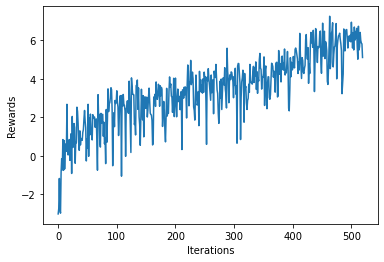

 52%|███████████████████████████████████████                                    | 52106/100000 [32:31<29:41, 26.89it/s]

Updated Weights
Mean Reward = 5.38
6


 52%|███████████████████████████████████████▏                                   | 52205/100000 [32:35<30:23, 26.21it/s]

Updated Weights
Mean Reward = 5.6
7


 52%|███████████████████████████████████████▏                                   | 52303/100000 [32:38<30:07, 26.39it/s]

Updated Weights
Mean Reward = 5.48
11


 52%|███████████████████████████████████████▎                                   | 52404/100000 [32:42<29:50, 26.58it/s]

Updated Weights
Mean Reward = 5.72
6


 52%|███████████████████████████████████████▎                                   | 52498/100000 [32:46<28:04, 28.20it/s]

Updated Weights
Mean Reward = 6.05
16


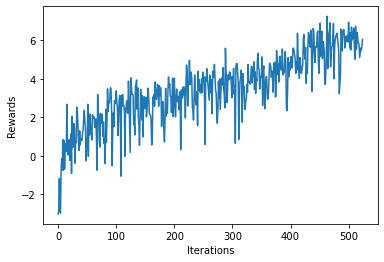

 53%|███████████████████████████████████████▍                                   | 52606/100000 [32:50<29:49, 26.49it/s]

Updated Weights
Mean Reward = 5.27
8


 53%|███████████████████████████████████████▌                                   | 52704/100000 [32:53<28:23, 27.76it/s]

Updated Weights
Mean Reward = 6.04
11


 53%|███████████████████████████████████████▌                                   | 52804/100000 [32:57<30:31, 25.77it/s]

Updated Weights
Mean Reward = 7.16
10


 53%|███████████████████████████████████████▋                                   | 52907/100000 [33:01<28:37, 27.43it/s]

Updated Weights
Mean Reward = 6.14
5


 53%|███████████████████████████████████████▊                                   | 53000/100000 [33:04<23:49, 32.89it/s]

Updated Weights
Mean Reward = 7.25
18


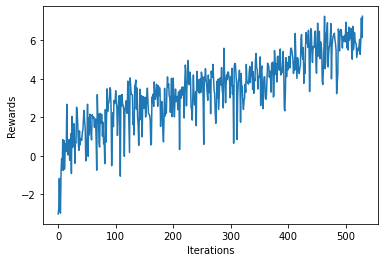

 53%|███████████████████████████████████████▊                                   | 53104/100000 [33:08<28:59, 26.96it/s]

Updated Weights
Mean Reward = 6.04
6


 53%|███████████████████████████████████████▉                                   | 53207/100000 [33:12<28:08, 27.71it/s]

Updated Weights
Mean Reward = 6.19
9


 53%|███████████████████████████████████████▉                                   | 53304/100000 [33:15<29:55, 26.01it/s]

Updated Weights
Mean Reward = 6.68
13


 53%|████████████████████████████████████████                                   | 53404/100000 [33:19<28:27, 27.28it/s]

Updated Weights
Mean Reward = 5.72
7


 54%|████████████████████████████████████████▏                                  | 53500/100000 [33:22<28:33, 27.13it/s]

Updated Weights
Mean Reward = 6.26
10


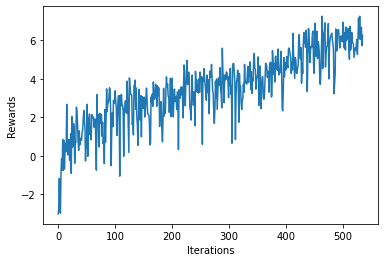

 54%|████████████████████████████████████████▏                                  | 53605/100000 [33:26<26:08, 29.58it/s]

Updated Weights
Mean Reward = 5.95
9


 54%|████████████████████████████████████████▎                                  | 53704/100000 [33:30<29:52, 25.83it/s]

Updated Weights
Mean Reward = 6.71
15


 54%|████████████████████████████████████████▎                                  | 53806/100000 [33:34<26:49, 28.71it/s]

Updated Weights
Mean Reward = 6.24
14


 54%|████████████████████████████████████████▍                                  | 53905/100000 [33:37<26:09, 29.36it/s]

Updated Weights
Mean Reward = 5.66
13


 54%|████████████████████████████████████████▍                                  | 53997/100000 [33:40<25:44, 29.79it/s]

Updated Weights
Mean Reward = 6.12
13


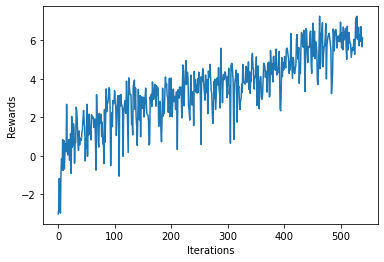

 54%|████████████████████████████████████████▌                                  | 54105/100000 [33:44<27:22, 27.95it/s]

Updated Weights
Mean Reward = 7.31
11


 54%|████████████████████████████████████████▋                                  | 54203/100000 [33:48<25:40, 29.74it/s]

Updated Weights
Mean Reward = 7.09
17


 54%|████████████████████████████████████████▋                                  | 54306/100000 [33:51<29:17, 26.00it/s]

Updated Weights
Mean Reward = 5.98
10


 54%|████████████████████████████████████████▊                                  | 54406/100000 [33:55<29:24, 25.84it/s]

Updated Weights
Mean Reward = 5.72
9


 55%|████████████████████████████████████████▉                                  | 54500/100000 [33:59<28:17, 26.81it/s]

Updated Weights
Mean Reward = 5.94
11


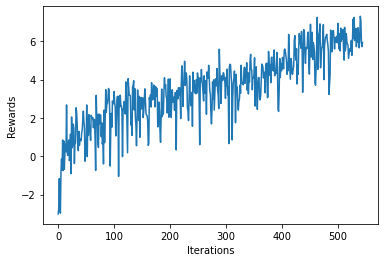

 55%|████████████████████████████████████████▉                                  | 54606/100000 [34:03<29:00, 26.08it/s]

Updated Weights
Mean Reward = 5.4
8


 55%|█████████████████████████████████████████                                  | 54706/100000 [34:06<28:36, 26.38it/s]

Updated Weights
Mean Reward = 6.39
12


 55%|█████████████████████████████████████████                                  | 54804/100000 [34:10<29:02, 25.94it/s]

Updated Weights
Mean Reward = 6.31
11


 55%|█████████████████████████████████████████▏                                 | 54905/100000 [34:14<26:11, 28.70it/s]

Updated Weights
Mean Reward = 6.52
10


 55%|█████████████████████████████████████████▏                                 | 54998/100000 [34:17<26:59, 27.79it/s]

Updated Weights
Mean Reward = 6.36
9


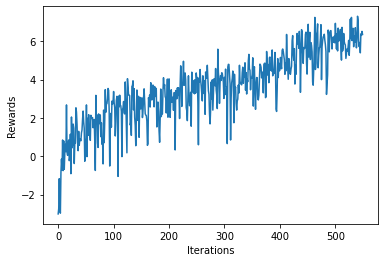

 55%|█████████████████████████████████████████▎                                 | 55104/100000 [34:21<26:14, 28.51it/s]

Updated Weights
Mean Reward = 5.66
11


 55%|█████████████████████████████████████████▍                                 | 55205/100000 [34:25<29:30, 25.31it/s]

Updated Weights
Mean Reward = 6.24
10


 55%|█████████████████████████████████████████▍                                 | 55305/100000 [34:28<28:47, 25.88it/s]

Updated Weights
Mean Reward = 7.16
13


 55%|█████████████████████████████████████████▌                                 | 55404/100000 [34:32<26:18, 28.25it/s]

Updated Weights
Mean Reward = 6.11
13


 55%|█████████████████████████████████████████▌                                 | 55497/100000 [34:35<27:31, 26.95it/s]

Updated Weights
Mean Reward = 5.96
9


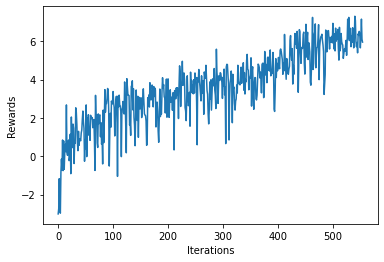

 56%|█████████████████████████████████████████▋                                 | 55606/100000 [34:40<27:37, 26.79it/s]

Updated Weights
Mean Reward = 5.77
8


 56%|█████████████████████████████████████████▊                                 | 55704/100000 [34:43<28:23, 26.00it/s]

Updated Weights
Mean Reward = 5.62
8


 56%|█████████████████████████████████████████▊                                 | 55806/100000 [34:47<25:21, 29.05it/s]

Updated Weights
Mean Reward = 6.16
12


 56%|█████████████████████████████████████████▉                                 | 55906/100000 [34:50<25:05, 29.29it/s]

Updated Weights
Mean Reward = 6.92
17


 56%|█████████████████████████████████████████▉                                 | 55998/100000 [34:54<27:41, 26.49it/s]

Updated Weights
Mean Reward = 5.82
9


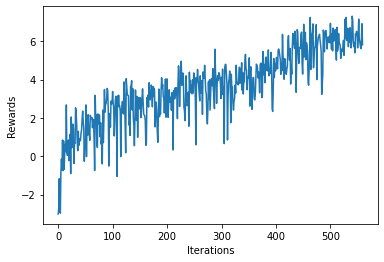

 56%|██████████████████████████████████████████                                 | 56105/100000 [34:58<28:13, 25.92it/s]

Updated Weights
Mean Reward = 7.17
12


 56%|██████████████████████████████████████████▏                                | 56204/100000 [35:01<26:38, 27.40it/s]

Updated Weights
Mean Reward = 6.52
17


 56%|██████████████████████████████████████████▏                                | 56306/100000 [35:05<23:37, 30.83it/s]

Updated Weights
Mean Reward = 6.22
11


 56%|██████████████████████████████████████████▎                                | 56407/100000 [35:09<25:07, 28.91it/s]

Updated Weights
Mean Reward = 7.19
12


 56%|██████████████████████████████████████████▎                                | 56500/100000 [35:12<26:37, 27.23it/s]

Updated Weights
Mean Reward = 5.86
9


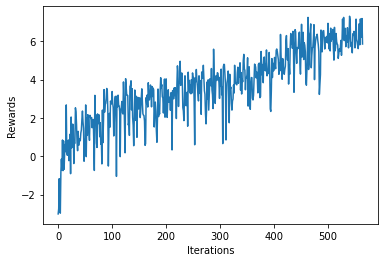

 57%|██████████████████████████████████████████▍                                | 56605/100000 [35:16<25:30, 28.36it/s]

Updated Weights
Mean Reward = 6.41
10


 57%|██████████████████████████████████████████▌                                | 56705/100000 [35:20<26:48, 26.92it/s]

Updated Weights
Mean Reward = 6.66
9


 57%|██████████████████████████████████████████▌                                | 56804/100000 [35:23<27:35, 26.09it/s]

Updated Weights
Mean Reward = 6.76
13


 57%|██████████████████████████████████████████▋                                | 56904/100000 [35:28<34:14, 20.98it/s]

Updated Weights
Mean Reward = 5.76
8


 57%|██████████████████████████████████████████▋                                | 57000/100000 [35:32<34:33, 20.73it/s]

Updated Weights
Mean Reward = 5.87
7


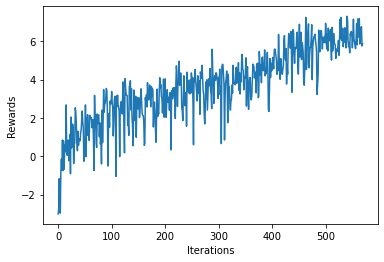

 57%|██████████████████████████████████████████▊                                | 57104/100000 [35:36<26:41, 26.79it/s]

Updated Weights
Mean Reward = 6.34
14


 57%|██████████████████████████████████████████▉                                | 57202/100000 [35:40<35:28, 20.11it/s]

Updated Weights
Mean Reward = 6.28
8


 57%|██████████████████████████████████████████▉                                | 57304/100000 [35:45<29:35, 24.05it/s]

Updated Weights
Mean Reward = 6.35
11


 57%|███████████████████████████████████████████                                | 57404/100000 [35:49<28:01, 25.33it/s]

Updated Weights
Mean Reward = 6.3
14


 57%|███████████████████████████████████████████▏                               | 57500/100000 [35:53<29:55, 23.67it/s]

Updated Weights
Mean Reward = 6.52
6


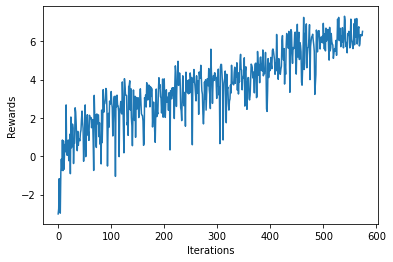

 58%|███████████████████████████████████████████▏                               | 57603/100000 [35:58<30:12, 23.39it/s]

Updated Weights
Mean Reward = 6.22
12


 58%|███████████████████████████████████████████▎                               | 57704/100000 [36:02<29:45, 23.68it/s]

Updated Weights
Mean Reward = 7.05
16


 58%|███████████████████████████████████████████▎                               | 57804/100000 [36:06<29:42, 23.67it/s]

Updated Weights
Mean Reward = 6.15
12


 58%|███████████████████████████████████████████▍                               | 57903/100000 [36:11<33:13, 21.12it/s]

Updated Weights
Mean Reward = 5.51
9


 58%|███████████████████████████████████████████▍                               | 57999/100000 [36:15<27:13, 25.71it/s]

Updated Weights
Mean Reward = 4.94
10


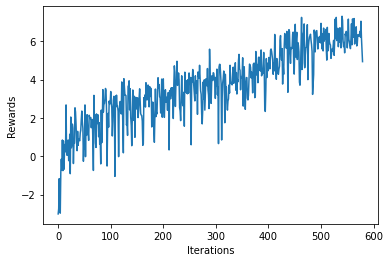

 58%|███████████████████████████████████████████▌                               | 58102/100000 [36:20<31:39, 22.05it/s]

Updated Weights
Mean Reward = 4.66
13


 58%|███████████████████████████████████████████▋                               | 58203/100000 [36:25<46:33, 14.96it/s]

Updated Weights
Mean Reward = 6.66
9


 58%|███████████████████████████████████████████▋                               | 58302/100000 [36:32<36:36, 18.98it/s]

Updated Weights
Mean Reward = 6.12
12


 58%|███████████████████████████████████████████▊                               | 58404/100000 [36:37<32:33, 21.30it/s]

Updated Weights
Mean Reward = 6.14
7


 58%|███████████████████████████████████████████▊                               | 58499/100000 [36:42<33:08, 20.87it/s]

Updated Weights
Mean Reward = 6.56
4


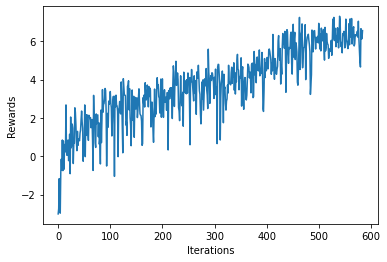

 59%|███████████████████████████████████████████▉                               | 58605/100000 [36:47<32:09, 21.45it/s]

Updated Weights
Mean Reward = 6.96
13


 59%|████████████████████████████████████████████                               | 58703/100000 [36:51<30:16, 22.73it/s]

Updated Weights
Mean Reward = 6.68
7


 59%|████████████████████████████████████████████                               | 58804/100000 [36:57<33:43, 20.36it/s]

Updated Weights
Mean Reward = 6.3
11


 59%|████████████████████████████████████████████▏                              | 58906/100000 [37:01<29:44, 23.03it/s]

Updated Weights
Mean Reward = 6.44
6


 59%|████████████████████████████████████████████▏                              | 58998/100000 [37:05<29:47, 22.94it/s]

Updated Weights
Mean Reward = 7.2
15


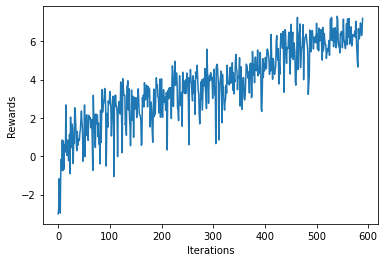

 59%|████████████████████████████████████████████▎                              | 59103/100000 [37:11<44:07, 15.45it/s]

Updated Weights
Mean Reward = 5.79
7


 59%|████████████████████████████████████████████▍                              | 59205/100000 [37:16<31:13, 21.77it/s]

Updated Weights
Mean Reward = 6.1
12


 59%|████████████████████████████████████████████▍                              | 59306/100000 [37:21<28:35, 23.72it/s]

Updated Weights
Mean Reward = 6.26
10


 59%|████████████████████████████████████████████▌                              | 59405/100000 [37:25<31:45, 21.31it/s]

Updated Weights
Mean Reward = 6.37
13


 59%|████████████████████████████████████████████▌                              | 59499/100000 [37:31<33:56, 19.88it/s]

Updated Weights
Mean Reward = 5.83
7


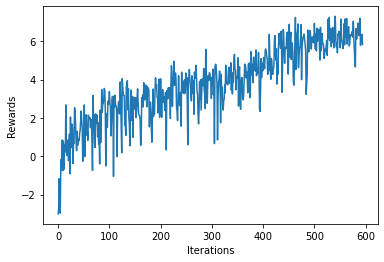

 60%|████████████████████████████████████████████▋                              | 59604/100000 [37:36<26:50, 25.08it/s]

Updated Weights
Mean Reward = 5.65
7


 60%|████████████████████████████████████████████▊                              | 59703/100000 [37:41<31:07, 21.58it/s]

Updated Weights
Mean Reward = 4.51
7


 60%|████████████████████████████████████████████▊                              | 59804/100000 [37:46<31:36, 21.20it/s]

Updated Weights
Mean Reward = 6.21
9


 60%|████████████████████████████████████████████▉                              | 59904/100000 [37:50<31:14, 21.39it/s]

Updated Weights
Mean Reward = 5.92
8


 60%|█████████████████████████████████████████████                              | 60000/100000 [37:54<28:58, 23.01it/s]

Updated Weights
Mean Reward = 6.99
10


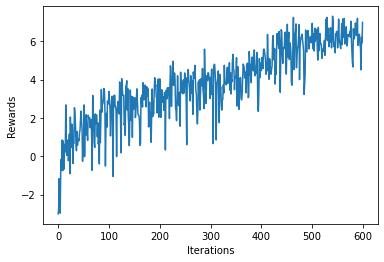

 60%|█████████████████████████████████████████████                              | 60103/100000 [37:59<27:03, 24.58it/s]

Updated Weights
Mean Reward = 6.92
13


 60%|█████████████████████████████████████████████▏                             | 60203/100000 [38:04<30:16, 21.91it/s]

Updated Weights
Mean Reward = 6.29
9


 60%|█████████████████████████████████████████████▏                             | 60305/100000 [38:08<30:30, 21.68it/s]

Updated Weights
Mean Reward = 6.18
12


 60%|█████████████████████████████████████████████▎                             | 60407/100000 [38:13<26:26, 24.96it/s]

Updated Weights
Mean Reward = 5.08
9


 60%|█████████████████████████████████████████████▎                             | 60498/100000 [38:17<28:37, 23.00it/s]

Updated Weights
Mean Reward = 5.76
14


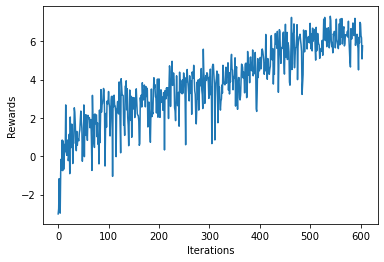

 61%|█████████████████████████████████████████████▍                             | 60603/100000 [38:22<32:40, 20.10it/s]

Updated Weights
Mean Reward = 6.17
12


 61%|█████████████████████████████████████████████▌                             | 60701/100000 [38:26<28:11, 23.24it/s]

Updated Weights
Mean Reward = 6.67
10


 61%|█████████████████████████████████████████████▌                             | 60805/100000 [38:31<27:09, 24.05it/s]

Updated Weights
Mean Reward = 6.8
11


 61%|█████████████████████████████████████████████▋                             | 60904/100000 [38:35<29:27, 22.12it/s]

Updated Weights
Mean Reward = 6.58
15


 61%|█████████████████████████████████████████████▋                             | 60999/100000 [38:39<30:53, 21.04it/s]

Updated Weights
Mean Reward = 7.55
13


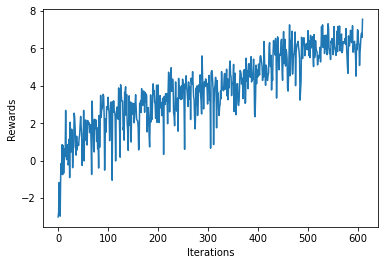

 61%|█████████████████████████████████████████████▊                             | 61103/100000 [38:44<27:47, 23.33it/s]

Updated Weights
Mean Reward = 6.85
18


 61%|█████████████████████████████████████████████▉                             | 61203/100000 [38:49<29:10, 22.17it/s]

Updated Weights
Mean Reward = 6.67
8


 61%|█████████████████████████████████████████████▉                             | 61304/100000 [38:53<29:43, 21.70it/s]

Updated Weights
Mean Reward = 4.9
10


 61%|██████████████████████████████████████████████                             | 61403/100000 [38:58<29:43, 21.64it/s]

Updated Weights
Mean Reward = 6.28
9


 61%|██████████████████████████████████████████████                             | 61499/100000 [39:02<29:44, 21.57it/s]

Updated Weights
Mean Reward = 6.21
5


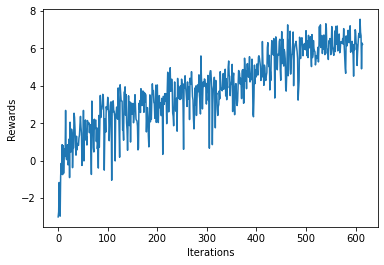

 62%|██████████████████████████████████████████████▏                            | 61605/100000 [39:07<29:39, 21.57it/s]

Updated Weights
Mean Reward = 6.22
14


 62%|██████████████████████████████████████████████▎                            | 61704/100000 [39:11<26:35, 24.00it/s]

Updated Weights
Mean Reward = 6.58
10


 62%|██████████████████████████████████████████████▎                            | 61802/100000 [39:17<33:03, 19.26it/s]

Updated Weights
Mean Reward = 5.97
8


 62%|██████████████████████████████████████████████▍                            | 61905/100000 [39:21<28:57, 21.92it/s]

Updated Weights
Mean Reward = 6.7
17


 62%|██████████████████████████████████████████████▌                            | 62000/100000 [39:25<23:26, 27.02it/s]

Updated Weights
Mean Reward = 7.15
16


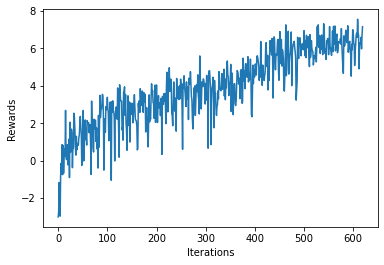

 62%|██████████████████████████████████████████████▌                            | 62104/100000 [39:30<26:17, 24.02it/s]

Updated Weights
Mean Reward = 6.5
12


 62%|██████████████████████████████████████████████▋                            | 62204/100000 [39:35<28:48, 21.87it/s]

Updated Weights
Mean Reward = 6.04
10


 62%|██████████████████████████████████████████████▋                            | 62304/100000 [39:39<29:46, 21.10it/s]

Updated Weights
Mean Reward = 6.7
6


 62%|██████████████████████████████████████████████▊                            | 62403/100000 [39:44<29:15, 21.42it/s]

Updated Weights
Mean Reward = 6.73
8


 62%|██████████████████████████████████████████████▉                            | 62500/100000 [39:48<27:31, 22.71it/s]

Updated Weights
Mean Reward = 5.48
6


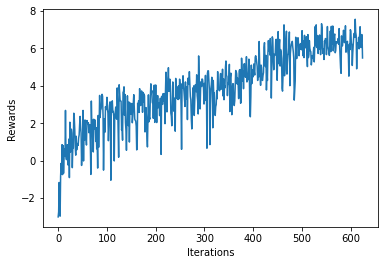

 63%|██████████████████████████████████████████████▉                            | 62603/100000 [39:53<29:03, 21.44it/s]

Updated Weights
Mean Reward = 5.81
8


 63%|███████████████████████████████████████████████                            | 62705/100000 [40:00<28:34, 21.76it/s]

Updated Weights
Mean Reward = 5.82
7


 63%|███████████████████████████████████████████████                            | 62803/100000 [40:04<28:47, 21.53it/s]

Updated Weights
Mean Reward = 6.64
12


 63%|███████████████████████████████████████████████▏                           | 62903/100000 [40:09<26:32, 23.30it/s]

Updated Weights
Mean Reward = 6.85
6


 63%|███████████████████████████████████████████████▎                           | 63000/100000 [40:13<28:47, 21.42it/s]

Updated Weights
Mean Reward = 5.61
14


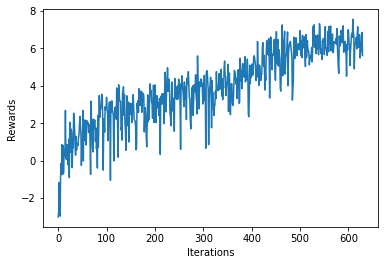

 63%|███████████████████████████████████████████████▎                           | 63105/100000 [40:18<28:00, 21.95it/s]

Updated Weights
Mean Reward = 6.69
9


 63%|███████████████████████████████████████████████▍                           | 63202/100000 [40:22<31:36, 19.41it/s]

Updated Weights
Mean Reward = 6.94
10


 63%|███████████████████████████████████████████████▍                           | 63303/100000 [40:27<27:41, 22.09it/s]

Updated Weights
Mean Reward = 7.15
15


 63%|███████████████████████████████████████████████▌                           | 63404/100000 [40:31<28:09, 21.66it/s]

Updated Weights
Mean Reward = 7.25
13


 63%|███████████████████████████████████████████████▌                           | 63498/100000 [40:36<28:51, 21.09it/s]

Updated Weights
Mean Reward = 6.06
11


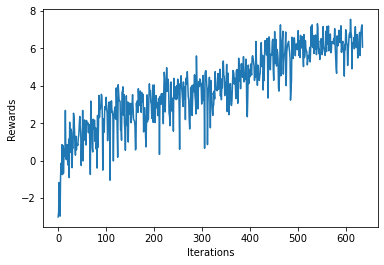

 64%|███████████████████████████████████████████████▋                           | 63605/100000 [40:41<28:04, 21.60it/s]

Updated Weights
Mean Reward = 4.81
7


 64%|███████████████████████████████████████████████▊                           | 63704/100000 [40:46<26:43, 22.63it/s]

Updated Weights
Mean Reward = 4.36
3


 64%|███████████████████████████████████████████████▊                           | 63804/100000 [40:50<28:12, 21.39it/s]

Updated Weights
Mean Reward = 5.81
8


 64%|███████████████████████████████████████████████▉                           | 63905/100000 [40:55<27:26, 21.92it/s]

Updated Weights
Mean Reward = 5.83
10


 64%|███████████████████████████████████████████████▉                           | 63998/100000 [40:59<28:48, 20.83it/s]

Updated Weights
Mean Reward = 6.11
6


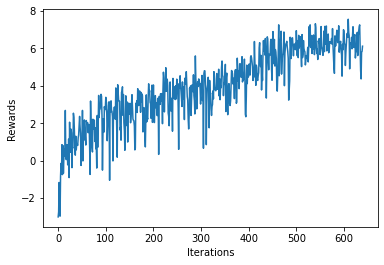

 64%|████████████████████████████████████████████████                           | 64104/100000 [41:04<25:36, 23.36it/s]

Updated Weights
Mean Reward = 6.12
9


 64%|████████████████████████████████████████████████▏                          | 64204/100000 [41:09<25:39, 23.25it/s]

Updated Weights
Mean Reward = 6.44
9


 64%|████████████████████████████████████████████████▏                          | 64306/100000 [41:13<23:46, 25.02it/s]

Updated Weights
Mean Reward = 5.96
9


 64%|████████████████████████████████████████████████▎                          | 64403/100000 [41:17<27:07, 21.87it/s]

Updated Weights
Mean Reward = 7.07
11


 64%|████████████████████████████████████████████████▎                          | 64499/100000 [41:22<26:16, 22.52it/s]

Updated Weights
Mean Reward = 6.03
8


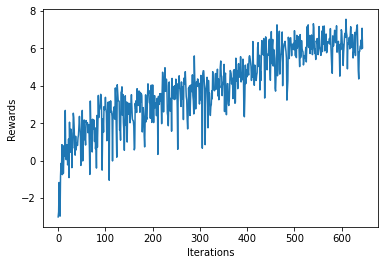

 65%|████████████████████████████████████████████████▍                          | 64602/100000 [41:27<26:51, 21.97it/s]

Updated Weights
Mean Reward = 6.85
12


 65%|████████████████████████████████████████████████▌                          | 64704/100000 [41:31<28:50, 20.40it/s]

Updated Weights
Mean Reward = 6.71
10


 65%|████████████████████████████████████████████████▌                          | 64805/100000 [41:36<29:06, 20.15it/s]

Updated Weights
Mean Reward = 6.05
5


 65%|████████████████████████████████████████████████▋                          | 64902/100000 [41:40<26:03, 22.45it/s]

Updated Weights
Mean Reward = 6.1
13


 65%|████████████████████████████████████████████████▊                          | 65000/100000 [41:45<26:19, 22.16it/s]

Updated Weights
Mean Reward = 5.62
8


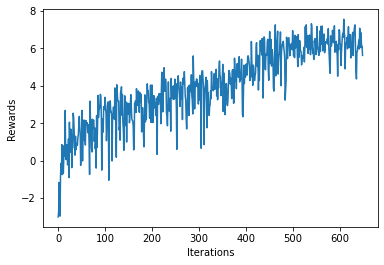

 65%|████████████████████████████████████████████████▊                          | 65103/100000 [41:50<26:18, 22.10it/s]

Updated Weights
Mean Reward = 5.22
6


 65%|████████████████████████████████████████████████▉                          | 65203/100000 [41:54<24:36, 23.56it/s]

Updated Weights
Mean Reward = 5.48
12


 65%|████████████████████████████████████████████████▉                          | 65303/100000 [41:59<30:34, 18.92it/s]

Updated Weights
Mean Reward = 6.2
10


 65%|█████████████████████████████████████████████████                          | 65405/100000 [42:05<45:26, 12.69it/s]

Updated Weights
Mean Reward = 6.33
4


 65%|█████████████████████████████████████████████████                          | 65498/100000 [42:09<24:50, 23.15it/s]

Updated Weights
Mean Reward = 6.87
14


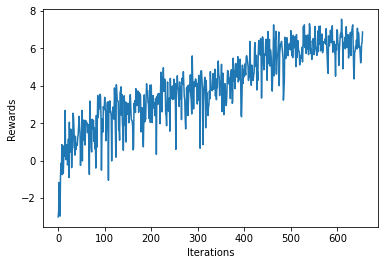

 66%|█████████████████████████████████████████████████▏                         | 65603/100000 [42:14<27:02, 21.21it/s]

Updated Weights
Mean Reward = 6.44
9


 66%|█████████████████████████████████████████████████▎                         | 65705/100000 [42:19<25:08, 22.74it/s]

Updated Weights
Mean Reward = 5.77
4


 66%|█████████████████████████████████████████████████▎                         | 65804/100000 [42:25<30:13, 18.85it/s]

Updated Weights
Mean Reward = 6.71
10


 66%|█████████████████████████████████████████████████▍                         | 65904/100000 [42:29<23:40, 24.00it/s]

Updated Weights
Mean Reward = 7.58
20


 66%|█████████████████████████████████████████████████▌                         | 66000/100000 [42:34<25:40, 22.07it/s]

Updated Weights
Mean Reward = 5.38
9


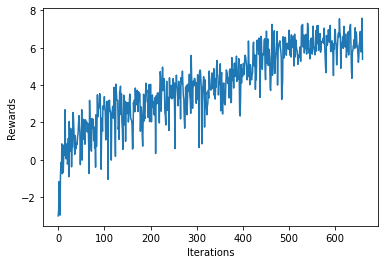

 66%|█████████████████████████████████████████████████▌                         | 66104/100000 [42:39<28:58, 19.50it/s]

Updated Weights
Mean Reward = 5.33
8


 66%|█████████████████████████████████████████████████▋                         | 66205/100000 [42:43<26:45, 21.05it/s]

Updated Weights
Mean Reward = 6.28
8


 66%|█████████████████████████████████████████████████▋                         | 66304/100000 [42:48<26:35, 21.12it/s]

Updated Weights
Mean Reward = 6.82
8


 66%|█████████████████████████████████████████████████▊                         | 66404/100000 [42:52<23:29, 23.83it/s]

Updated Weights
Mean Reward = 7.29
14


 66%|█████████████████████████████████████████████████▊                         | 66499/100000 [42:57<27:13, 20.51it/s]

Updated Weights
Mean Reward = 6.63
15


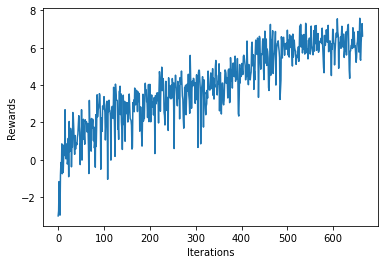

 67%|█████████████████████████████████████████████████▉                         | 66602/100000 [43:01<24:23, 22.82it/s]

Updated Weights
Mean Reward = 6.25
13


 67%|██████████████████████████████████████████████████                         | 66705/100000 [43:06<23:14, 23.88it/s]

Updated Weights
Mean Reward = 7.33
15


 67%|██████████████████████████████████████████████████                         | 66804/100000 [43:10<24:52, 22.24it/s]

Updated Weights
Mean Reward = 6.22
11


 67%|██████████████████████████████████████████████████▏                        | 66903/100000 [43:15<26:25, 20.88it/s]

Updated Weights
Mean Reward = 7.23
11


 67%|██████████████████████████████████████████████████▏                        | 66997/100000 [43:19<23:26, 23.46it/s]

Updated Weights
Mean Reward = 6.67
15


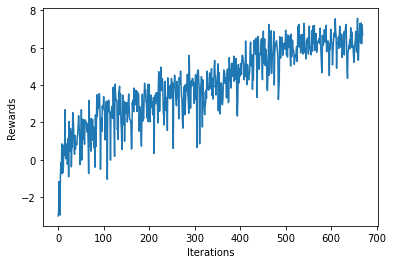

 67%|██████████████████████████████████████████████████▎                        | 67103/100000 [43:24<24:18, 22.55it/s]

Updated Weights
Mean Reward = 5.87
10


 67%|██████████████████████████████████████████████████▍                        | 67205/100000 [43:28<25:29, 21.44it/s]

Updated Weights
Mean Reward = 4.93
7


 67%|██████████████████████████████████████████████████▍                        | 67304/100000 [43:33<22:00, 24.76it/s]

Updated Weights
Mean Reward = 6.64
10


 67%|██████████████████████████████████████████████████▌                        | 67405/100000 [43:37<23:29, 23.13it/s]

Updated Weights
Mean Reward = 6.57
14


 67%|██████████████████████████████████████████████████▌                        | 67499/100000 [43:41<21:49, 24.82it/s]

Updated Weights
Mean Reward = 7.02
18


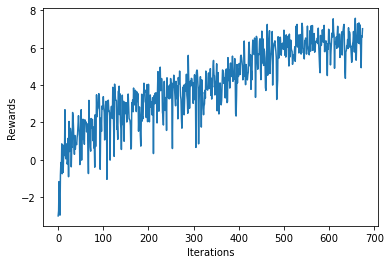

 68%|██████████████████████████████████████████████████▋                        | 67605/100000 [43:46<24:31, 22.02it/s]

Updated Weights
Mean Reward = 6.88
12


 68%|██████████████████████████████████████████████████▊                        | 67704/100000 [43:51<25:37, 21.00it/s]

Updated Weights
Mean Reward = 6.39
5


 68%|██████████████████████████████████████████████████▊                        | 67804/100000 [43:56<24:38, 21.77it/s]

Updated Weights
Mean Reward = 7.01
11


 68%|██████████████████████████████████████████████████▉                        | 67904/100000 [44:00<22:22, 23.92it/s]

Updated Weights
Mean Reward = 5.91
8


 68%|██████████████████████████████████████████████████▉                        | 67999/100000 [44:04<22:43, 23.47it/s]

Updated Weights
Mean Reward = 7.34
17


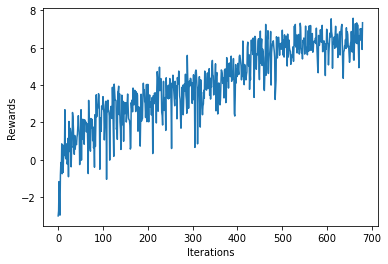

 68%|███████████████████████████████████████████████████                        | 68105/100000 [44:09<23:43, 22.40it/s]

Updated Weights
Mean Reward = 6.11
9


 68%|███████████████████████████████████████████████████▏                       | 68203/100000 [44:14<24:48, 21.36it/s]

Updated Weights
Mean Reward = 6.83
13


 68%|███████████████████████████████████████████████████▏                       | 68304/100000 [44:18<22:32, 23.43it/s]

Updated Weights
Mean Reward = 7.13
17


 68%|███████████████████████████████████████████████████▎                       | 68404/100000 [44:22<23:21, 22.54it/s]

Updated Weights
Mean Reward = 5.85
9


 68%|███████████████████████████████████████████████████▎                       | 68499/100000 [44:27<24:02, 21.84it/s]

Updated Weights
Mean Reward = 6.31
10


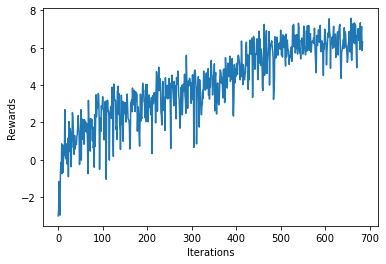

 69%|███████████████████████████████████████████████████▍                       | 68605/100000 [44:32<24:48, 21.09it/s]

Updated Weights
Mean Reward = 6.27
14


 69%|███████████████████████████████████████████████████▌                       | 68703/100000 [44:36<25:03, 20.82it/s]

Updated Weights
Mean Reward = 7.48
10


 69%|███████████████████████████████████████████████████▌                       | 68803/100000 [44:40<22:46, 22.83it/s]

Updated Weights
Mean Reward = 6.75
14


 69%|███████████████████████████████████████████████████▋                       | 68906/100000 [44:45<22:24, 23.13it/s]

Updated Weights
Mean Reward = 5.73
7


 69%|███████████████████████████████████████████████████▋                       | 68998/100000 [44:49<20:54, 24.70it/s]

Updated Weights
Mean Reward = 5.22
10


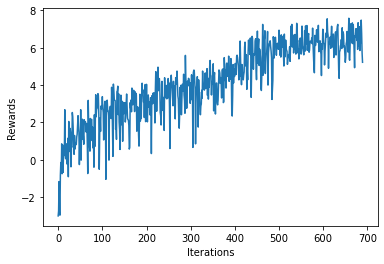

 69%|███████████████████████████████████████████████████▊                       | 69103/100000 [44:54<22:41, 22.69it/s]

Updated Weights
Mean Reward = 6.18
10


 69%|███████████████████████████████████████████████████▉                       | 69203/100000 [45:00<28:21, 18.10it/s]

Updated Weights
Mean Reward = 6.23
5


 69%|███████████████████████████████████████████████████▉                       | 69305/100000 [45:04<22:26, 22.80it/s]

Updated Weights
Mean Reward = 7.44
19


 69%|████████████████████████████████████████████████████                       | 69405/100000 [45:09<21:58, 23.20it/s]

Updated Weights
Mean Reward = 7.38
11


 69%|████████████████████████████████████████████████████                       | 69499/100000 [45:13<23:51, 21.31it/s]

Updated Weights
Mean Reward = 6.21
7


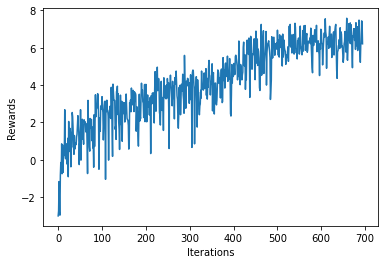

 70%|████████████████████████████████████████████████████▏                      | 69602/100000 [45:19<52:09,  9.71it/s]

Updated Weights
Mean Reward = 6.82
15


 70%|████████████████████████████████████████████████████▎                      | 69702/100000 [45:25<26:33, 19.01it/s]

Updated Weights
Mean Reward = 6.41
11


 70%|████████████████████████████████████████████████████▎                      | 69804/100000 [45:30<20:54, 24.07it/s]

Updated Weights
Mean Reward = 6.09
8


 70%|████████████████████████████████████████████████████▍                      | 69902/100000 [45:35<22:38, 22.15it/s]

Updated Weights
Mean Reward = 5.75
16


 70%|████████████████████████████████████████████████████▍                      | 69998/100000 [45:39<25:02, 19.97it/s]

Updated Weights
Mean Reward = 5.62
10


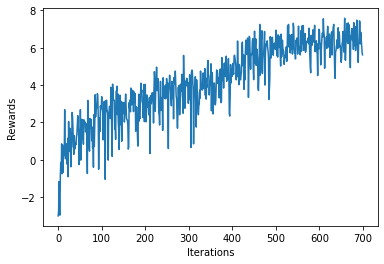

 70%|████████████████████████████████████████████████████▌                      | 70106/100000 [45:44<21:41, 22.98it/s]

Updated Weights
Mean Reward = 6.58
9


 70%|████████████████████████████████████████████████████▋                      | 70204/100000 [45:49<22:47, 21.79it/s]

Updated Weights
Mean Reward = 6.61
12


 70%|████████████████████████████████████████████████████▋                      | 70303/100000 [45:53<22:21, 22.15it/s]

Updated Weights
Mean Reward = 6.76
15


 70%|████████████████████████████████████████████████████▊                      | 70405/100000 [45:57<21:23, 23.06it/s]

Updated Weights
Mean Reward = 7.58
13


 70%|████████████████████████████████████████████████████▊                      | 70499/100000 [46:02<22:07, 22.22it/s]

Updated Weights
Mean Reward = 6.97
10


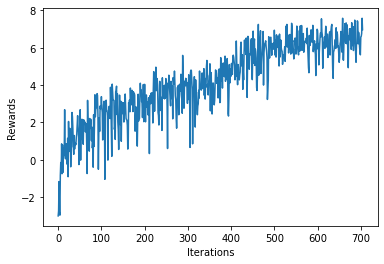

 71%|████████████████████████████████████████████████████▉                      | 70603/100000 [46:07<23:00, 21.29it/s]

Updated Weights
Mean Reward = 5.53
13


 71%|█████████████████████████████████████████████████████                      | 70705/100000 [46:12<22:26, 21.76it/s]

Updated Weights
Mean Reward = 5.19
9


 71%|█████████████████████████████████████████████████████                      | 70804/100000 [46:16<22:34, 21.56it/s]

Updated Weights
Mean Reward = 5.52
3


 71%|█████████████████████████████████████████████████████▏                     | 70904/100000 [46:21<23:50, 20.33it/s]

Updated Weights
Mean Reward = 6.08
9


 71%|█████████████████████████████████████████████████████▎                     | 71000/100000 [46:25<23:18, 20.73it/s]

Updated Weights
Mean Reward = 6.41
6


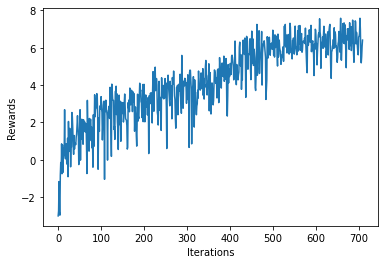

 71%|█████████████████████████████████████████████████████▎                     | 71103/100000 [46:30<20:04, 23.98it/s]

Updated Weights
Mean Reward = 6.61
18


 71%|█████████████████████████████████████████████████████▍                     | 71202/100000 [46:35<22:19, 21.49it/s]

Updated Weights
Mean Reward = 6.61
14


 71%|█████████████████████████████████████████████████████▍                     | 71303/100000 [46:39<22:25, 21.32it/s]

Updated Weights
Mean Reward = 7.13
13


 71%|█████████████████████████████████████████████████████▌                     | 71404/100000 [46:44<20:35, 23.15it/s]

Updated Weights
Mean Reward = 6.12
8


 72%|█████████████████████████████████████████████████████▋                     | 71500/100000 [46:48<19:52, 23.90it/s]

Updated Weights
Mean Reward = 6.93
19


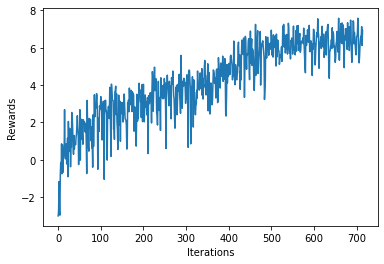

 72%|█████████████████████████████████████████████████████▋                     | 71603/100000 [46:53<19:57, 23.71it/s]

Updated Weights
Mean Reward = 6.1
16


 72%|█████████████████████████████████████████████████████▊                     | 71704/100000 [46:57<23:05, 20.42it/s]

Updated Weights
Mean Reward = 6.75
14


 72%|█████████████████████████████████████████████████████▊                     | 71803/100000 [47:01<21:41, 21.66it/s]

Updated Weights
Mean Reward = 7.36
21


 72%|█████████████████████████████████████████████████████▉                     | 71903/100000 [47:06<22:22, 20.94it/s]

Updated Weights
Mean Reward = 7.04
11


 72%|██████████████████████████████████████████████████████                     | 72000/100000 [47:10<18:01, 25.88it/s]

Updated Weights
Mean Reward = 6.9
18


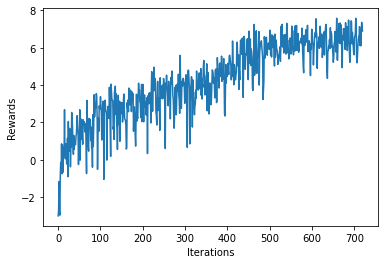

 72%|██████████████████████████████████████████████████████                     | 72104/100000 [47:15<20:22, 22.82it/s]

Updated Weights
Mean Reward = 6.97
9


 72%|██████████████████████████████████████████████████████▏                    | 72205/100000 [47:19<19:56, 23.22it/s]

Updated Weights
Mean Reward = 7.35
17


 72%|██████████████████████████████████████████████████████▏                    | 72304/100000 [47:24<19:17, 23.92it/s]

Updated Weights
Mean Reward = 5.28
10


 72%|██████████████████████████████████████████████████████▎                    | 72406/100000 [47:28<20:44, 22.17it/s]

Updated Weights
Mean Reward = 6.6
13


 72%|██████████████████████████████████████████████████████▍                    | 72500/100000 [47:32<22:46, 20.12it/s]

Updated Weights
Mean Reward = 6.1
8


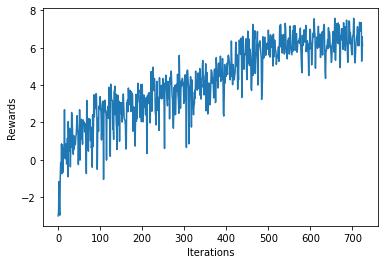

 73%|██████████████████████████████████████████████████████▍                    | 72603/100000 [47:37<19:50, 23.02it/s]

Updated Weights
Mean Reward = 6.45
9


 73%|██████████████████████████████████████████████████████▌                    | 72703/100000 [47:42<21:26, 21.22it/s]

Updated Weights
Mean Reward = 6.75
6


 73%|██████████████████████████████████████████████████████▌                    | 72803/100000 [47:46<20:32, 22.06it/s]

Updated Weights
Mean Reward = 6.98
12


 73%|██████████████████████████████████████████████████████▋                    | 72904/100000 [47:51<20:36, 21.92it/s]

Updated Weights
Mean Reward = 6.5
11


 73%|██████████████████████████████████████████████████████▋                    | 72998/100000 [47:55<19:37, 22.93it/s]

Updated Weights
Mean Reward = 6.82
15


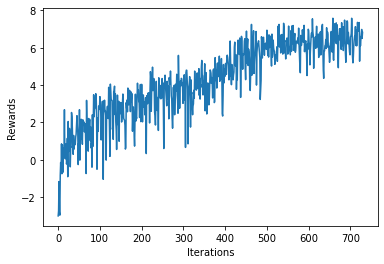

 73%|██████████████████████████████████████████████████████▊                    | 73103/100000 [48:00<18:04, 24.80it/s]

Updated Weights
Mean Reward = 6.7
13


 73%|██████████████████████████████████████████████████████▉                    | 73203/100000 [48:04<20:01, 22.31it/s]

Updated Weights
Mean Reward = 6.85
12


 73%|██████████████████████████████████████████████████████▉                    | 73302/100000 [48:09<19:12, 23.16it/s]

Updated Weights
Mean Reward = 6.57
9


 73%|███████████████████████████████████████████████████████                    | 73406/100000 [48:13<19:45, 22.43it/s]

Updated Weights
Mean Reward = 6.75
14


 73%|███████████████████████████████████████████████████████                    | 73498/100000 [48:17<19:01, 23.22it/s]

Updated Weights
Mean Reward = 7.2
18


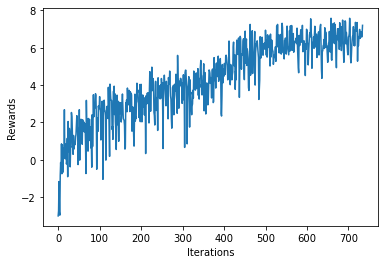

 74%|███████████████████████████████████████████████████████▏                   | 73603/100000 [48:22<20:59, 20.96it/s]

Updated Weights
Mean Reward = 5.26
8


 74%|███████████████████████████████████████████████████████▎                   | 73702/100000 [48:27<20:40, 21.20it/s]

Updated Weights
Mean Reward = 4.55
7


 74%|███████████████████████████████████████████████████████▎                   | 73805/100000 [48:31<20:30, 21.29it/s]

Updated Weights
Mean Reward = 5.64
12


 74%|███████████████████████████████████████████████████████▍                   | 73903/100000 [48:36<20:35, 21.12it/s]

Updated Weights
Mean Reward = 6.56
12


 74%|███████████████████████████████████████████████████████▍                   | 73999/100000 [48:40<20:25, 21.22it/s]

Updated Weights
Mean Reward = 6.56
8


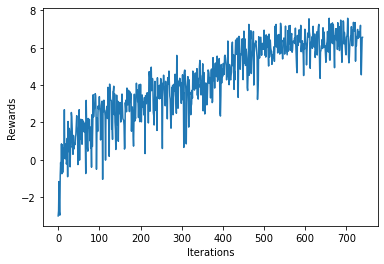

 74%|███████████████████████████████████████████████████████▌                   | 74104/100000 [48:45<19:40, 21.93it/s]

Updated Weights
Mean Reward = 6.1
11


 74%|███████████████████████████████████████████████████████▋                   | 74204/100000 [48:49<16:42, 25.72it/s]

Updated Weights
Mean Reward = 7.63
21


 74%|███████████████████████████████████████████████████████▋                   | 74305/100000 [48:54<17:10, 24.93it/s]

Updated Weights
Mean Reward = 7.31
19


 74%|███████████████████████████████████████████████████████▊                   | 74406/100000 [48:58<15:17, 27.91it/s]

Updated Weights
Mean Reward = 6.85
15


 74%|███████████████████████████████████████████████████████▉                   | 74500/100000 [49:02<18:47, 22.63it/s]

Updated Weights
Mean Reward = 7.15
18


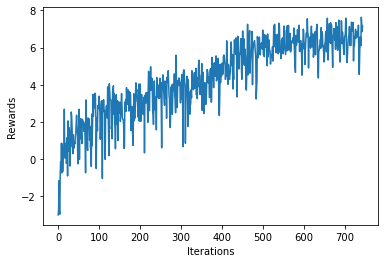

 75%|███████████████████████████████████████████████████████▉                   | 74604/100000 [49:07<19:55, 21.25it/s]

Updated Weights
Mean Reward = 6.51
10


 75%|████████████████████████████████████████████████████████                   | 74703/100000 [49:11<19:16, 21.88it/s]

Updated Weights
Mean Reward = 6.17
4


 75%|████████████████████████████████████████████████████████                   | 74802/100000 [49:16<19:03, 22.03it/s]

Updated Weights
Mean Reward = 7.1
14


 75%|████████████████████████████████████████████████████████▏                  | 74905/100000 [49:20<19:15, 21.71it/s]

Updated Weights
Mean Reward = 6.09
10


 75%|████████████████████████████████████████████████████████▎                  | 75000/100000 [49:25<21:24, 19.46it/s]

Updated Weights
Mean Reward = 5.85
10


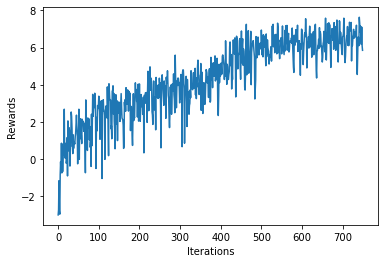

 75%|████████████████████████████████████████████████████████▎                  | 75104/100000 [49:30<16:41, 24.86it/s]

Updated Weights
Mean Reward = 6.53
19


 75%|████████████████████████████████████████████████████████▍                  | 75203/100000 [49:34<20:38, 20.02it/s]

Updated Weights
Mean Reward = 7.34
12


 75%|████████████████████████████████████████████████████████▍                  | 75303/100000 [49:38<19:32, 21.06it/s]

Updated Weights
Mean Reward = 7.26
11


 75%|████████████████████████████████████████████████████████▌                  | 75403/100000 [49:43<17:47, 23.04it/s]

Updated Weights
Mean Reward = 7.42
14


 75%|████████████████████████████████████████████████████████▌                  | 75498/100000 [49:47<19:25, 21.02it/s]

Updated Weights
Mean Reward = 6.25
14


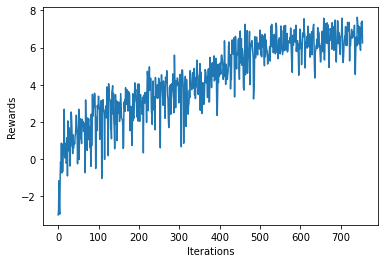

 76%|████████████████████████████████████████████████████████▋                  | 75603/100000 [49:52<19:22, 20.99it/s]

Updated Weights
Mean Reward = 6.21
8


 76%|████████████████████████████████████████████████████████▊                  | 75703/100000 [49:57<19:00, 21.30it/s]

Updated Weights
Mean Reward = 6.06
8


 76%|████████████████████████████████████████████████████████▊                  | 75807/100000 [50:02<18:45, 21.49it/s]

Updated Weights
Mean Reward = 6.18
7


 76%|████████████████████████████████████████████████████████▉                  | 75903/100000 [50:07<16:43, 24.01it/s]

Updated Weights
Mean Reward = 6.58
12


 76%|█████████████████████████████████████████████████████████                  | 76000/100000 [50:11<18:12, 21.98it/s]

Updated Weights
Mean Reward = 5.76
13


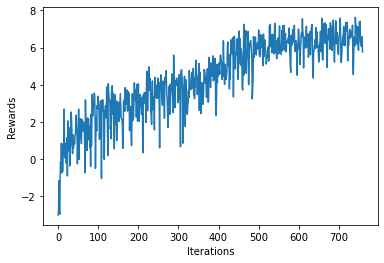

 76%|█████████████████████████████████████████████████████████                  | 76103/100000 [50:15<17:12, 23.14it/s]

Updated Weights
Mean Reward = 6.99
15


 76%|█████████████████████████████████████████████████████████▏                 | 76205/100000 [50:20<17:48, 22.28it/s]

Updated Weights
Mean Reward = 6.16
6


 76%|█████████████████████████████████████████████████████████▏                 | 76304/100000 [50:25<19:14, 20.53it/s]

Updated Weights
Mean Reward = 6.55
13


 76%|█████████████████████████████████████████████████████████▎                 | 76403/100000 [50:29<21:50, 18.00it/s]

Updated Weights
Mean Reward = 6.41
10


 76%|█████████████████████████████████████████████████████████▎                 | 76499/100000 [50:34<16:37, 23.57it/s]

Updated Weights
Mean Reward = 6.22
13


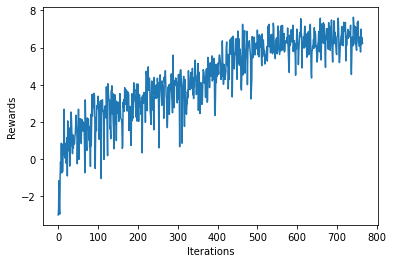

 77%|█████████████████████████████████████████████████████████▍                 | 76604/100000 [50:39<17:32, 22.22it/s]

Updated Weights
Mean Reward = 6.03
8


 77%|█████████████████████████████████████████████████████████▌                 | 76706/100000 [50:44<16:43, 23.20it/s]

Updated Weights
Mean Reward = 6.69
8


 77%|█████████████████████████████████████████████████████████▌                 | 76803/100000 [50:48<16:47, 23.03it/s]

Updated Weights
Mean Reward = 6.21
14


 77%|█████████████████████████████████████████████████████████▋                 | 76902/100000 [50:53<18:04, 21.30it/s]

Updated Weights
Mean Reward = 6.71
16


 77%|█████████████████████████████████████████████████████████▊                 | 77000/100000 [50:58<21:42, 17.66it/s]

Updated Weights
Mean Reward = 6.12
8


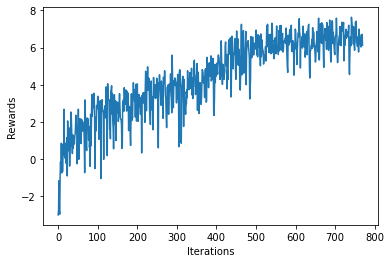

 77%|█████████████████████████████████████████████████████████▊                 | 77105/100000 [51:03<17:38, 21.62it/s]

Updated Weights
Mean Reward = 7.25
11


 77%|█████████████████████████████████████████████████████████▉                 | 77204/100000 [51:07<17:53, 21.23it/s]

Updated Weights
Mean Reward = 7.16
15


 77%|█████████████████████████████████████████████████████████▉                 | 77303/100000 [51:13<33:11, 11.40it/s]

Updated Weights
Mean Reward = 6.85
12


 77%|██████████████████████████████████████████████████████████                 | 77403/100000 [51:18<17:43, 21.25it/s]

Updated Weights
Mean Reward = 6.82
11


 78%|██████████████████████████████████████████████████████████▏                | 77500/100000 [51:22<17:12, 21.79it/s]

Updated Weights
Mean Reward = 5.58
10


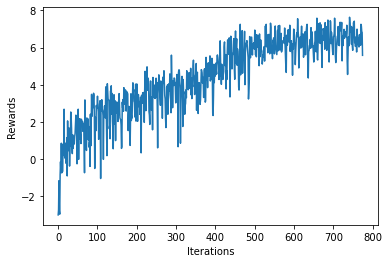

 78%|██████████████████████████████████████████████████████████▏                | 77604/100000 [51:27<17:42, 21.08it/s]

Updated Weights
Mean Reward = 6.72
10


 78%|██████████████████████████████████████████████████████████▎                | 77704/100000 [51:32<16:49, 22.08it/s]

Updated Weights
Mean Reward = 6.16
13


 78%|██████████████████████████████████████████████████████████▎                | 77803/100000 [51:36<17:56, 20.62it/s]

Updated Weights
Mean Reward = 7.47
15


 78%|██████████████████████████████████████████████████████████▍                | 77903/100000 [51:41<18:19, 20.09it/s]

Updated Weights
Mean Reward = 5.59
13


 78%|██████████████████████████████████████████████████████████▍                | 77999/100000 [51:45<17:42, 20.70it/s]

Updated Weights
Mean Reward = 7.05
10


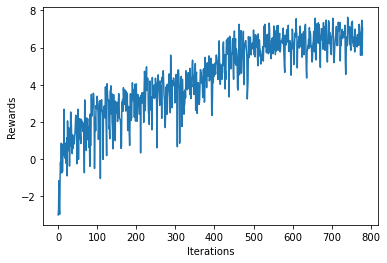

 78%|██████████████████████████████████████████████████████████▌                | 78102/100000 [51:51<19:04, 19.13it/s]

Updated Weights
Mean Reward = 6.22
9


 78%|██████████████████████████████████████████████████████████▋                | 78204/100000 [51:56<17:03, 21.31it/s]

Updated Weights
Mean Reward = 6.82
15


 78%|██████████████████████████████████████████████████████████▋                | 78302/100000 [52:04<56:00,  6.46it/s]

Updated Weights
Mean Reward = 6.36
8


 78%|██████████████████████████████████████████████████████████▊                | 78405/100000 [52:10<15:16, 23.55it/s]

Updated Weights
Mean Reward = 6.67
10


 78%|██████████████████████████████████████████████████████████▊                | 78498/100000 [52:14<16:22, 21.88it/s]

Updated Weights
Mean Reward = 6.69
14


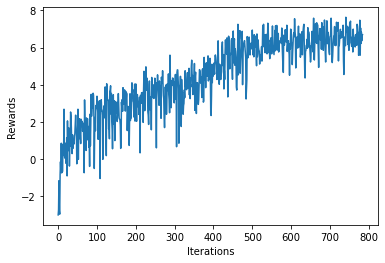

 79%|██████████████████████████████████████████████████████████▉                | 78603/100000 [52:21<19:20, 18.44it/s]

Updated Weights
Mean Reward = 7.63
13


 79%|███████████████████████████████████████████████████████████                | 78705/100000 [52:26<13:19, 26.63it/s]

Updated Weights
Mean Reward = 6.84
11


 79%|███████████████████████████████████████████████████████████                | 78805/100000 [52:30<19:02, 18.55it/s]

Updated Weights
Mean Reward = 7.36
15


 79%|███████████████████████████████████████████████████████████▏               | 78905/100000 [52:34<14:44, 23.84it/s]

Updated Weights
Mean Reward = 7.52
18


 79%|███████████████████████████████████████████████████████████▎               | 79000/100000 [52:39<15:21, 22.79it/s]

Updated Weights
Mean Reward = 6.6
12


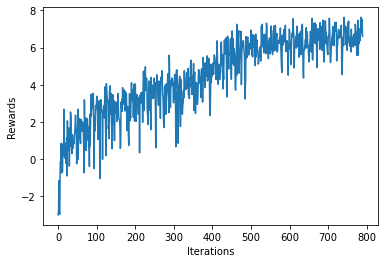

 79%|███████████████████████████████████████████████████████████▎               | 79104/100000 [52:44<14:44, 23.62it/s]

Updated Weights
Mean Reward = 6.95
8


 79%|███████████████████████████████████████████████████████████▍               | 79203/100000 [52:48<16:25, 21.10it/s]

Updated Weights
Mean Reward = 6.22
11


 79%|███████████████████████████████████████████████████████████▍               | 79303/100000 [52:53<16:33, 20.82it/s]

Updated Weights
Mean Reward = 6.59
8


 79%|███████████████████████████████████████████████████████████▌               | 79407/100000 [52:57<13:33, 25.30it/s]

Updated Weights
Mean Reward = 6.62
12


 79%|███████████████████████████████████████████████████████████▌               | 79499/100000 [53:01<13:40, 24.98it/s]

Updated Weights
Mean Reward = 7.65
16


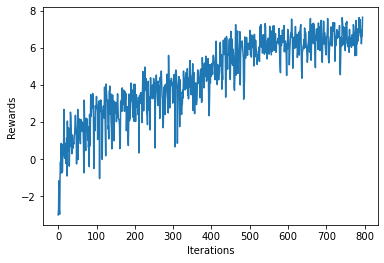

 80%|███████████████████████████████████████████████████████████▋               | 79602/100000 [53:07<18:54, 17.98it/s]

Updated Weights
Mean Reward = 7.06
15


 80%|███████████████████████████████████████████████████████████▊               | 79703/100000 [53:12<17:01, 19.87it/s]

Updated Weights
Mean Reward = 6.65
14


 80%|███████████████████████████████████████████████████████████▊               | 79804/100000 [53:17<15:26, 21.80it/s]

Updated Weights
Mean Reward = 6.97
10


 80%|███████████████████████████████████████████████████████████▉               | 79903/100000 [53:21<15:17, 21.91it/s]

Updated Weights
Mean Reward = 6.66
12


 80%|████████████████████████████████████████████████████████████               | 80000/100000 [53:27<16:23, 20.34it/s]

Updated Weights
Mean Reward = 6.23
11


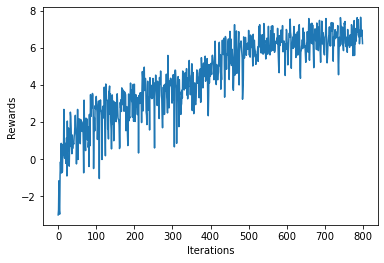

 80%|████████████████████████████████████████████████████████████               | 80104/100000 [53:34<18:23, 18.03it/s]

Updated Weights
Mean Reward = 5.44
7


 80%|████████████████████████████████████████████████████████████▏              | 80203/100000 [53:40<20:26, 16.14it/s]

Updated Weights
Mean Reward = 5.84
12


 80%|████████████████████████████████████████████████████████████▏              | 80305/100000 [53:45<17:22, 18.90it/s]

Updated Weights
Mean Reward = 7.43
10


 80%|████████████████████████████████████████████████████████████▎              | 80403/100000 [53:51<20:34, 15.88it/s]

Updated Weights
Mean Reward = 6.72
10


 80%|████████████████████████████████████████████████████████████▍              | 80500/100000 [53:57<19:59, 16.26it/s]

Updated Weights
Mean Reward = 7.04
13


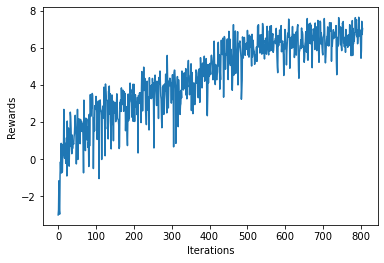

 81%|████████████████████████████████████████████████████████████▍              | 80606/100000 [54:03<14:13, 22.71it/s]

Updated Weights
Mean Reward = 6.83
14


 81%|████████████████████████████████████████████████████████████▌              | 80703/100000 [54:07<14:36, 22.01it/s]

Updated Weights
Mean Reward = 7.08
15


 81%|████████████████████████████████████████████████████████████▌              | 80805/100000 [54:11<15:07, 21.15it/s]

Updated Weights
Mean Reward = 5.81
9


 81%|████████████████████████████████████████████████████████████▋              | 80905/100000 [54:17<15:20, 20.74it/s]

Updated Weights
Mean Reward = 5.08
6


 81%|████████████████████████████████████████████████████████████▊              | 81000/100000 [54:22<22:06, 14.33it/s]

Updated Weights
Mean Reward = 6.47
15


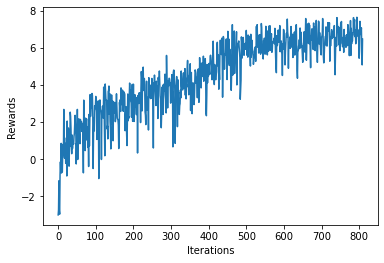

 81%|████████████████████████████████████████████████████████████▊              | 81101/100000 [54:27<19:49, 15.89it/s]

Updated Weights
Mean Reward = 5.78
8


 81%|████████████████████████████████████████████████████████████▉              | 81204/100000 [54:33<14:20, 21.85it/s]

Updated Weights
Mean Reward = 6.94
13


 81%|████████████████████████████████████████████████████████████▉              | 81305/100000 [54:38<14:58, 20.80it/s]

Updated Weights
Mean Reward = 6.24
11


 81%|█████████████████████████████████████████████████████████████              | 81403/100000 [54:42<14:10, 21.85it/s]

Updated Weights
Mean Reward = 6.07
11


 81%|█████████████████████████████████████████████████████████████              | 81499/100000 [54:46<13:08, 23.46it/s]

Updated Weights
Mean Reward = 6.55
11


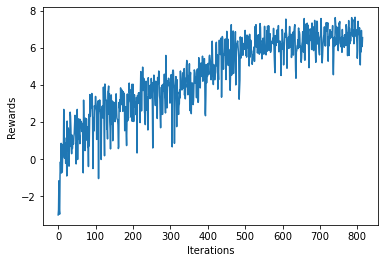

 82%|█████████████████████████████████████████████████████████████▏             | 81604/100000 [54:53<16:03, 19.09it/s]

Updated Weights
Mean Reward = 7.06
14


 82%|█████████████████████████████████████████████████████████████▎             | 81703/100000 [54:58<15:08, 20.15it/s]

Updated Weights
Mean Reward = 5.99
10


 82%|█████████████████████████████████████████████████████████████▎             | 81805/100000 [55:02<14:42, 20.63it/s]

Updated Weights
Mean Reward = 6.83
9


 82%|█████████████████████████████████████████████████████████████▍             | 81903/100000 [55:06<14:14, 21.18it/s]

Updated Weights
Mean Reward = 7.97
19


 82%|█████████████████████████████████████████████████████████████▍             | 82000/100000 [55:11<11:52, 25.25it/s]

Updated Weights
Mean Reward = 6.47
9


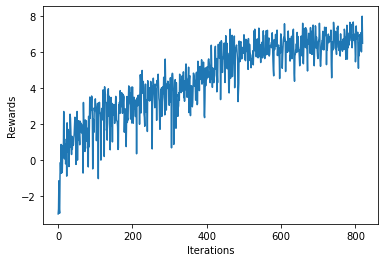

 82%|█████████████████████████████████████████████████████████████▌             | 82104/100000 [55:16<13:48, 21.60it/s]

Updated Weights
Mean Reward = 6.77
12


 82%|█████████████████████████████████████████████████████████████▋             | 82205/100000 [55:21<14:10, 20.93it/s]

Updated Weights
Mean Reward = 7.05
11


 82%|█████████████████████████████████████████████████████████████▋             | 82304/100000 [55:25<14:31, 20.29it/s]

Updated Weights
Mean Reward = 7.03
13


 82%|█████████████████████████████████████████████████████████████▊             | 82405/100000 [55:30<13:20, 21.98it/s]

Updated Weights
Mean Reward = 6.69
13


 82%|█████████████████████████████████████████████████████████████▊             | 82499/100000 [55:34<12:58, 22.48it/s]

Updated Weights
Mean Reward = 6.88
17


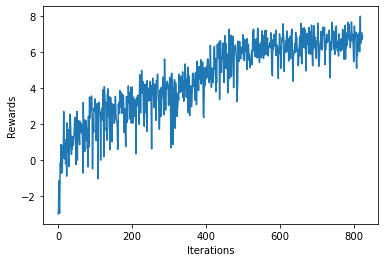

 83%|█████████████████████████████████████████████████████████████▉             | 82605/100000 [55:39<12:58, 22.35it/s]

Updated Weights
Mean Reward = 6.29
11


 83%|██████████████████████████████████████████████████████████████             | 82704/100000 [55:43<12:30, 23.03it/s]

Updated Weights
Mean Reward = 6.44
14


 83%|██████████████████████████████████████████████████████████████             | 82803/100000 [55:48<11:10, 25.64it/s]

Updated Weights
Mean Reward = 7.23
18


 83%|██████████████████████████████████████████████████████████████▏            | 82903/100000 [55:52<12:18, 23.15it/s]

Updated Weights
Mean Reward = 6.74
13


 83%|██████████████████████████████████████████████████████████████▏            | 82999/100000 [55:57<15:08, 18.71it/s]

Updated Weights
Mean Reward = 6.07
9


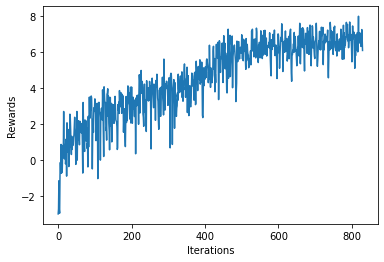

 83%|██████████████████████████████████████████████████████████████▎            | 83105/100000 [56:02<12:26, 22.62it/s]

Updated Weights
Mean Reward = 6.81
14


 83%|██████████████████████████████████████████████████████████████▍            | 83204/100000 [56:07<12:14, 22.88it/s]

Updated Weights
Mean Reward = 6.62
12


 83%|██████████████████████████████████████████████████████████████▍            | 83304/100000 [56:11<12:46, 21.78it/s]

Updated Weights
Mean Reward = 6.64
13


 83%|██████████████████████████████████████████████████████████████▌            | 83405/100000 [56:16<12:27, 22.20it/s]

Updated Weights
Mean Reward = 6.0
8


 83%|██████████████████████████████████████████████████████████████▌            | 83499/100000 [56:20<13:12, 20.83it/s]

Updated Weights
Mean Reward = 5.92
9


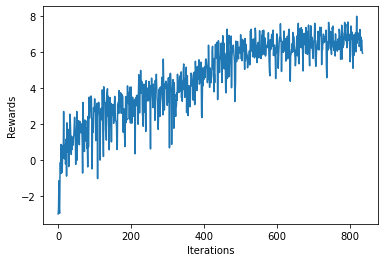

 84%|██████████████████████████████████████████████████████████████▋            | 83604/100000 [56:25<13:19, 20.52it/s]

Updated Weights
Mean Reward = 6.59
8


 84%|██████████████████████████████████████████████████████████████▊            | 83704/100000 [56:30<12:47, 21.24it/s]

Updated Weights
Mean Reward = 5.89
8


 84%|██████████████████████████████████████████████████████████████▊            | 83803/100000 [56:34<12:49, 21.04it/s]

Updated Weights
Mean Reward = 6.84
13


 84%|██████████████████████████████████████████████████████████████▉            | 83905/100000 [56:39<12:14, 21.91it/s]

Updated Weights
Mean Reward = 6.52
9


 84%|██████████████████████████████████████████████████████████████▉            | 83998/100000 [56:43<12:09, 21.94it/s]

Updated Weights
Mean Reward = 6.16
9


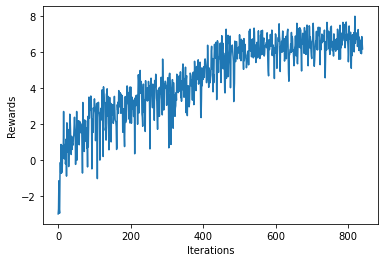

 84%|███████████████████████████████████████████████████████████████            | 84103/100000 [56:48<11:52, 22.32it/s]

Updated Weights
Mean Reward = 6.44
9


 84%|███████████████████████████████████████████████████████████████▏           | 84203/100000 [56:53<12:19, 21.37it/s]

Updated Weights
Mean Reward = 5.91
8


 84%|███████████████████████████████████████████████████████████████▏           | 84303/100000 [56:57<12:29, 20.95it/s]

Updated Weights
Mean Reward = 6.09
15


 84%|███████████████████████████████████████████████████████████████▎           | 84403/100000 [57:01<11:50, 21.96it/s]

Updated Weights
Mean Reward = 7.1
17


 84%|███████████████████████████████████████████████████████████████▍           | 84500/100000 [57:06<12:12, 21.16it/s]

Updated Weights
Mean Reward = 6.03
5


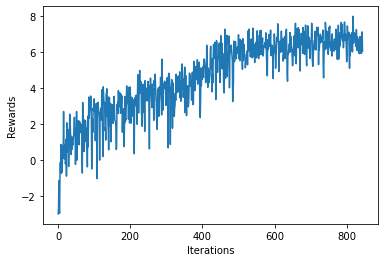

 85%|███████████████████████████████████████████████████████████████▍           | 84605/100000 [57:11<10:27, 24.55it/s]

Updated Weights
Mean Reward = 6.81
13


 85%|███████████████████████████████████████████████████████████████▌           | 84704/100000 [57:18<17:05, 14.92it/s]

Updated Weights
Mean Reward = 6.41
8


 85%|███████████████████████████████████████████████████████████████▌           | 84805/100000 [57:23<11:59, 21.13it/s]

Updated Weights
Mean Reward = 6.5
10


 85%|███████████████████████████████████████████████████████████████▋           | 84902/100000 [57:29<24:27, 10.29it/s]

Updated Weights
Mean Reward = 7.1
17


 85%|███████████████████████████████████████████████████████████████▋           | 84999/100000 [57:35<13:59, 17.87it/s]

Updated Weights
Mean Reward = 6.84
12


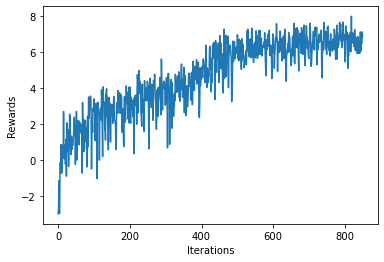

 85%|███████████████████████████████████████████████████████████████▊           | 85104/100000 [57:42<14:42, 16.87it/s]

Updated Weights
Mean Reward = 6.75
12


 85%|███████████████████████████████████████████████████████████████▉           | 85203/100000 [57:48<15:16, 16.15it/s]

Updated Weights
Mean Reward = 6.72
12


 85%|███████████████████████████████████████████████████████████████▉           | 85302/100000 [57:54<13:14, 18.49it/s]

Updated Weights
Mean Reward = 6.55
15


 85%|████████████████████████████████████████████████████████████████           | 85402/100000 [57:59<12:06, 20.10it/s]

Updated Weights
Mean Reward = 7.19
14


 86%|████████████████████████████████████████████████████████████████▏          | 85500/100000 [58:05<14:07, 17.10it/s]

Updated Weights
Mean Reward = 6.88
10


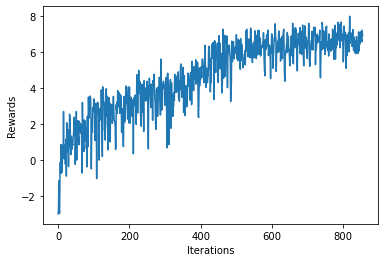

 86%|████████████████████████████████████████████████████████████████▏          | 85605/100000 [58:11<13:50, 17.33it/s]

Updated Weights
Mean Reward = 6.76
12


 86%|████████████████████████████████████████████████████████████████▎          | 85703/100000 [58:16<11:15, 21.16it/s]

Updated Weights
Mean Reward = 6.31
14


 86%|████████████████████████████████████████████████████████████████▎          | 85804/100000 [58:20<10:59, 21.53it/s]

Updated Weights
Mean Reward = 6.24
6


 86%|████████████████████████████████████████████████████████████████▍          | 85903/100000 [58:25<10:17, 22.83it/s]

Updated Weights
Mean Reward = 5.45
12


 86%|████████████████████████████████████████████████████████████████▍          | 85998/100000 [58:29<10:54, 21.40it/s]

Updated Weights
Mean Reward = 6.88
13


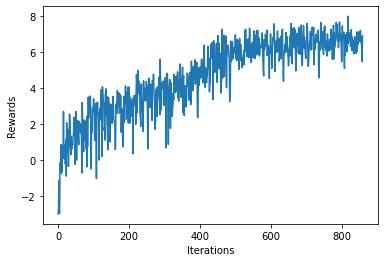

 86%|████████████████████████████████████████████████████████████████▌          | 86104/100000 [58:35<11:53, 19.49it/s]

Updated Weights
Mean Reward = 6.31
13


 86%|████████████████████████████████████████████████████████████████▋          | 86204/100000 [58:39<10:49, 21.24it/s]

Updated Weights
Mean Reward = 7.3
13


 86%|████████████████████████████████████████████████████████████████▋          | 86303/100000 [58:44<10:02, 22.73it/s]

Updated Weights
Mean Reward = 6.09
12


 86%|████████████████████████████████████████████████████████████████▊          | 86403/100000 [58:48<10:30, 21.56it/s]

Updated Weights
Mean Reward = 7.52
16


 86%|████████████████████████████████████████████████████████████████▉          | 86500/100000 [58:52<10:11, 22.09it/s]

Updated Weights
Mean Reward = 5.68
13


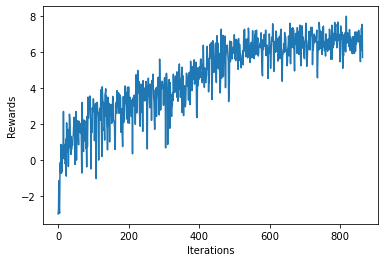

 87%|████████████████████████████████████████████████████████████████▉          | 86602/100000 [58:57<10:11, 21.90it/s]

Updated Weights
Mean Reward = 6.24
16


 87%|█████████████████████████████████████████████████████████████████          | 86705/100000 [59:02<10:09, 21.82it/s]

Updated Weights
Mean Reward = 6.44
12


 87%|█████████████████████████████████████████████████████████████████          | 86805/100000 [59:06<09:10, 23.97it/s]

Updated Weights
Mean Reward = 5.77
8


 87%|█████████████████████████████████████████████████████████████████▏         | 86904/100000 [59:11<08:49, 24.74it/s]

Updated Weights
Mean Reward = 7.16
13


 87%|█████████████████████████████████████████████████████████████████▏         | 86998/100000 [59:15<09:50, 22.03it/s]

Updated Weights
Mean Reward = 6.78
9


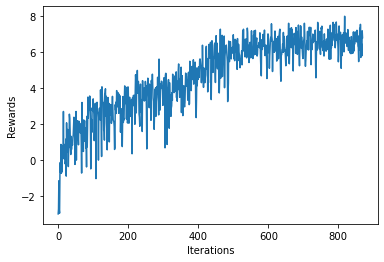

 87%|█████████████████████████████████████████████████████████████████▎         | 87106/100000 [59:19<08:09, 26.32it/s]

Updated Weights
Mean Reward = 7.29
22


 87%|█████████████████████████████████████████████████████████████████▍         | 87205/100000 [59:24<09:28, 22.52it/s]

Updated Weights
Mean Reward = 6.96
12


 87%|█████████████████████████████████████████████████████████████████▍         | 87302/100000 [59:29<17:17, 12.24it/s]

Updated Weights
Mean Reward = 7.19
14


 87%|█████████████████████████████████████████████████████████████████▌         | 87405/100000 [59:34<10:23, 20.19it/s]

Updated Weights
Mean Reward = 6.75
7


 87%|█████████████████████████████████████████████████████████████████▌         | 87498/100000 [59:38<08:36, 24.21it/s]

Updated Weights
Mean Reward = 6.36
10


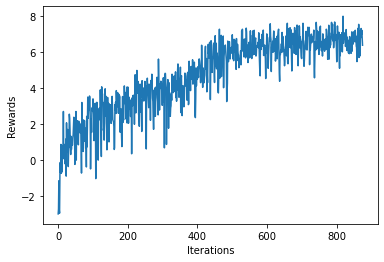

 88%|█████████████████████████████████████████████████████████████████▋         | 87603/100000 [59:43<09:03, 22.80it/s]

Updated Weights
Mean Reward = 6.37
9


 88%|█████████████████████████████████████████████████████████████████▊         | 87704/100000 [59:48<08:56, 22.93it/s]

Updated Weights
Mean Reward = 6.36
9


 88%|█████████████████████████████████████████████████████████████████▊         | 87802/100000 [59:53<11:23, 17.86it/s]

Updated Weights
Mean Reward = 6.4
10


 88%|█████████████████████████████████████████████████████████████████▉         | 87903/100000 [59:59<09:36, 21.00it/s]

Updated Weights
Mean Reward = 7.08
15


 88%|████████████████████████████████████████████████████████████████▏        | 87999/100000 [1:00:05<10:28, 19.08it/s]

Updated Weights
Mean Reward = 6.85
13


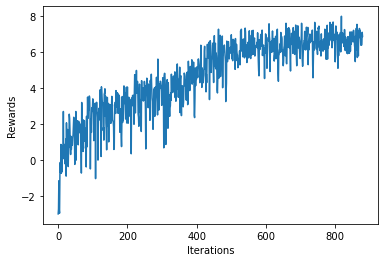

 88%|████████████████████████████████████████████████████████████████▎        | 88104/100000 [1:00:11<09:39, 20.54it/s]

Updated Weights
Mean Reward = 7.26
12


 88%|████████████████████████████████████████████████████████████████▍        | 88205/100000 [1:00:16<08:50, 22.24it/s]

Updated Weights
Mean Reward = 7.79
19


 88%|████████████████████████████████████████████████████████████████▍        | 88303/100000 [1:00:20<08:50, 22.04it/s]

Updated Weights
Mean Reward = 6.49
12


 88%|████████████████████████████████████████████████████████████████▌        | 88405/100000 [1:00:25<08:40, 22.28it/s]

Updated Weights
Mean Reward = 7.39
10


 88%|████████████████████████████████████████████████████████████████▌        | 88500/100000 [1:00:29<08:40, 22.09it/s]

Updated Weights
Mean Reward = 6.55
10


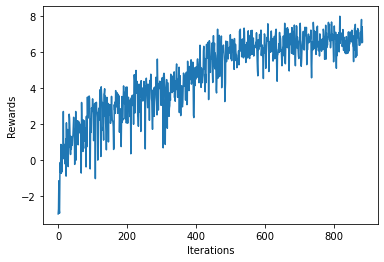

 89%|████████████████████████████████████████████████████████████████▋        | 88604/100000 [1:00:34<08:40, 21.90it/s]

Updated Weights
Mean Reward = 5.39
11


 89%|████████████████████████████████████████████████████████████████▊        | 88705/100000 [1:00:39<07:51, 23.97it/s]

Updated Weights
Mean Reward = 5.71
11


 89%|████████████████████████████████████████████████████████████████▊        | 88804/100000 [1:00:43<09:05, 20.54it/s]

Updated Weights
Mean Reward = 6.91
11


 89%|████████████████████████████████████████████████████████████████▉        | 88903/100000 [1:00:48<08:13, 22.48it/s]

Updated Weights
Mean Reward = 6.53
6


 89%|████████████████████████████████████████████████████████████████▉        | 89000/100000 [1:00:52<07:38, 24.02it/s]

Updated Weights
Mean Reward = 6.12
8


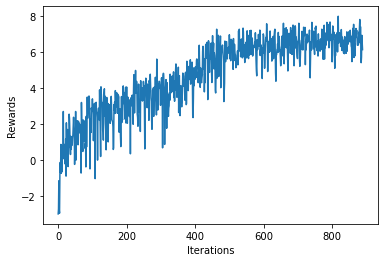

 89%|█████████████████████████████████████████████████████████████████        | 89105/100000 [1:00:58<07:31, 24.12it/s]

Updated Weights
Mean Reward = 6.65
16


 89%|█████████████████████████████████████████████████████████████████        | 89205/100000 [1:01:02<08:26, 21.31it/s]

Updated Weights
Mean Reward = 6.78
9


 89%|█████████████████████████████████████████████████████████████████▏       | 89304/100000 [1:01:06<07:18, 24.37it/s]

Updated Weights
Mean Reward = 7.16
15


 89%|█████████████████████████████████████████████████████████████████▎       | 89405/100000 [1:01:11<08:02, 21.94it/s]

Updated Weights
Mean Reward = 7.01
13


 89%|█████████████████████████████████████████████████████████████████▎       | 89498/100000 [1:01:15<08:04, 21.69it/s]

Updated Weights
Mean Reward = 5.85
12


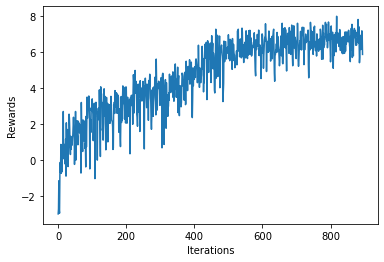

 90%|█████████████████████████████████████████████████████████████████▍       | 89605/100000 [1:01:20<07:37, 22.74it/s]

Updated Weights
Mean Reward = 6.61
10


 90%|█████████████████████████████████████████████████████████████████▍       | 89703/100000 [1:01:24<08:12, 20.91it/s]

Updated Weights
Mean Reward = 6.73
12


 90%|█████████████████████████████████████████████████████████████████▌       | 89804/100000 [1:01:29<07:39, 22.21it/s]

Updated Weights
Mean Reward = 6.99
11


 90%|█████████████████████████████████████████████████████████████████▋       | 89906/100000 [1:01:34<06:51, 24.52it/s]

Updated Weights
Mean Reward = 6.62
13


 90%|█████████████████████████████████████████████████████████████████▋       | 90000/100000 [1:01:38<07:34, 21.98it/s]

Updated Weights
Mean Reward = 6.35
15


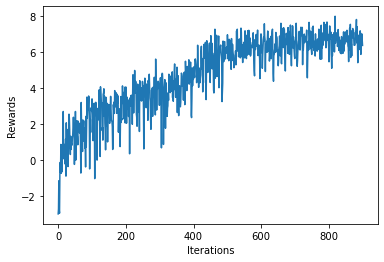

 90%|█████████████████████████████████████████████████████████████████▊       | 90104/100000 [1:01:45<08:53, 18.54it/s]

Updated Weights
Mean Reward = 5.95
6


 90%|█████████████████████████████████████████████████████████████████▊       | 90203/100000 [1:01:50<07:21, 22.20it/s]

Updated Weights
Mean Reward = 6.22
9


 90%|█████████████████████████████████████████████████████████████████▉       | 90306/100000 [1:01:54<06:34, 24.58it/s]

Updated Weights
Mean Reward = 6.04
13


 90%|█████████████████████████████████████████████████████████████████▉       | 90405/100000 [1:01:59<07:37, 20.96it/s]

Updated Weights
Mean Reward = 6.07
9


 90%|██████████████████████████████████████████████████████████████████       | 90500/100000 [1:02:03<06:57, 22.75it/s]

Updated Weights
Mean Reward = 6.27
7


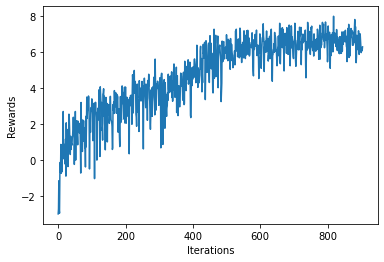

 91%|██████████████████████████████████████████████████████████████████▏      | 90605/100000 [1:02:08<06:48, 23.00it/s]

Updated Weights
Mean Reward = 6.76
9


 91%|██████████████████████████████████████████████████████████████████▏      | 90703/100000 [1:02:12<07:03, 21.96it/s]

Updated Weights
Mean Reward = 6.82
12


 91%|██████████████████████████████████████████████████████████████████▎      | 90803/100000 [1:02:19<11:54, 12.88it/s]

Updated Weights
Mean Reward = 5.85
7


 91%|██████████████████████████████████████████████████████████████████▎      | 90904/100000 [1:02:24<07:02, 21.55it/s]

Updated Weights
Mean Reward = 6.45
13


 91%|██████████████████████████████████████████████████████████████████▍      | 91000/100000 [1:02:28<06:32, 22.91it/s]

Updated Weights
Mean Reward = 7.06
15


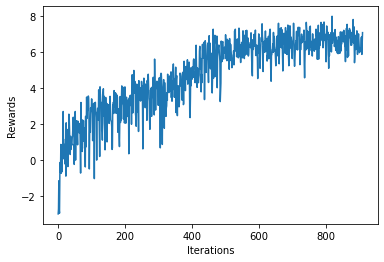

 91%|██████████████████████████████████████████████████████████████████▌      | 91104/100000 [1:02:33<06:52, 21.55it/s]

Updated Weights
Mean Reward = 7.25
16


 91%|██████████████████████████████████████████████████████████████████▌      | 91205/100000 [1:02:38<06:30, 22.55it/s]

Updated Weights
Mean Reward = 6.77
9


 91%|██████████████████████████████████████████████████████████████████▋      | 91304/100000 [1:02:42<07:10, 20.20it/s]

Updated Weights
Mean Reward = 6.14
7


 91%|██████████████████████████████████████████████████████████████████▋      | 91405/100000 [1:02:47<06:38, 21.59it/s]

Updated Weights
Mean Reward = 6.72
9


 91%|██████████████████████████████████████████████████████████████████▊      | 91499/100000 [1:02:51<06:18, 22.48it/s]

Updated Weights
Mean Reward = 6.24
13


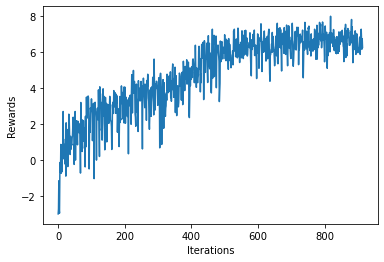

 92%|██████████████████████████████████████████████████████████████████▊      | 91604/100000 [1:02:56<06:39, 21.02it/s]

Updated Weights
Mean Reward = 6.23
10


 92%|██████████████████████████████████████████████████████████████████▉      | 91703/100000 [1:03:00<06:12, 22.30it/s]

Updated Weights
Mean Reward = 7.22
15


 92%|███████████████████████████████████████████████████████████████████      | 91805/100000 [1:03:05<05:53, 23.16it/s]

Updated Weights
Mean Reward = 8.04
18


 92%|███████████████████████████████████████████████████████████████████      | 91904/100000 [1:03:10<07:11, 18.77it/s]

Updated Weights
Mean Reward = 5.35
10


 92%|███████████████████████████████████████████████████████████████████▏     | 92000/100000 [1:03:15<09:27, 14.09it/s]

Updated Weights
Mean Reward = 6.7
14


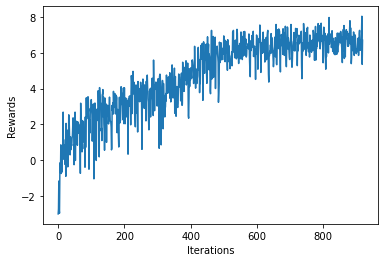

 92%|███████████████████████████████████████████████████████████████████▏     | 92104/100000 [1:03:21<05:24, 24.36it/s]

Updated Weights
Mean Reward = 6.9
8


 92%|███████████████████████████████████████████████████████████████████▎     | 92203/100000 [1:03:25<06:06, 21.27it/s]

Updated Weights
Mean Reward = 6.82
11


 92%|███████████████████████████████████████████████████████████████████▍     | 92303/100000 [1:03:30<05:58, 21.44it/s]

Updated Weights
Mean Reward = 6.96
13


 92%|███████████████████████████████████████████████████████████████████▍     | 92405/100000 [1:03:34<05:34, 22.70it/s]

Updated Weights
Mean Reward = 3.32
3


 92%|███████████████████████████████████████████████████████████████████▌     | 92498/100000 [1:03:39<04:59, 25.01it/s]

Updated Weights
Mean Reward = 6.27
10


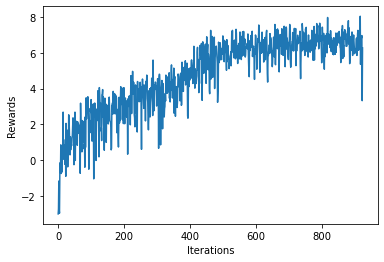

 93%|███████████████████████████████████████████████████████████████████▌     | 92606/100000 [1:03:44<05:26, 22.67it/s]

Updated Weights
Mean Reward = 6.37
10


 93%|███████████████████████████████████████████████████████████████████▋     | 92704/100000 [1:03:48<05:00, 24.25it/s]

Updated Weights
Mean Reward = 6.79
10


 93%|███████████████████████████████████████████████████████████████████▋     | 92804/100000 [1:03:53<05:16, 22.76it/s]

Updated Weights
Mean Reward = 7.16
14


 93%|███████████████████████████████████████████████████████████████████▊     | 92904/100000 [1:03:57<05:23, 21.94it/s]

Updated Weights
Mean Reward = 7.53
20


 93%|███████████████████████████████████████████████████████████████████▉     | 93000/100000 [1:04:01<05:23, 21.61it/s]

Updated Weights
Mean Reward = 6.12
7


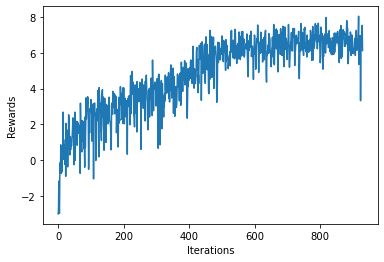

 93%|███████████████████████████████████████████████████████████████████▉     | 93105/100000 [1:04:07<05:05, 22.60it/s]

Updated Weights
Mean Reward = 6.75
14


 93%|████████████████████████████████████████████████████████████████████     | 93204/100000 [1:04:11<04:58, 22.79it/s]

Updated Weights
Mean Reward = 6.57
5


 93%|████████████████████████████████████████████████████████████████████     | 93303/100000 [1:04:15<04:34, 24.41it/s]

Updated Weights
Mean Reward = 7.13
15


 93%|████████████████████████████████████████████████████████████████████▏    | 93405/100000 [1:04:20<05:12, 21.12it/s]

Updated Weights
Mean Reward = 6.98
13


 93%|████████████████████████████████████████████████████████████████████▎    | 93498/100000 [1:04:24<05:06, 21.21it/s]

Updated Weights
Mean Reward = 6.68
9


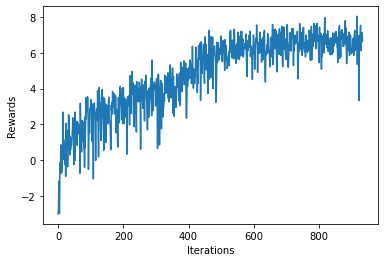

 94%|████████████████████████████████████████████████████████████████████▎    | 93603/100000 [1:04:29<04:55, 21.68it/s]

Updated Weights
Mean Reward = 6.27
11


 94%|████████████████████████████████████████████████████████████████████▍    | 93702/100000 [1:04:34<04:52, 21.53it/s]

Updated Weights
Mean Reward = 6.49
13


 94%|████████████████████████████████████████████████████████████████████▍    | 93804/100000 [1:04:38<04:35, 22.46it/s]

Updated Weights
Mean Reward = 6.46
9


 94%|████████████████████████████████████████████████████████████████████▌    | 93904/100000 [1:04:43<04:46, 21.29it/s]

Updated Weights
Mean Reward = 7.01
11


 94%|████████████████████████████████████████████████████████████████████▌    | 93999/100000 [1:04:47<04:27, 22.45it/s]

Updated Weights
Mean Reward = 7.82
15


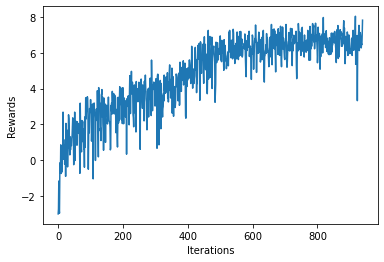

 94%|████████████████████████████████████████████████████████████████████▋    | 94105/100000 [1:04:51<04:00, 24.46it/s]

Updated Weights
Mean Reward = 7.43
21


 94%|████████████████████████████████████████████████████████████████████▊    | 94203/100000 [1:04:56<04:03, 23.80it/s]

Updated Weights
Mean Reward = 7.15
15


 94%|████████████████████████████████████████████████████████████████████▊    | 94305/100000 [1:05:00<03:58, 23.90it/s]

Updated Weights
Mean Reward = 6.56
6


 94%|████████████████████████████████████████████████████████████████████▉    | 94404/100000 [1:05:05<04:04, 22.85it/s]

Updated Weights
Mean Reward = 5.77
10


 94%|████████████████████████████████████████████████████████████████████▉    | 94498/100000 [1:05:09<04:05, 22.42it/s]

Updated Weights
Mean Reward = 5.83
10


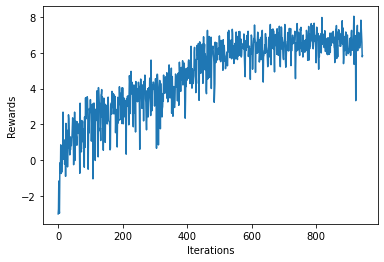

 95%|█████████████████████████████████████████████████████████████████████    | 94606/100000 [1:05:14<03:35, 25.06it/s]

Updated Weights
Mean Reward = 7.16
15


 95%|█████████████████████████████████████████████████████████████████████▏   | 94704/100000 [1:05:20<04:21, 20.28it/s]

Updated Weights
Mean Reward = 7.4
14


 95%|█████████████████████████████████████████████████████████████████████▏   | 94804/100000 [1:05:24<03:28, 24.96it/s]

Updated Weights
Mean Reward = 6.67
13


 95%|█████████████████████████████████████████████████████████████████████▎   | 94903/100000 [1:05:30<06:09, 13.78it/s]

Updated Weights
Mean Reward = 7.18
14


 95%|█████████████████████████████████████████████████████████████████████▎   | 94999/100000 [1:05:38<07:06, 11.72it/s]

Updated Weights
Mean Reward = 7.45
14


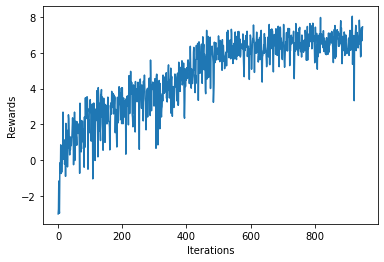

 95%|█████████████████████████████████████████████████████████████████████▍   | 95104/100000 [1:05:45<05:10, 15.75it/s]

Updated Weights
Mean Reward = 6.5
13


 95%|█████████████████████████████████████████████████████████████████████▍   | 95202/100000 [1:05:51<04:13, 18.91it/s]

Updated Weights
Mean Reward = 6.82
16


 95%|█████████████████████████████████████████████████████████████████████▌   | 95302/100000 [1:05:56<04:31, 17.28it/s]

Updated Weights
Mean Reward = 7.49
21


 95%|█████████████████████████████████████████████████████████████████████▋   | 95402/100000 [1:06:02<04:20, 17.67it/s]

Updated Weights
Mean Reward = 6.99
10


 96%|█████████████████████████████████████████████████████████████████████▋   | 95500/100000 [1:06:11<09:41,  7.74it/s]

Updated Weights
Mean Reward = 5.37
9


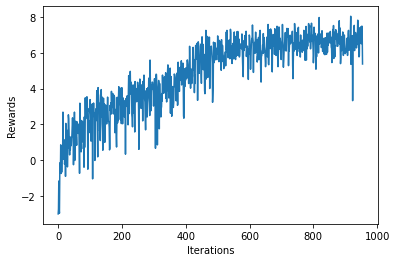

 96%|█████████████████████████████████████████████████████████████████████▊   | 95602/100000 [1:06:22<08:11,  8.95it/s]

Updated Weights
Mean Reward = 5.8
11


 96%|█████████████████████████████████████████████████████████████████████▊   | 95702/100000 [1:06:29<04:28, 16.00it/s]

Updated Weights
Mean Reward = 5.94
7


 96%|█████████████████████████████████████████████████████████████████████▉   | 95803/100000 [1:06:35<04:19, 16.18it/s]

Updated Weights
Mean Reward = 6.57
11


 96%|██████████████████████████████████████████████████████████████████████   | 95904/100000 [1:06:41<04:16, 15.99it/s]

Updated Weights
Mean Reward = 6.07
6


 96%|██████████████████████████████████████████████████████████████████████   | 96000/100000 [1:06:47<04:02, 16.52it/s]

Updated Weights
Mean Reward = 6.33
8


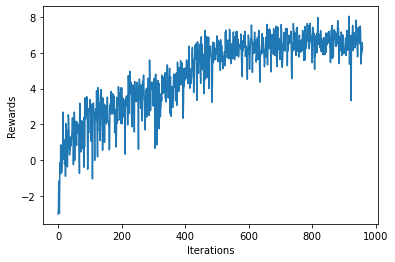

 96%|██████████████████████████████████████████████████████████████████████▏  | 96104/100000 [1:06:53<03:12, 20.27it/s]

Updated Weights
Mean Reward = 7.38
15


 96%|██████████████████████████████████████████████████████████████████████▏  | 96205/100000 [1:06:59<03:32, 17.82it/s]

Updated Weights
Mean Reward = 7.05
16


 96%|██████████████████████████████████████████████████████████████████████▎  | 96303/100000 [1:07:05<03:21, 18.34it/s]

Updated Weights
Mean Reward = 7.1
13


 96%|██████████████████████████████████████████████████████████████████████▍  | 96406/100000 [1:07:10<02:33, 23.40it/s]

Updated Weights
Mean Reward = 6.71
4


 96%|██████████████████████████████████████████████████████████████████████▍  | 96498/100000 [1:07:15<03:34, 16.34it/s]

Updated Weights
Mean Reward = 7.08
19


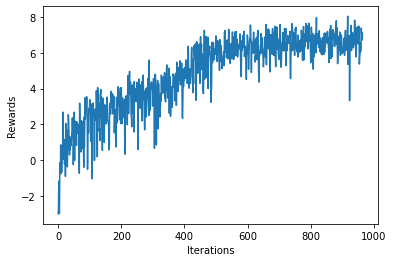

 97%|██████████████████████████████████████████████████████████████████████▌  | 96604/100000 [1:07:21<02:49, 19.99it/s]

Updated Weights
Mean Reward = 7.09
11


 97%|██████████████████████████████████████████████████████████████████████▌  | 96701/100000 [1:07:26<02:43, 20.14it/s]

Updated Weights
Mean Reward = 6.53
8


 97%|██████████████████████████████████████████████████████████████████████▋  | 96803/100000 [1:07:32<03:09, 16.89it/s]

Updated Weights
Mean Reward = 6.52
12


 97%|██████████████████████████████████████████████████████████████████████▋  | 96904/100000 [1:07:38<03:13, 15.96it/s]

Updated Weights
Mean Reward = 6.31
14


 97%|██████████████████████████████████████████████████████████████████████▊  | 96999/100000 [1:07:44<03:07, 16.00it/s]

Updated Weights
Mean Reward = 6.16
11


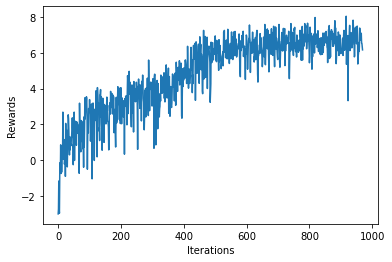

 97%|██████████████████████████████████████████████████████████████████████▉  | 97104/100000 [1:07:52<02:59, 16.14it/s]

Updated Weights
Mean Reward = 6.17
7


 97%|██████████████████████████████████████████████████████████████████████▉  | 97203/100000 [1:07:57<02:43, 17.09it/s]

Updated Weights
Mean Reward = 6.59
16


 97%|███████████████████████████████████████████████████████████████████████  | 97304/100000 [1:08:03<02:43, 16.47it/s]

Updated Weights
Mean Reward = 5.96
16


 97%|███████████████████████████████████████████████████████████████████████  | 97404/100000 [1:08:09<02:28, 17.44it/s]

Updated Weights
Mean Reward = 7.51
12


 97%|███████████████████████████████████████████████████████████████████████▏ | 97499/100000 [1:08:15<03:02, 13.70it/s]

Updated Weights
Mean Reward = 6.54
11


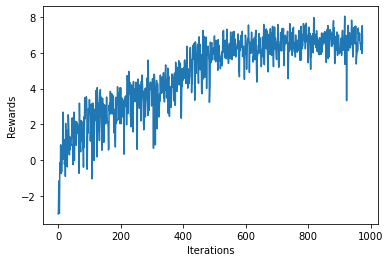

 98%|███████████████████████████████████████████████████████████████████████▎ | 97604/100000 [1:08:22<02:07, 18.84it/s]

Updated Weights
Mean Reward = 7.96
18


 98%|███████████████████████████████████████████████████████████████████████▎ | 97702/100000 [1:08:27<01:45, 21.82it/s]

Updated Weights
Mean Reward = 7.02
20


 98%|███████████████████████████████████████████████████████████████████████▍ | 97805/100000 [1:08:32<01:29, 24.46it/s]

Updated Weights
Mean Reward = 6.86
12


 98%|███████████████████████████████████████████████████████████████████████▍ | 97904/100000 [1:08:36<01:33, 22.43it/s]

Updated Weights
Mean Reward = 6.83
14


 98%|███████████████████████████████████████████████████████████████████████▌ | 97999/100000 [1:08:41<01:37, 20.43it/s]

Updated Weights
Mean Reward = 6.34
10


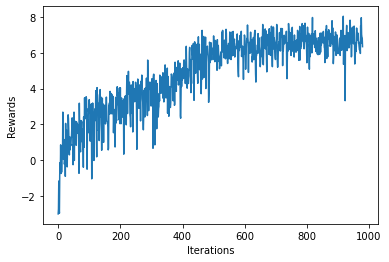

 98%|███████████████████████████████████████████████████████████████████████▌ | 98105/100000 [1:08:46<01:30, 20.95it/s]

Updated Weights
Mean Reward = 5.85
11


 98%|███████████████████████████████████████████████████████████████████████▋ | 98205/100000 [1:08:51<01:21, 22.01it/s]

Updated Weights
Mean Reward = 6.46
12


 98%|███████████████████████████████████████████████████████████████████████▊ | 98304/100000 [1:08:57<02:13, 12.68it/s]

Updated Weights
Mean Reward = 5.94
4


 98%|███████████████████████████████████████████████████████████████████████▊ | 98403/100000 [1:09:06<03:30,  7.57it/s]

Updated Weights
Mean Reward = 6.76
11


 98%|███████████████████████████████████████████████████████████████████████▉ | 98499/100000 [1:09:12<01:09, 21.74it/s]

Updated Weights
Mean Reward = 6.51
12


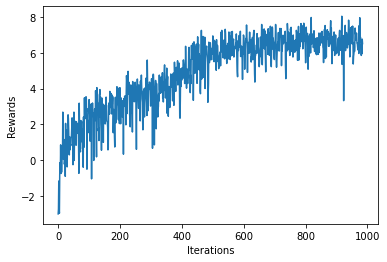

 99%|███████████████████████████████████████████████████████████████████████▉ | 98605/100000 [1:09:17<01:04, 21.60it/s]

Updated Weights
Mean Reward = 7.32
14


 99%|████████████████████████████████████████████████████████████████████████ | 98705/100000 [1:09:22<00:52, 24.48it/s]

Updated Weights
Mean Reward = 6.67
9


 99%|████████████████████████████████████████████████████████████████████████▏| 98804/100000 [1:09:26<00:50, 23.54it/s]

Updated Weights
Mean Reward = 6.37
12


 99%|████████████████████████████████████████████████████████████████████████▏| 98902/100000 [1:09:32<01:08, 16.12it/s]

Updated Weights
Mean Reward = 6.29
10


 99%|████████████████████████████████████████████████████████████████████████▎| 99000/100000 [1:09:39<01:04, 15.49it/s]

Updated Weights
Mean Reward = 6.78
12


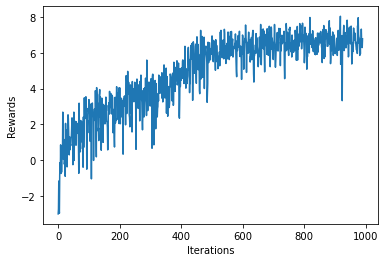

 99%|████████████████████████████████████████████████████████████████████████▎| 99104/100000 [1:09:46<00:53, 16.60it/s]

Updated Weights
Mean Reward = 7.46
16


 99%|████████████████████████████████████████████████████████████████████████▍| 99204/100000 [1:09:51<00:50, 15.75it/s]

Updated Weights
Mean Reward = 8.35
19


 99%|████████████████████████████████████████████████████████████████████████▍| 99303/100000 [1:09:57<00:39, 17.58it/s]

Updated Weights
Mean Reward = 7.57
13


 99%|████████████████████████████████████████████████████████████████████████▌| 99403/100000 [1:10:03<00:37, 15.81it/s]

Updated Weights
Mean Reward = 6.01
11


 99%|████████████████████████████████████████████████████████████████████████▋| 99499/100000 [1:10:08<00:28, 17.68it/s]

Updated Weights
Mean Reward = 6.87
13


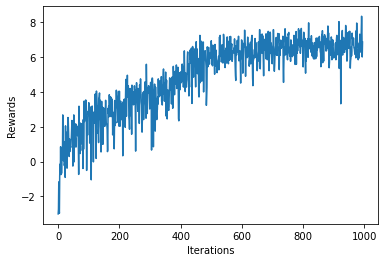

100%|████████████████████████████████████████████████████████████████████████▋| 99602/100000 [1:10:14<00:25, 15.43it/s]

Updated Weights
Mean Reward = 8.13
17


100%|████████████████████████████████████████████████████████████████████████▊| 99703/100000 [1:10:20<00:18, 15.81it/s]

Updated Weights
Mean Reward = 6.64
7


100%|████████████████████████████████████████████████████████████████████████▊| 99805/100000 [1:10:26<00:11, 17.37it/s]

Updated Weights
Mean Reward = 6.95
14


100%|████████████████████████████████████████████████████████████████████████▉| 99903/100000 [1:10:31<00:04, 20.62it/s]

Updated Weights
Mean Reward = 6.94
16


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:10:37<00:00, 23.60it/s]


In [6]:
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
#     start = np.array([0.1,0.1])
#     dest = np.array([0.1,0.3])
    state = [start[0], start[1], dest[0], dest[1]]
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()

    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
#         assert(np.allclose(user_agent.target_model.get_weights(),user_agent.model.get_weights()))
        print('Updated Weights')
#     print(user_agent.model.get_weights())
        
    
    if epoch>50 and epoch%250==0:
        user_agent.epsilon*=0.9
        user_agent.epsilon = max(user_agent.epsilon, 0.1)

    mean_rewards.append(episode_reward)
    if epoch%100==0 and epoch:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [13]:
user_agent.epsilon = 0
done = False
episode_reward = 0
step = 0
start, dest = env.give_start_dest()
#     start = np.array([0.1,0.1])
#     dest = np.array([0.1,0.3])
state = [start[0], start[1], dest[0], dest[1]]
while not done and step<max_steps:
    print(state)
    state = np.array(state)
    next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
    state = next_state
    episode_reward+=reward
    step+=1
    if done:
        reached+=1


[0.9, 0.2, 0.0, 0.0]
[0.8, 0.2, 0.0, 0.0]
[0.7000000000000001, 0.2, 0.0, 0.0]
[0.6000000000000001, 0.2, 0.0, 0.0]
[0.5000000000000001, 0.2, 0.0, 0.0]
[0.40000000000000013, 0.2, 0.0, 0.0]
[0.40000000000000013, 0.1, 0.0, 0.0]
[0.30000000000000016, 0.1, 0.0, 0.0]
[0.30000000000000016, 0.0, 0.0, 0.0]
[0.20000000000000015, 0.0, 0.0, 0.0]
[0.10000000000000014, 0.0, 0.0, 0.0]
[1.3877787807814457e-16, 0.0, 0.0, 0.0]
[-0.09999999999999987, 0.0, 0.0, 0.0]
[-0.19999999999999987, 0.0, 0.0, 0.0]
[-0.09999999999999987, 0.0, 0.0, 0.0]
[-0.19999999999999987, 0.0, 0.0, 0.0]
[-0.09999999999999987, 0.0, 0.0, 0.0]
[-0.19999999999999987, 0.0, 0.0, 0.0]
[-0.09999999999999987, 0.0, 0.0, 0.0]
[-0.19999999999999987, 0.0, 0.0, 0.0]
[-0.09999999999999987, 0.0, 0.0, 0.0]
[-0.19999999999999987, 0.0, 0.0, 0.0]
[-0.09999999999999987, 0.0, 0.0, 0.0]
[-0.19999999999999987, 0.0, 0.0, 0.0]
[-0.09999999999999987, 0.0, 0.0, 0.0]
[-0.19999999999999987, 0.0, 0.0, 0.0]
[-0.09999999999999987, 0.0, 0.0, 0.0]
[-0.19999999999999

In [14]:
print(done)

0
